In [1]:
# Import libraries
import pandas as pd
import numpy as np
import ast
import re
import math
from geopy.geocoders import Nominatim
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
from folium.plugins import FloatImage
import folium # plotting library

import matplotlib.pyplot as plt
import seaborn as sns

# Plotly
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.plotly as py
init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
rest_df = pd.read_csv(r"zomato.csv", encoding='utf-8')

Lets drop duplicates based on the value from two columns address and name

In [3]:
rest_df = rest_df.drop_duplicates(subset=['address', 'name']).reset_index().drop('index', axis=1)

In [4]:
rest_df.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                      080 41714161   
2          Yes         No  3.8/5    918                    +91 9663487993   
3           No         No  3.7/5     88                    +91 9620009302   
4           No         No  3.8/5    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   
3  Banashankari          Quick Bites   
4  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                         800   
1     Chinese, North Indian, Thai                         800   
2          Cafe, Mexican, Italian                         800   
3      South Indian, North Indian                         300   
4        North Indian, Rajasthani                         600   

                                        reviews_list menu_item  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...        []   
1  [('Rated 4.0', 'RATED\n  Had been here for din...        []   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...        []   
3  [('Rated 4.0', "RATED\n  Great food and proper...        []   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...        []   

  listed_in(type) listed_in(city)  
0          Buffet    Banashankari  
1          Buffet    Banashankari  
2          Buffet    Banashankari  
3          Buffet    Banashankari  
4          Buffet    Banashankari

<b>Some of our dish_liked rows are empty, lets extract the dish liked in a restaurant from the reviews in restaurant, All the reviews that were >=3 will be used.</b>

First let us make food corpus for our data


Since the column reviews_list, menu_item are in the form of list of tuples but as we read it from file we need to explicitly convert it to list


In [5]:
rest_df['reviews_list'] =  rest_df['reviews_list'].apply(ast.literal_eval)
rest_df['menu_item'] =  rest_df['menu_item'].apply(ast.literal_eval)

In [6]:
li = []
def func(x):
    global li
    li = li + x
_ = rest_df[rest_df['menu_item']!="[]"]['menu_item'].apply(func)

In [7]:
# convert all the menu to lower case letter and storing in the variable food_corpus
food_corpus = list(map(str.lower, set(li)))

On analysing the corpus it was found that some food contains quantity written beside it inside the brackets.<br>
Let us remove those brackets.

In [8]:
menu_corpus = []
for x in food_corpus:
    menu_corpus.append(re.sub("\[.*\]|\(.*\)", "", x).strip())

In [9]:
len(menu_corpus)

71424

Very well, so we have 71,424 food items in our corpus. But there is no data without noise, let us remove noise from it.

Lets analyse the data, for the words that frequently occur and are not a food item.

In [10]:
ind = rest_df[rest_df['reviews_list']!="[]"].index
for i in ind:
    liked = set()
    for review in rest_df.loc[i,'reviews_list']:
        if(float(review[0].replace('Rated ',''))>=3):
            for menu in menu_corpus:
                if(menu in review[1]):
                    liked.add(menu)
    print(liked)

{'soya chaap', 'paratha', 'papad', 'roti', 'butter', 'rice', 'fried', 'bread', 'paratha.', 'kulcha', 'fried rice', 'chilli paratha', 'palak', 'baby corn', 'butter roti', 'poi', 'masala papad'}
{'garlic fried rice', 'egg', 'fried', 'lunch', 'veggie', 'rice', 'paneer', 'fried rice', 'sweet and spicy', 'paneer kurchan', 'chicken biryani', 'undo', 'chicken', 'spicy', 'sweet', 'roti', 'chicken biryan', 'uttar dakshin', 'veg', 'mix veg', 'burnt garlic fried rice'}
{'coconut milk', 'shakes', 'egg', 'pasta', 'lasagne', 'rice', 'veggie', 'disco', 'nachos', 'coffee', 'chocolate', 'pink pasta', 'hot choco', 'special', 'pizza', 'chocolate sauce', 'veggies', 'milk', 'water', 'choco', 'churros', 'spicy', 'sweet', 'sicilia pizza', 'hot chocolate', 'nutella', 'cake', 'veg', 'smile', 'poi'}
{'rice with sambar', 'rice', 'ghee', 'holige', 'pulka', 'dosa', 'full meals', 'meal', 'special', 'full meal', 'pineapple', 'rice bath', 'water', 'payasam', 'mango', 'veg rice', 'rasam', 'pickle', 'water bottle', 'sw

{'anjal tawa fry', 'anjal', 'pepper chicken', 'rice', 'special chicken', 'prawns tawa fry', 'tandoori roti', 'grill', 'pulpy grape', 'ghee rice', 'chilly chicken', 'chicken kabab', 'shawarma', 'mutton biryani', 'chicken', 'dal', 'butter chicken', 'soda', 'fresh lime', 'chicken skewer', 'butter chicken curry', 'ghee', 'chai', 'butter', 'tawa fry', 'grape juice', 'latte', 'chicken wings', 'butter masala', 'paneer butter masala', 'anjal tawa', 'veg lovers', 'alfaham', 'fresh lime soda', 'chicken biryani', 'chicken curry', 'tandoori chicken', 'spicy', 'parota', 'tandoori', 'pulpy grape juice', 'veg', 'coin parota', 'shakes', 'lime', 'kadai chicken', 'thali', 'noodles', 'paneer', 'paneer butter masala.', 'chocolate', 'dosa', 'grilled chicken', 'chicken kadai', 'kabab', 'alfaham chicken', 'prawns tawa', 'paneer butter', 'chili chicken', 'naan', 'roll', 'lunch', 'chicken gravy', 'al faham', 'chapati', 'panneer butter masala', 'meal', 'special', 'fish', 'choco', 'lollipop', 'kadai', 'roti', 'l

{'egg', 'fried', 'onion raitha', 'rice', 'tea', 'paneer', 'onion', 'butter', 'mushroom', 'special', 'raitha', 'spice', 'rabadi', 'roasted', 'mushroom fry', 'chicken', 'spicy', 'egg chilli', 'mint cooler', 'poratta', 'poi'}
{'roll', 'chicken rolls', 'chicken', 'chicken roll'}
{'naan', 'non-veg', 'pasta', 'veg red sauce pasta', 'fried', 'jamun', 'crispy babycorn', 'seu', 'schezwan noodle', 'noodles', 'packing', 'butter naan', 'rice', 'baby corn chil', 'kit kat', 'paneer', 'coffee', 'churi', 'cold coffee', 'red sauce pasta', 'chicken tikka', 'butter', 'fried rice', 'bread', 'dal khichdi', 'khichdi', 'schezwan noodles', 'meal', 'special', 'garlic bread', 'white sauce pasta', 'chicken tikka masala', 'naan.', 'kit kat shake', 'garlic butter naan', 'butter naan.', 'water', 'paneer tikka', 'chicken noodle', 'chicken noodles', 'chicken noodles.', 'chicken', 'spicy', 'baby corn chilly', 'roti', 'dal', 'cold coffe', 'roomali roti', 'curd', 'curd rice', 'veg', 'veg pasta', 'baby corn', 'poi'}
{'ch

{'overload', 'roll', 'kesar kulfi', 'vanilla ice cream', 'rice', 'chocolate fudge', 'coffee', 'chocolate', 'special', 'kulfi', 'chocolate sauce', 'milk', 'choco', 'lychee', 'blueberry', 'blueberry ice cream', 'sweet', 'fudge', 'vanilla', 'banana', 'wafer', 'ice cream'}
{'naan', 'prawns fried rice', 'biriyani rice', 'fried', 'chicken fried rice', 'panner butter', 'prawns fried rice.', 'biriyani rice.', 'rice', 'noodles', 'butter naan', 'butter', 'fried rice', 'panner butter masala', 'butter masala', 'chicken noodle', 'chicken noodles', 'chicken', 'prawns'}
{'chai'}
set()
{'tandoori kebab', 'chicken roll', 'non-veg', 'roll', 'lunch', 'chicken gravy', 'crispy chicken biryani', 'rice', 'malai kofta', 'tea', 'packing', 'onion', 'chicken tikka', 'kebab', 'shadi ka biryani', 'meal', 'special', 'chicken kabab', 'lemon chicken roll', 'lemon chicken', 'veg lovers', 'chicken biryani', 'mutton biryani', 'tandoori chicken', 'chicken rolls', 'chicken', 'spicy', 'sweet', 'tandoori', 'chicken biryan',

{'lime', 'laddu', 'dahi', 'cap', 'idli', 'chai', 'samosa', 'special', 'kulfi', 'badam milk', 'milk', 'legendary', 'rasmalai', 'sweet', 'badam', 'moti chur laddu', 'curd', 'dahi puri', 'kachori', 'puri'}
{'cheese garlic bread', 'fries', 'pasta', 'fried', 'rice', 'cheese', 'fried rice', 'mushroom', 'schezwan fried rice', 'bread', 'garlic bread', 'mushroom pepper', 'mayonnaise', 'triple schezwan fried rice', 'mayo', 'mixed sauce pasta', 'spicy', 'smile', 'mixed', 'baby corn', 'poi'}
{'butterscotch', 'lime', 'cap', 'rawa dosa', 'set dosa', 'rice', 'onion', 'coffee', 'pulao', 'onion dosa', 'dosa', 'butter', 'butter fruit juice', 'special', 'rice bath', 'pongal', 'fruit juice', 'milk', 'filter coffee', 'sandwich', 'akki rotti', 'milkshake', 'capsicum', 'butterscotch milkshake', 'veg', 'butter fruit', 'poi', 'rava dosa', 'masala dosa'}
{'burger', 'cheese', 'paneer', 'onion', 'capsicum', 'cap', 'veg', 'sandwich', 'pizza'}
{'jal jeera', 'malai paneer', 'plain rice', 'rice', 'pulao', 'corn peppe

{'vadapav', 'special', 'packing', 'smile', 'vada', 'sandwich', 'rice', 'pav'}
{'egg', 'churi', 'chicken manchurian', 'rice', 'biryani rice', 'chicken manchuri', 'spicy', 'packing', 'chicken'}
{'coffee', 'onion', 'churi', 'fried', 'fried rice', 'adas', 'lunch', 'meal', 'vada', 'special', 'rice', 'noodles'}
{'kheema', 'mutton fry biryani', 'veg dum biryani', 'gongura mutton', 'fish curry', 'rice', 'special chicken', 'ghee rice', 'special kabab', 'lemon chicken', 'prawn biryani', 'hulk', 'mutton biryani', 'gongura chicken', 'chicken', 'curd', 'dal', 'fry piece biryani', 'chicken hot', 'chilli chicken', 'veg fried rice', 'fish curry.', 'ghee', 'poriyal', 'paneer curry', 'spite', 'latte', 'biryani rice', 'chicken lollipop', 'phulka', 'ghee rice.', 'water', 'spice', 'chicken biryani', 'chicken curry', 'rasam', 'spicy', 'kebab biryani', 'mutton fry', 'chicken biriyani', 'tandoori', 'crab fry', 'curd rice', 'veg', 'raita', 'crab', 'fried', 'thali', 'paneer', 'fried rice', 'kebab', 'jeera rice'

{'shakes', 'bondas', 'rotis', 'fried', 'paneer chilly', 'gobi manchuri', 'lunch', 'bonda soup', 'carrot halwa', 'north indian thali', 'idli', 'bhaji', 'rice', 'thali', 'pav', 'kharabath', 'mini meal', 'paneer', 'churi', 'coffee', 'paneer butter masala.', 'dosa', 'butter', 'north indian meal', 'halwa', 'fried rice', 'meal', 'special', 'butter masala', 'paneer butter masala', 'pav bhaji', 'kesari', 'milk', 'water', 'masala puri', 'indian meals', 'north indian meals', 'bonda', 'paper masala dosa', 'carrot', 'sandwich', 'paper masala', 'bhajji', 'saga', 'milkshake', 'roti', 'puri', 'indian meal', 'mini meals', 'baby corn', 'ice cream', 'poi', 'masala dosa', 'paneer butter'}
{'pongal', 'thumbs up', 'kotte kadubu', 'wheat pongal'}
{'ghee', 'roti', 'prawn ghee roast', 'rice', 'appam', 'chicken gravy', 'kori roti', 'chicken', 'ghee roast'}
{'rice', 'fried', 'fried rice', 'schezwan fried rice'}
{'fries', 'falafel roll', 'egg', '2 garlic bread', 'pasta', 'veg cheese pasta', 'roll', 'cheese pasta

{'fries', 'shakes', 'egg', 'kheema', 'tender coconut ice cream', 'jackfruit ice cream', 'roll', 'coconut ice cream', 'rice', 'soda', 'kabab', 'fish meal', 'cheese', 'churi', 'cheese fries', 'kebab', 'jackfruit thick shake', 'egg roll', 'meal', 'special', 'tender coconut', 'mango shake', 'jackfruit', 'fish meals', 'milk', 'water', 'mayo', 'mango', 'birthday treat', 'fish', 'sandwich', 'chicken', 'spicy', 'burger', 'milkshake', 'apple', 'sev', 'ice cream', 'poi'}
{'lime', 'egg', 'mast', 'naan', 'fried', 'tomato shorba', 'roll', 'lunch', 'rice', 'veggie', 'cheese', 'papad', 'butter', 'fried rice', 'halwa', 'bread', 'kebab', 'special', 'garlic bread', 'water', 'veggie roll', 'roasted', 'carrot', 'last night', 'veg', 'palak', 'smile', 'ice cream'}
{'fries', 'shakes', 'strawberry shake', 'french fries', 'almond', 'kiwi', 'rice', 'tea', 'disco', 'coffee', 'chocolate', 'red velvet', 'red velvet shake', 'special', 'corn sandwich', 'smoothies', 'milk', 'smoothie', 'sandwich', 'choco', 'spinach c

{'lunch', 'missi roti', 'sabji', 'rice', 'thali', 'disco', 'rajma', 'chai', 'paratha', 'churi', 'ajwain paratha', 'paneer', 'onion', 'butter', 'mushroom', 'meal', 'special', 'combo meal', 'butter masala', 'out of the blue', 'phulka', 'lassi', 'birthday treat', 'hulk', 'fanta', 'tuna', 'pickle', 'spicy', 'roti', 'rajma masala', '2 paratha', 'paratha.', 'poha', 'veg', 'aloo paratha', 'kadhai paneer', 'sev', 'poi'}
{'burger', 'paneer', 'fried momos', 'fried momo', 'hot dog', 'fried', 'roll', 'rice', 'momos'}
{'rose', 'almond', 'orange chocolate', 'tac', 'tea', 'pista', 'chocolate', 'hazel', 'brain', 'tea cake', 'fanta', 'choco', 'eclair', 'strawberry', 'vanilla', 'cake', 'orange', 'passion fruit', 'poi', 'hazelnut'}
{'jamun', 'gulab jamun', 'sweet'}
{'triple fried rice', 'egg', 'non-veg', 'veg fried rice', 'rotis', 'fried', 'schezwan chicken fried rice', 'roll', 'chicken fried rice', 'rice', 'noodles', 'packing', 'chicken dum biryani', 'chai', 'churi', 'spite', 'mushroom fried rice', 'sch

{'dry fruits lassi', 'fries', 'veg cutlets', 'overload', 'egg', 'fruit lassi', 'dal makhni', 'veg kofta', 'mop', 'fried', 'dry fruit', 'fulka', 'french fries', 'parata', 'cheese burst paratha', 'rice', 'veggie', 'thali', 'fruits lassi', 'bharta', 'cheese', 'cheese overload', 'pulkha', 'paratha', 'paneer', 'onion', 'pulao', 'aloo gobhi', 'cheese balls', 'paneer lababdar', 'cheese paratha', 'butter', 'cheese ball', 'papad', 'dry fruit lassi', 'cheesy', 'dal makhani', 'special', 'meal', 'batura', 'paneer paratha', 'veggies', 'lassi', 'water', 'cutlets', 'ice cream', 'hulk', 'gobi aloo', 'dry fruits', 'pakoda', 'do pyaza', 'masala fries', 'spicy', 'sweet', 'spicy fries', 'veg cutlet', 'dal', 'paratha.', 'veg', 'cutlet', 'poi', 'shrikhand', 'matar pulao'}
{'rabadi'}
{'mixture', 'egg', 'veggies', 'curd', 'rice', 'curd rice', 'veg', 'meal', 'veggie'}
{'roll', 'lunch', 'cheese maggi', 'vada pav', 'maggi', 'rice', 'noodles', 'pav', 'tea', 'cheese', 'paneer', 'mosambi', 'oreo', 'paneer roll', 'm

{'fries', 'shakes', 'watermelon', 'fresh juice', 'pasta', 'fried', 'gobi manchuri', 'strawberry milkshake with ice cream', 'potato wedges', 'milkshake with ice cream', 'rice', 'noodles', 'gobi manchuria', 'churi', 'chocolate', 'fried rice', 'pizza', 'strawberry milkshake', 'milk', 'water', 'sandwich', 'choco', 'chocolate milk', 'burger', 'wedges', 'strawberry', 'milkshake', 'chocolate milk shake', 'gobi manchurian', 'ice cream', 'poi'}
{'fruit juice', 'roll', 'sandwich', 'pizza', 'ice cream', 'rice'}
set()
{'choco', 'tornado', 'shakes', 'strawberry', 'chocolate', 'milk', 'rice', 'chocolate milk shake', 'milk shakes', 'ice cream', 'poi', 'chocolate milk', 'sweet'}
set()
set()
{'badam', 'paratha', 'badam milk', 'non-veg', 'milk', 'veg', 'kalakan', 'dhokla', 'special', 'kalakand', 'tea', 'sweet'}
{'chocolate', 'spice', 'ice cream', 'cake', 'smile', 'chocolate ice cream', 'choco', 'rice'}
{'butter murg', 'ida', 'capsicum puff', 'maddur vada', 'poi', 'bun', 'butter', 'capsicum', 'cake', 'ca

{'egg', 'hot and sour', 'rotis', 'fried', 'lunch', 'cap', 'rice', 'veggie', 'kharabath', 'dal tadka', 'ghee', 'thumbs up', 'paneer', 'onion', 'coffee', 'papad', 'corn and capsicum masala', 'churi', 'dosa', 'fried rice', 'tawa fry', 'bread', 'special', 'meal', 'corn capsicum masala', 'paneer ghee roast', 'veggies', 'hot and sour soup', 'bun', 'capsicum masala', 'paneer tikka', 'fish', 'ghee roast', 'spicy', 'saga', 'roti', 'curd', 'dal', 'masala dosa', 'palak soup', 'puri', 'tomato soup', 'capsicum', 'curd rice', 'veg', 'palak', 'kulcha', 'poi', 'masala papad'}
set()
{'kesari', 'coffee', 'apple', 'kesaribath', 'water', 'dosa', 'legendary', 'kesari bath', 'halwa', 'rice', 'khali dosa', 'carrot halwa', 'carrot', 'benne dose', 'pineapple', 'peni'}
{'meal'}
{'egg', 'fried chicken', 'fried', 'veg', 'chicken'}
{'chilli chicken', 'chicken biryan', 'chicken biryani', 'chicken curry', 'mudde', 'chicken'}
{'lunch', 'idli', 'rice', 'coffee', 'pulao', 'dosa', 'meal', 'poori', 'special', 'kesari', '

{'butter chicken', 'onion kulcha', 'naan', 'chicken shorba', 'kheema', 'mutton seekh kabab', 'kulcha', 'paneer starters', 'malai paneer', 'lassi shot', 'mutton rogan', 'rice', 'malai kofta', 'mutton seekh', 'cheese', 'paneer', 'seekh kabab', 'onion', 'paratha', 'chicken tikka', 'butter', 'dal makhani', 'buttermilk', 'naan.', 'lassi', 'spice', 'jalebi', 'rabdi', 'paneer tikka', 'milk', 'chicken soup', 'chicken curry', 'fish', 'cheese naan', 'amritsari fish', 'chicken', 'spicy', 'sweet', 'roti', 'dal', 'raita', 'mixed', 'malai paneer tikka', 'kabab', 'poi'}
{'naan', 'pasta', 'crispy vegetables', 'onion ring', 'lunch', 'noodles', 'tea', 'paneer', 'onion', 'butter', 'rasgulla', 'veg starter', 'litchi', 'rabdi', 'water', 'crispy veg', 'paneer tikka', 'crispy vegetable', 'jamoon', 'chicken', 'spicy', 'sweet', 'onion rings', 'veg starters', 'veg', 'gulab jamoon', 'poi'}
{'peri peri chicken', 'chicken steak', 'pizza', 'peri peri chicken steak', 'chicken', 'tea'}
{'fries', 'baby corn tandoori',

{'fries', 'shakes', 'egg', 'brownie shake', 'choco brownie', 'tac', 'rice', 'veggie', 'choco brownie shake', 'strawberry bliss', 'cheese', 'grill', 'potato burger', 'peri wedges', 'brain', 'special', 'chicken patty', 'brownie', 'veggies', 'lassi', 'hot dog', 'grilled veggies', 'veg exotic burger', 'choco', 'chicken', 'burger', 'wedges', 'strawberry', 'grilled veg', 'potato krunch burger', 'veg', 'smile', 'strawberry bliss mojito', 'mojito'}
{'fries', 'toppings', 'lasagne', 'mocha', 'rice', 'tiramisu', 'peanut', 'barbeque chicken', 'regular pizza', 'bbq pizza', 'chicken bacon prawn pizza', 'ravioli', 'fresh salad', 'chicken', 'banana', 'bacon wrapped prawn', 'berry shake', 'ida', 'veggie', 'cheese cake', 'pesto prawn pizza', 'wasabi', 'bruschetta', 'chai', 'onion', 'chicken pizza', 'spite', 'butter', 'margherita', 'lasagna', 'barbeque chicken pizza', 'veggies', 'spice', 'water', 'mayo', 'blueberry', 'spicy', 'wedges', 'hot chocolate', 'choco mocha cake', 'veg', 'mojito', 'lime', 'pasta'

{'chai', 'rice', 'popcorn', 'fish biriyani', 'veg', 'fish', 'poi', 'popcorn chicken', 'chicken'}
{'smiles', 'butter masala dosa', 'idli', 'rice', 'thali', 'pav', 'churi', 'dosa', 'butter', 'south indian thali', 'special', 'uttapam', 'butter masala', 'spice', 'spicy', 'sweet', 'pani puri', 'puri', 'idly', 'veg', 'smile', 'masala dosa'}
{'3 chapati', 'special chicken thali', 'rotis', 'aloo dry', 'dal fry', 'jamun', 'sabji', 'rice', 'special chicken', 'thali', 'tea', 'chapati', 'paratha', 'chicken thali', 'special', 'keema', 'meal', 'gobhi paratha', 'chicken curry', 'chicken keema', 'chicken', 'roti', 'dal', 'curd', 'raita', 'gulab jamun', 'poi'}
{'paneer', 'green peas masala', 'thali', 'mushroom', 'palak paneer', 'palak', 'peas masala', 'mushroom green peas masala', 'malai kofta', 'green peas'}
{'spice', 'spicy'}
{'lunch combo', 'rice combo', 'churi', 'manchurian balls', 'fried', 'fried rice', 'noodles combo', 'lunch', 'triple schezwan rice', 'schezwan rice', 'rice', 'noodles'}
{'veg cho

{'kathi roll', 'egg', 'chicken 65', 'fried', 'roll', 'cap', 'manchurian chicken', 'chicken fried rice', 'rice', 'noodles', 'churi', 'fried rice', 'egg roll', 'chicken kathi roll', 'chicken egg roll', 'chicken noodle', 'chicken noodles', 'chicken noodles.', 'chicken', 'chicken biriyani', 'chicken fried rice.'}
{'coffee'}
{'potato pops', 'fries', 'veg pizza combo', 'double cheese margherita', 'pasta', 'toppings', 'veg spicy', 'lunch', 'om pizza', 'french fries', 'cap', 'pizza combo', 'apple pie', 'spicy chicken pizza', 'rice', 'tea', 'disco', 'cheese', 'cheese margarita pizza', 'double cheese', 'onion', 'chocolate', 'chicken pizza', 'butter', 'lava cake', 'mushroom', 'bread', 'bbq mushroom pizza', 'cheesy', 'non veg pizza combo', 'brownie cake', 'regular pizza', 'meal', 'special', 'pizza', 'brownie', 'fiery chicken', 'garlic bread', 'margherita', 'pineapple', 'veg meal', 'choco lava cake', 'chilli garlic veg pizza', 'spice', 'mushroom pizza', 'choco', 'chicken', 'veg pizza', 'spicy', 'ch

{'tandoori chicken.', 'naan', 'lunch', 'rice', 'paneer', 'grill', 'paneer chili', 'kebab', 'chicken wings', 'shawarma', 'hariyali kabab', 'chicken biryani', 'chicken curry', 'roasted', 'chicken starters', 'lollipop', 'tandoori chicken', 'chicken', 'rumali', 'spicy', 'grilled chicken', 'tandoori', 'roti', 'chicken biryan', 'executive chicken biryani', 'parotta', 'pop chicken', 'veg', 'lollipop chicken', 'dragon chicken', 'kabab'}
set()
{'papad', 'khichdi', 'palak', 'palak khichdi', 'spicy', 'sweet'}
{'grilled chicken', 'chicken biryan', 'grill', 'lunch', 'chicken biryani', 'fanta', 'special', 'chicken'}
{'fries', 'chocolate chip', 'dry fruit', 'roll', 'french fries', 'jelly', 'smoor sundae', 'chocolate based', 'rice', 'packing', 'paan ice cream', 'coffee', 'chocolate', 'tiramisu', 'irish coffee', 'irish', 'tiramisu cake', 'chocolate sauce', 'milk', 'paan', 'mango', 'choco', 'sweet', 'cake', 'ice cream'}
{'ida', 'chicken lollipop.', 'fried', 'gobi manchuri', 'fried chicken momo', 'rice',

{'chilli paneer', 'ida', 'non-veg', 'hot and sour', 'lunch', 'rice', 'noodles', 'tea', 'dragon chopsuey', 'paneer', 'mushroom', 'manchow soup', 'special', 'meal', 'mushroom pepper salt', 'mushroom pepper', 'veg hot and sour soup', 'exotic vegetables', 'pepper salt', 'manchow', 'hot and sour soup', 'chicken', 'sweet', 'veg dragon chopsuey', 'veg', 'exotic vegetable', 'poi'}
{'buns', 'burger', 'fries', 'bun', 'mayo', 'french fries', 'cutlet'}
{'chicken fry', 'tandoori chicken.', 'tandoori', 'spice', 'carrier meals', 'chana', 'carrier meal', 'lunch', 'meal', 'tandoori chicken', 'chicken', 'thali'}
{'poi'}
{'palak', 'poha', 'poi', 'kachori'}
{'egg', 'veg fried rice', 'fried', 'roll', 'schezwan veg fried', 'rice', 'noodles', 'garlic chicken', 'chicken rice', 'paneer', 'drums of heaven', 'fried rice', 'chilli paneer gravy', 'paneer gravy', 'dragon roll', 'hunan chicken sauce', 'special', 'garlic noodles', 'hunan chicken', 'dragon rolls', 'garlic sauce', 'chicken', 'schezwan veg', 'schezwan v

{'lime', 'pasta', 'toppings', 'roll', 'cap', 'om pizza', 'lunch', 'plain cheese', 'rice', 'disco', 'tea', 'packing', 'cheese', 'chai', 'paratha', 'onion', 'classic pizza', 'spite', 'cheeseless pizza', 'classic', 'chicken pizza', 'mushroom', 'bread', 'cheesy', 'pepperoni', 'cheese pizza', 'regular pizza', 'brain', 'special', 'margherita', 'pizza', 'meal', 'pineapple', "babe's demise pizza", 'mozzarella sticks', 'soft drinks', 'mozzarella pizza', 'toast', 'lassi', 'water', 'spice', 'bun', 'adas', 'mushroom pizza', 'mozzarella stick', 'pesto', 'fanta', 'roasted', 'chicken', 'sweet', 'slice', 'margherita pizza', 'sausage', 'dal', 'apple', 'pizza margherita', 'make your own', 'veg', 'vegetarian pizza', 'margarita pizza', 'mixed', 'coke', 'poi'}
set()
{'burger', 'chicken biriyani', 'fresh juice', 'lassi', 'milk', 'rice', 'cake', 'smile', 'sandwich', 'chicken'}
{'poori', 'sweet', 'palak', 'meal'}
{'paneer', 'churi', 'drums of heaven', 'water', 'fried', 'fried rice', 'rice', 'chicken combo', '

{'garlic fried rice', 'veg chilly', 'ida', 'chicken schezwan noodles', 'fried', 'pepper chicken', 'chicken schezwan noodle', 'chilly garlic fried rice', 'rice', 'schezwan noodle', 'noodles', 'packing', 'burnt pepper chicken', 'lifu chicken', 'non veg chilly', 'fried rice', 'chicken schezwan', 'schezwan fried rice', 'schezwan noodles', 'special', 'veg chilly garlic', 'chicken starters', 'dumpling', 'fish', 'garlic sauce', 'chicken', 'spicy', 'veg chilly garlic fried rice', 'hakka noodles', 'nam prik chicken', 'crispy chicken', 'veg', 'hakka noodle', 'poi'}
{'papad', 'milk', '2 idli', 'pomegranate', 'dosa', 'pomegranate milk shake', 'meal', 'idli', 'rice', 'masala dosa'}
{'bondas', 'prawn ghee roast', 'fried', 'fish curry.', 'fish curry', 'veg curry', 'rice', 'fish meal', 'mackerel', 'ghee', 'tawa fry', 'dosa', 'meal', 'clams sukka', 'chicken ghee roast', 'fish meals', 'squid sukka', 'bonda', 'fish', 'chicken', 'ghee roast', 'spicy', 'sweet', 'neer dosa', 'veg', 'bondas sukka'}
{'chocola

{'chicken curry', 'rice', 'spicy', 'chicken'}
{'2 bread', 'sandwich', 'bread sandwich', 'rice', 'brocolli and almond soup', 'bread', 'almond', 'meal', 'chicken', 'chicken sandwich'}
{'burger', 'fries', 'tea', 'vadapav', 'vada', 'masala fries', 'pav'}
{'watermelon', 'strawberry', 'water', 'banana', 'kulfi'}
{'fries', 'lunch', 'ganji', 'rice', 'fish meal', 'ghee', 'dosa', 'meal', 'kokum', 'chicken ghee roast', 'pepper dry', 'fish meals', 'prawns ghee roast', 'fish', 'masala fries', 'chicken', 'ghee roast', 'neer dosa', 'roti', 'fish pulimunchi', 'chicken pepper', 'kori roti', 'chicken pepper dry', 'prawns'}
{'chicken tandoor', 'chicken tandoori', 'tandoori', 'fish', 'chicken', 'spicy'}
{'fanta', 'rice'}
{'tea', 'egg', 'grill', 'vada', 'vada pav', 'pav'}
{'hulk', 'aloo gobi', 'phulka'}
{'cheese', 'egg', 'paratha', 'chicken pakora', 'fried momos', 'fried momo', 'water', 'fried', 'momos', 'brownie', 'ice cream', 'chicken', 'noodles', 'spicy'}
set()
{'thali', 'paratha', 'special'}
{'roasted 

{'potato twister', 'laddu', 'tikki chat', 'tikki chaat', 'twister', 'dahi', 'aloo tikki', 'bhaji', 'pav', 'tea', 'ghee jalebi', 'ghee', 'bhel puri', 'meal', 'aloo tikki chaat', 'pav bhaji', 'water', 'jalebi', 'paan', 'dabeli', 'bhel', 'sweet', 'dahi puri', 'pani puri', 'kachori', 'puri', 'mixed'}
{'kulfi falooda', 'falooda', 'rose', 'choco', 'choco bar', 'malai kulfi', 'lassi', 'lunch', 'ice cream', 'kulfi', 'sweet'}
{'maida paratha', 'ida', 'paratha', 'whole wheat bread', 'spite', 'grill', 'puri', 'bread', 'kebab', 'special', 'rice', 'thali'}
{'rajma', 'paneer', 'paratha', 'rajma masala', 'masala paratha', 'jamun', 'gulab jamun', 'latte', 'spicy'}
set()
set()
{'chicken tikka.', 'mast', 'black pepper', 'chicken 65', 'rotis', 'chilli baby corn', 'chilli mushroom', 'paneer chilly', 'cap', 'lunch', 'achari chicken tikka', 'achari chicken', 'hyderabad biryani', 'rice', 'chicken dum biryani', 'packing', 'tea', 'paneer', 'drums of heaven', 'butter', 'chicken tikka', 'mushroom', 'bread', 'keb

{'fried', 'cottage cheese', 'peri peri sauce', 'farm house veg pizza', 'rice', 'farm house special pizza', 'tea', 'packing', 'cheese', 'cottage cheese steak', 'african peri peri', 'butter', 'special', 'pizza', 'chicken wings', 'khichadi', 'vada', 'chicken', 'veg pizza', 'cheese steak', 'veg'}
{'dal tadka', 'naan', 'roti', 'dal', 'rotis', 'sabji'}
set()
{'fries', 'shakes', 'pasta', 'milk', 'waffles', 'milk shakes', 'waffle', 'tea'}
set()
{'kabab'}
set()
{'burger', 'classic', 'lassi', 'classic vada pav', 'undo', 'veg', 'vada', 'vada pav', 'rice', 'pav'}
{'nannari juice', 'nippat masala', 'bun butter jam', 'nippat', 'onion', 'bun', 'panipuri', 'puri', 'bun butter', 'butter', 'masala maggi', 'packing', 'maggi', 'gulkand', 'rice', 'spicy'}
{'dal kichdi', 'dal', 'jalebi', 'poha', 'veg', 'kichdi', 'smile', 'sabji'}
{'dates', 'apple'}
{'pongal', 'poori bhaaji', 'ghee', 'coffee', 'dosa', 'idly', 'idli vada', 'lunch', 'ghee dosa', 'veg', 'sambar', 'vada', 'poori', 'variety rice', 'idli', 'rice',

{'fries', 'shakes', 'egg', 'stuffed chicken', 'pasta', 'chicken sizzler', 'eggs', 'cottage cheese', 'lunch', 'roll', 'all meat pizza', 'cap', 'stuffed mushrooms', 'cappuccino', 'vanilla ice cream', 'rice', 'veggie', 'tea', 'nachos', 'pepper sauce', 'cheese', 'special cold coffee', 'onion soup', 'paneer', 'coffee', 'onion', 'cold coffee', 'hazel', 'chicken steak', 'cheese fries', 'grill', 'mushroom', 'bread', 'cheesy', 'cupcake', 'caramel cappuccino', 'special', 'cherry', 'pizza', 'brownie', 'oreo', 'keema', 'cheesy stuffed mushrooms', 'dirty fries', 'fish steak', 'stuffed mushroom', 'veggies', 'spice', 'cottage cheese sizzler', 'fish', 'hazelnut', 'choco', 'chicken keema', 'chicken', 'spicy', 'sweet', 'wedges', 'grilled chicken', 'fish sizzler', 'sausage', 'all meat', 'cold coffe', 'vanilla', 'brownie with vanilla ice cream', 'cake', 'veg', 'special coffee', 'sausages', 'ice cream', 'poi', 'chocochip', 'salad', 'fresh salad'}
{'watermelon', 'poi', 'fried', 'rice', 'special chicken', 'n

{'chai', 'tea'}
set()
{'fruit bowl', 'sandwich', 'tea', 'coffee'}
{'shakes', 'milkshake', 'chai', 'milk', 'ginger chai', 'special'}
{'chicken manchow', 'soft drinks', 'manchow', 'rice', 'triple schezwan rice', 'manchow soup', 'schezwan rice', 'chicken', 'chicken manchow soup'}
set()
{'sholay kabab', 'churi', 'rice', 'mushroom', 'mushroom dry', 'veg', 'chicken starters', 'kabab', 'chicken', 'sweet'}
{'fries', 'shakes', 'egg', 'pasta', 'chicken sizzler', 'fried', 'rice', 'noodles', 'veggie', 'tea', 'red rice', 'coffee', 'cold coffee', 'black current shake', 'fried rice', 'special fried rice', 'mint mojito', 'special', 'white sauce pasta', 'rocher', 'veggies', 'milk', 'spice', 'black current', 'pasta salad', 'fish', 'chicken', 'milkshake', 'salad', 'cold coffe', 'aqua', 'veg', 'poi', 'black current milkshake', 'mojito'}
{'cheese', 'shakes', 'milkshake', 'ida', 'dal', 'milk', 'cheese balls', 'hide and seek', 'cheese ball', 'sandwich'}
set()
{'special'}
set()
{'papad', 'roti', 'rotis', 'mea

{'baby corn curry', 'naan', 'rotis', 'lunch', 'set dosa', 'sabji', 'bhaji', 'rice', 'thali', 'tea', 'coffee', 'onion', 'onion uttappa', 'dosa', 'south indian thali', 'meal', 'special', 'combo meal', 'chole bhature', 'garlic naan', 'paper dosa', 'bhature', 'paper masala dosa', 'filter coffee', 'paper masala', 'chole', 'spicy', 'saga', 'pao bhaji', 'roti', 'dal', 'pani puri', 'idly', 'puri', 'veg', 'sambar', 'baby corn', 'poi', 'masala dosa'}
{'paneer', 'paneer paratha', 'paratha', 'smile', 'meal', 'bhaji'}
{'non-veg', 'chappathi', 'veg', 'meal', 'rice'}
{'lemon chicken', 'drums of heaven', 'rice', 'roll', 'chicken'}
set()
{'chicken manchow', 'fries', 'paneer 65', 'crab', 'butter chicken', 'stress buster', 'pappad', 'chicken 65', 'naan', 'rotis', 'egg', 'fried', 'lunch', 'tac', 'cream of mushroom soup', 'rice', 'malai kofta', 'chicken manchow soup', 'baby corn chil', 'prawns masala', 'fish meal', 'thali', 'veg curry', 'ghee', 'veggie', 'paneer', 'pomfret fry', 'churi', 'anise', 'mangalor

{'fanta', 'rice', 'packing', 'meal'}
set()
{'chocolate', 'rocher', 'chilli guava', 'guava ice cream', 'ice cream', 'mango', 'puri', 'chilli guava ice cream', 'sev', 'berry blast', 'choco', 'poi', 'sweet'}
{'salads', 'meal', 'idli', 'rice', 'salad', 'kpl'}
set()
set()
{'lime', 'veg', 'sandwich', 'rice', 'corn sandwich'}
{'chicken', 'rice', 'spicy', 'special'}
set()
set()
set()
set()
{'egg', 'prawn curry', 'mast', 'naan', 'lunch', 'chicken gravy', 'mutton gravy', 'rice', 'veggie', 'noodles', 'schezwan noodle', 'mutton sheek', 'paneer', 'mutton curry', 'paneer lababdar', 'matha', 'grill', 'schezwan noodles', 'special', 'cherry', 'hyderabadi biryani', 'prawn chilly', 'shawarma', 'veggies', 'lassi', 'rabadi', 'tandoori chicken', 'chicken', 'spicy', 'tandoori', 'cake', 'veg combo', 'veg', 'smile', 'grill chicken', 'poi'}
{'boneless chicken biryani', 'chicken biryan', 'spice', 'water', 'peni', 'chicken biryani', 'lunch', 'meal', 'full meal', 'chicken', 'boneless chicken', 'tea'}
{'phulka', 'a

{'potato twister', 'chocolate sauce', 'chocolate', 'ice cream', 'twister', 'choco', 'rice'}
{'boneless chicken biriyani', 'chicken biriyani', 'tea', 'chilli chicken', 'veg', 'sambar', 'chicken dum biriyani', 'poi', 'boneless chicken', 'spicy', 'chicken'}
{'butterscotch', 'toppings', 'salted caramel', 'almond', 'chocolate ice cream', 'cheesecake', 'rice', 'butter scotch', 'packing', 'disco', 'cheese', 'chai', 'almond praline', 'thumbs up', 'chocolate', 'blue sparkle', 'red velvet', 'butter', 'meal', 'special', 'oreo', 'litchi', 'red velvet ice cream', 'waffle', 'choco', 'fudge', 'red velvet cake', 'vanilla', 'cake', 'waffle cone', 'smile', 'ice cream', 'poi', 'nutty professor sundae'}
{'tandoori roti', 'poi', 'roti', 'tandoori', 'rotis', 'rice', 'meal', 'malai chicken', 'special', 'chicken'}
{'chapati', 'poi', 'non-veg', 'bun', 'mutton chops dry', 'mutton chops', 'veg', 'biryani rice', 'rice', 'spicy'}
{'shakes', 'milkshake', 'milk', 'sandwich', 'rice'}
set()
{'eggless', 'egg', 'macaron

{'north indian thali', 'dosa', 'thali', 'churi'}
{'kulfi'}
set()
{'peda', 'vadapav', 'water', 'samosa', 'vada', 'vada pav', 'pav'}
set()
{'rice', 'grill', 'roll', 'chicken', 'spicy'}
{'kabab', 'veg', 'special'}
set()
set()
set()
{'idli', 'filter coffee', 'coffee'}
{'tea', 'ice tea', 'pasta', 'pizza', 'rice', 'indian pizza'}
{'basmati rice', 'spice', 'rice', 'chicken boneless biryani', 'chicken tikka', 'rabadi', 'jamun', 'family pack biryani', 'sev', 'chicken', 'boneless biryani', 'kpl'}
{'rotis', 'fried', 'toppings', 'paneer chilly', 'rice', 'paneer', 'paratha', 'churi', 'spite', 'butter', 'fried rice', 'meal', 'special', 'butter masala', 'paneer butter masala', 'plain paratha', 'paneer paratha', 'tomato rice', 'water', 'roti', 'dal', 'salad', 'paneer butter'}
{'fish', 'fried', 'fish and chips', 'special', 'rice'}
set()
{'egg', 'spice', 'spicy', 'egg biryani'}
set()
set()
{'roti.', 'soya chaap', 'paneer', 'chole masala', 'roti', 'spice', 'chole', 'kadhai paneer', 'rice'}
{'kabab'}
set(

{'crispy potatoes', 'honey crispy potato', 'noodles', 'crispy potato'}
{'lime', 'lime ginger', 'water', 'sugarcane juice', 'special', 'rice'}
{'burger', 'veg momo', 'veg burger', 'non-veg', 'sprouts', 'supreme', 'samosa', 'momos', 'veg', 'keema vada pav', 'vada', 'vada pav', 'keema', 'veg momos', 'ice cream', 'rice', 'spicy', 'pav'}
set()
{'rice'}
set()
set()
set()
set()
set()
set()
set()
{'non-veg', 'veg & non-veg', 'veg', 'rice'}
set()
set()
set()
{'rice combo', 'rotis', 'jamun', 'rice', 'thali', 'paneer', 'papad', 'butter', 'kebab', 'jeera rice', 'dhokla', 'butter masala', 'paneer butter masala', 'masala puri', 'paneer tikka', 'sandwich', 'hara bhara kebab', 'pulav', 'roti', 'dal', '2 roti', 'puri', 'raita', 'gulab jamun', 'poi', 'paneer butter'}
{'fish', 'dal', 'lunch', 'fish curry', 'rice'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'chilli chicken', 'peri peri chicken', 'toppings', 'roll', 'cap', 'lunch', 'tomato bruschetta', 'dahi', 'cheesecake', 'tea', 'nachos', 've

{'egg', 'pannacotta', 'tac', 'kaapi', 'veggie', 'rice', 'tea', 'nachos', 'paneer', 'tiramisu', 'papad', 'classic', 'butter', 'mushroom', 'red papad', 'kebab', 'rasgulla', 'special', 'filter kaapi', 'raitha', 'veggies', 'lassi', 'water', 'bun', 'roasted', 'butter paneer', 'spicy', 'bhel', 'kebab biryani', 'sweet', 'tandoori', 'pani puri', 'puri', 'veg', 'special pani puri', 'orange', 'chilli paneer', 'ice cream', 'poi'}
{'rice', 'special'}
{'chilli mushroom fried rice', 'fries', 'egg', 'ida', 'naan', 'pasta', 'hot and sour', 'rotis', 'fried', 'chilli mushroom', 'lunch', 'rice', 'noodles', 'tea', 'kabab', 'rajma', 'chai', 'paneer', 'churi', 'papad', 'seekh kabab', 'ice tea', 'mushroom fried rice', 'fried rice', 'mushroom', 'bread', 'halwa', 'special', 'veg kolapuri', 'brownie', 'garlic naan', 'veg biryani', 'kulfi', 'roti.', 'bombay', 'bun', 'veg lovers', 'paan', 'spice', 'water', 'undo', 'chole', 'spicy', 'sweet', 'roti', 'apple', 'rabri', 'puri', 'veg', 'raita', 'sizzling brownie', 'ic

{'fries', 'chicken tacos', 'lasagne', 'rice', 'ice tea', 'tiramisu', 'red velvet', 'peanut', 'cheesy', 'milk', 'hummus', 'dumpling', 'chicken', 'macaroni', 'pomegranate', 'mac n cheese', 'milk shakes', 'veggie', 'nachos', 'veg enchilada', 'bruschetta', 'chai', 'coffee', 'chicken lasagna', 'latte', 'lasagna', 'blueberry cheese', 'panna cotta', 'veggies', 'spice', 'blueberry', 'poached egg', 'sausage', 'milkshake', 'chilli jam', 'vanilla', 'veg', 'chicken nachos', 'mojito', 'pita bread', 'shakes', 'lime', 'blueberry cheesecake', 'pasta', 'mac and cheese pasta', 'cheese pasta', 'cheesecake', 'tac', 'cheese', 'paneer', 'mushroom', 'pizza', 'cheese sandwich', 'slice', 'strawberry', 'mac and cheese', 'red velvet cake', 'poi', 'mac n cheese pasta', 'egg', 'non-veg', 'eggs', 'lunch', 'chicken stroganoff', 'mexican cheesy fries', 'tea', 'stroganoff', 'red velvet shake', 'bread', 'special', 'garlic bread', 'strawberry milkshake', 'adas', 'roasted', 'fish', 'sandwich', 'cheesy fries', 'chicken st

{'tandoori chicken.', 'butter chicken', 'naan', 'rotis', 'lunch', 'jamun', 'veg pulav', 'plain rice', 'veg pulao', 'chicken biryani combo', 'boiled rice', 'sabji', 'rice', 'thali', 'veg executive thali', 'special chicken', 'ghee', 'paneer', 'handi biryani', 'pulao', 'biryani combo', 'masala c', 'butter', 'grill', 'executive thali', 'kebab', 'special', 'meal', 'biryani rice', 'veg biryani', 'chicken ghee roast', 'roti.', 'water', 'rabadi', 'dum biryani', 'chicken biryani', 'tandoori chicken', 'chicken', 'ghee roast', 'spicy', 'sweet', 'grilled chicken', 'pulav', 'paneer sabji', 'tandoori', 'roti', 'dal', 'chicken biryan', 'veg', 'raita', 'mixed', 'grill chicken', 'gulab jamun', 'poi', 'prawns'}
{'roll', 'rice', 'tea', 'packing', 'chai', 'chocolate', 'pizza', 'toast', 'sandwich', 'choco', 'sweet', 'wheat roti', 'gol gappa', 'roti', 'papdi', 'puri', 'millet', 'veg', 'smile'}
{'butterscotch', 'chocolate chip', 'lays', 'chocolate chips', 'dark chocolate', 'chocolate', 'red velvet', 'butter'

{'paratha', 'paneer', 'poi', 'mushroom', 'veg', 'special', 'rice', 'thali'}
{'biscuits', 'nippat', 'salt biscuit', 'cake', 'black forest', 'plum cake', 'biscuit', 'pizza', 'black forest cake', 'pastry', 'salt biscuits'}
{'poi', 'meal'}
{'pongal', 'madur vada', 'dosa', 'idli', 'bonda', 'bonda soup', 'packing', 'sambar', 'vada', 'sev', 'spicy', 'masala dosa'}
{'burger', 'fries', 'rice'}
{'watermelon', 'ida', 'fried', 'lunch', 'tawa fish', 'rice', 'thali', 'tea', 'ghee', 'thumbs up', 'onion', 'spite', 'chicken thali', 'duck pepper fry', 'fried rice', 'melon juice', 'appam', 'manchow soup', 'watermelon juice', 'special', 'cherry', 'meal', 'pomfret', 'pollichathu', 'mutton stew', 'manchow', 'water', 'mango', 'chicken biryani', 'fish', 'chicken', 'ghee roast', 'fish fry', 'tawa fish fry', 'chicken biryan', 'pepper fry', 'banana', 'sambar', 'poi'}
{'mutton fry', 'chapati', 'mutton fry piece biryani', 'chicken fry', 'mutton meals', 'fry piece biryani', 'rice', 'lunch', 'mutton gravy', 'meal', 

{'neer dosa', 'fish', 'ghee', 'prawn ghee roast', 'fried', 'fried rice', 'dosa', 'chicken ghee roast', 'fish tawa fry', 'tawa fry', 'veg', 'special', 'cherry', 'rice', 'ghee roast', 'tea', 'chicken'}
{'rice combo', 'mutton biriyani', 'lunch', 'rice', 'ghee', 'onion', 'ghee rice combo', 'masala onion', 'grill', 'kebab', 'ghee rice', 'meal', 'special', 'raitha', 'rabadi', 'mayo', 'chicken', 'spicy', 'tandoori', 'dal', 'crispy chicken', 'last night', 'grill chicken', 'kabab'}
{'egg', 'veggies', 'avocado', 'rice', 'roll', 'veg', 'veggie'}
{'chocolate milkshake', 'peanut butter cookie', 'lemon ice tea', 'cheesecake', 'veg puff', 'tea', 'cheese', 'ice tea', 'coffee', 'chocolate', 'butter', 'peanut', 'hot choco', 'tyropita', 'milk', 'bangalore mudpie', 'cookie', 'sandwich', 'choco', 'chocolate milk', 'sweet', 'chocolate milkshak', 'hot chocolate', 'milkshake', 'peanut butter', 'espresso', 'cake', 'iced tea', 'veg', 'pastry'}
{'paneer paratha', 'paratha', 'paneer', 'onion', 'jalebi', 'kachori'

{'choco', 'chola', 'strawberry', 'chocolate', 'water', 'rice', 'banana sundae', 'special', 'banana', 'veg', 'fanta', 'maggi', 'oreo', 'ice cream', 'kit kat', 'noodles', 'banana split'}
{'fries', 'lime', 'brownie delight', 'roll', 'biscuit', 'rice', 'thumbs up', 'coffee', 'chocolate', 'cold coffee', 'special', 'oreo', 'brownie', 'pizza', 'pineapple', 'waffle', 'choco', 'biscuits', 'apple', 'cold coffe', 'waffles', 'brownie bash', 'ice cream', 'rocher'}
{'bhindi', 'lunch', 'sabji', 'rice', 'thali', 'disco', 'chapati', 'paneer', 'papad', 'paneer curry', 'butter', 'meal', 'cucumber salad', 'special', 'poori', 'phulka', 'milk', 'spice', 'jalebi', 'rabadi', 'khichadi', 'hulk', 'kadhi', 'pickle', 'spicy', 'sweet', 'dal', 'butter milk', 'farsan', 'sev', 'poi', 'salad', 'special thali'}
set()
{'khushka', 'special', 'fish'}
{'truffle chocolate cake', 'chocolate cake', 'chocolate', 'cake', 'choco'}
{'packing', 'rice', 'tea', 'chicken'}
set()
{'grilled chicken', 'fresh juice', 'shawarma', 'rice', 

{'egg', 'butter chicken', 'chicken roll', 'naan', 'non-veg', 'rotis', 'fried', 'kalmi', 'roll', 'chicken gravy', 'chicken dopiyaza', 'rice', 'hyderabadi chicken', 'egg fried', 'butter', 'grill', 'fried rice', 'egg fried rice.', 'kebab', 'rumali roti', 'roti.', 'chicken dopyaza', 'shawarma', 'rabadi', 'roasted', 'kushka', 'tandoori chicken', 'chicken', 'rumali', 'spicy', 'chicken kebab', 'grilled chicken', 'chicken biriyani', 'tandoori', 'roti', 'roomali roti', 'dal', 'last night', 'veg', 'egg fried rice', 'grill chicken', 'kabab', 'shawarma roll'}
set()
{'rice'}
{'shakes', 'healthy juice', 'rice', 'mosambi', 'spite', 'grape juice', 'lemon juice', 'oreo', 'corn sandwich', 'fruit juice', 'milk', 'masala puri', 'sandwich', 'spicy', 'sweet', 'fresh fruit juice', 'milkshake', 'oreo milk shake', 'puri', 'milk shakes', 'grape', 'ice cream', 'coke', 'mosambi juice'}
{'fries', 'watermelon', 'chicken burger', 'masala soda', 'rice', 'soda', 'veg burger', 'chai', 'mushroom', 'watermelon masala', '

{'eggless', 'blueberry cake', 'egg', 'rusk', 'rice', 'cheese cake', 'butter scotch', 'cheese', 'mini pizza', 'chocolate cake', 'chocolate', 'butter', 'pizza', 'white forest', 'water', 'cookie', 'choco', 'blueberry', 'sweet', 'strawberry', 'white forest pastry', 'cake', 'peni', 'pastry'}
set()
set()
set()
{'cheese', 'veg cheese grill', 'bun', 'grill', 'omlette', 'bread', 'veg', 'sandwich', 'mix veg', 'bun omlette', 'chicken', 'chicken sandwich'}
{'buns', 'potato bun', 'apple cake', 'apple', 'bun', 'legendary', 'honey cake', 'cake', 'groundnut', 'congress', 'veg puffs', 'fruit cake', 'veg', 'butter', 'bread', 'special', 'rice', 'veg puff'}
{'poi', 'hot chocolate fudge', 'dry fruit', 'black forest', 'almond', 'rice', 'chocolate fudge', 'chocolate', 'spite', 'evergreen', 'hot choco', 'chocolate sauce', 'water', 'cake fudge', 'groundnut', 'dry fruits', 'choco', 'black forest cake', 'hot chocolate', 'fudge', 'apple crumble', 'apple', 'cake', 'ice cream', 'almond fudge', 'cashew', 'death by c

{'cheese', 'choco lava cake', 'farmhouse pizza', 'veg farmhouse pizza', 'lava cake', 'cake', 'cap', 'capsicum', 'choco lava', 'veg', 'special', 'pizza', 'choco', 'poi', 'veg pizza', 'farmhouse'}
{'coffee', 'idly', 'vada', 'rice', 'tea'}
{'overload', 'ida', 'toppings', 'rice', 'tea', 'lemonade', 'cheese', 'onion', 'chole masala', 'bread', 'meal', 'pizza', 'margherita', 'garlic bread', 'masala lemonade', 'spice', 'chole', 'veg pizza', 'spicy', 'slice', 'masala lemon', 'veg'}
{'fish curry', 'rice', 'fish meal', 'tea', 'ghee', 'dosa chicken', 'tawa fry', 'dosa', 'meal', 'special', 'bangda tawa fry', 'chicken sukka', 'chicken ghee roast', 'fish meals', 'prawns ghee roast', 'spice', 'bangda', 'fish', 'chicken', 'ghee roast', 'bangda tawa', 'dal', 'prawns sukka', 'kabab', 'prawns'}
{'slice', 'churi', 'onion', 'roti', 'fried', 'fried rice', 'roll', 'special', 'rice', 'noodles', 'spicy'}
{'badam halwa', 'kesari bhat', 'idli vada', 'poori sagu', 'idli', 'rice', 'tea', 'ghee', 'coffee', 'dosa', '

{'rice'}
{'rice'}
set()
set()
{'chai', 'roti', 'rice', 'dosa', 'parotta', 'special', 'chapathi', 'south meal', 'meal', 'poi', 'masala dosa'}
set()
set()
{'parota', '2 parota', 'chicken roll', 'cop', 'roll', 'special', 'chicken'}
set()
{'special', 'pickle', 'meal'}
set()
set()
{'lunch', 'bele bath', 'idli', 'rice', 'tea', 'medu vada', 'veg south indian', 'ghee', 'coffee', 'classic', 'dosa', 'butter', 'bisibele bath', 'special', 'meal', 'rice bath', 'pongal', 'milk', 'lassi', 'vada', 'green tea', 'sweet', 'akki rotti', 'pulav', 'idly', 'butter milk', 'veg', 'sambar', 'poi', 'rava dosa', 'masala dosa'}
{'kheer', 'salads', 'naan', 'gajar halwa', 'veg roll', 'roll', 'lunch', 'papdi chaat', 'fish curry', 'moong dal halwa', 'rice', 'tea', 'paneer', 'paratha', 'chocolate', 'dosa', 'halwa', 'moong dal', 'brownie cake', 'special', 'steamed rice', 'veg starter', 'brownie', 'naan.', 'chocolate lava', 'spice', 'shahi paneer', 'chicken biryani', 'chicken curry', 'fanta', 'fish', 'stir fry vegetable'

{'fish curry', 'rice', 'ice tea', 'churi', 'grill', 'halwa', 'corn kernel', 'paneer pasand', 'white pasta', 'chicken', 'sandesh', 'dal', 'sarson da saag', 'banana', 'misti doi', 'paneer pasanda', 'mustard fish', 'aloo posta', 'grilled prawns', 'jamun', 'veggie', 'disco', 'spite', 'kofta curry', 'steamed rice', 'pineapple', 'luchi', 'veggies', 'spice', 'water', 'chicken curry', 'spicy', 'corn kernels', 'gilafi seekh', 'makai roti', 'veg', 'murgh tikka', 'crab', 'pasta', 'fried', 'crab curry', 'paan ice cream', 'paneer', 'fried rice', 'mushroom', 'kebab', 'tangdi kebab', 'rabadi', 'spirit', 'apple', 'crispy corn', 'mixed fruit', 'palak', 'mixed', 'ice cream', 'makai ki roti', 'poi', 'watermelon', 'egg', 'eggs', 'roll', 'lunch', 'firni', 'tea', 'chana dal', 'rasgulla', 'special', 'meal', 'paan', 'paneer tikka', 'chana', 'lamb seekh kebab', 'pan ice cream', 'fish', 'bhaja', 'sweet', 'roti', 'cake', 'peni', 'salad', 'prawns'}
{'pepper chicken', 'plain rice', 'fish curry', 'rice', 'rajma', '

{'falafel bowl', 'salads', 'mop', 'falafel', 'roll', 'ginger chai', 'lunch', 'rice', 'tea', 'chicken grilled', 'omelette', 'chai', 'fruit bowl', 'spite', 'grill', 'latte', 'stuffed omelette', 'shawarma', 'ginger tea', 'milk', 'detox water', 'detox', 'water', 'omelet', 'sandwich', 'chicken grilled burger', 'chicken', 'sweet', 'burger', 'chicken shawarma', 'veg', 'chicken bowl', 'salad'}
{'chai', 'coffee', 'caramel latte', 'lassi', 'water', 'milk', 'latte', 'rice'}
{'chocolate donut', 'club sandwich', 'coffee', 'chocolate', 'cold coffee', 'cold coffe', 'cake', 'almond', 'croissant', 'cup cakes', 'donut', 'sandwich', 'choco'}
{'chai', 'coffee', 'roll', 'iced tea', 'tea'}
{'cheese toast', 'shakes', 'lime', 'egg', 'chilly cheese toast', 'mint green tea', 'veg wrap', 'toppings', 'cap', 'lime and mint', 'cappuccino', 'rice', 'veggie', 'tea', 'cheese', 'double cheese', 'coffee', 'chocolate', 'cold coffee', 'onion', 'special', 'latte', 'pizza', 'frappe', 'chicken patty', 'chilly cheese', 'toast

{'egg', 'lays', 'dry fruit', 'potato chips', 'veggie', 'rice', 'tea', 'noodles', 'masala chicken', 'cheese', 'chicken pop', 'chicken steak', 'masala c', 'grill', 'cheesy', 'grilled chicken steak', 'veggies', 'bun', 'chicken popcorn', 'chicken biryani', 'popcorn', 'chicken', 'spicy', 'grilled chicken', 'mac and cheese', 'chicken biryan', 'cake', 'veg', 'cheesy chicken', 'mixed', 'cheesy chicken popcorn'}
{'shakes', 'naan', 'idli', 'rice', 'thali', 'butter naan', 'ghee', 'paneer', 'coffee', 'churi', 'dosa', 'butter', 'south indian thali', 'meal', 'poori', 'sweet lassi', 'aloo curry', 'sambhar', 'lassi', 'shahi paneer', 'papdi chat', 'adas', 'vada', 'sweet', 'papdi', 'upma', 'kadhai paneer', 'salad'}
set()
{'fish', 'lemon pickle', 'natholi fry', 'rice', 'achari chicken', 'lunch', 'appam', 'natholi', 'prawn masala', 'fish curry', 'special', 'mixed', 'pickle', 'chicken', 'spicy'}
{'kheer', 'lunch', 'aloo puri chole kheer', 'rice', 'packing', 'paratha chole', 'cheese', 'ghee', 'paratha', 'pa

{'chicken masala', 'naan', 'non-veg', 'rotis', 'pepper chicken', 'lunch', 'chicken gravy', 'rice', 'green peas', 'butter naan', 'kabab', 'tikka biryani', 'ghee', 'churi', 'toum', 'butter', 'grill', 'chicken tikka', 'bread', 'pepper chicken masala', 'ghee rice', 'kebab', 'chicken hyderabadi biryani', 'hyderabadi biryani', 'chicken hyderabadi', 'veg lovers', 'hummus', 'rabadi', 'mayo', 'fish', 'chicken', 'spicy', 'grilled chicken', 'parota', 'chicken tikka biryani', 'roti', 'veg', 'grill chicken', 'sev', 'chicken hyderabad', 'poi', 'grilled fish'}
{'lime', 'egg', 'ida', 'naan', 'paneer tikka biryani', 'fried', 'boiled egg', 'brinjal biryani', 'lunch', 'tac', 'veg thali', 'rice', 'special chicken', 'packing', 'tea', 'thali', 'garlic chicken', 'tikka biryani', 'thumbs up', 'paneer', 'bamboo chicken', 'butter', 'fried rice', 'schezwan fried rice', 'bread', 'chicken crispy', 'special chicken biryani', 'kebab', 'special', 'meal', '1 boiled egg', 'boiled egg.', 'butter masala', 'paneer butter 

{'naan.', 'chai', 'butter paneer masala', 'paneer', 'naan', 'butter naan.', 'spice', 'butter', 'lunch', 'palak paneer', 'veg', 'palak', 'butter paneer', 'paneer masala', 'special', 'rice', 'tea', 'butter naan'}
set()
{'chilly chicken', 'meal', 'biryani rice', 'rice', 'kabab', 'chicken'}
{'paneer biryani', 'ida', 'non-veg', 'mutton biriyani', 'hyderabadi mutton biryani', 'kesari phirni', 'lunch', 'jamun', 'seu', 'rice', 'packing', 'tikka biryani', 'paneer', 'hyderabadi chicken', 'chicken tikka', 'non veg combo', 'special', 'meal', 'veg biryani', 'kesari', 'hyderabadi mutton', 'boneless chicken tikka', 'spice', 'phirni', 'rabadi', 'paneer tikka', 'chicken biryani', 'hyderabadi chicken biryani', 'mutton biryani', 'chicken', 'boneless chicken', 'sweet', 'hyderbadi biryani', 'claypot hyderabadi chicken biryani', 'chicken tikka biryani', 'chicken biryan', 'veg combo', 'veg', 'raita', 'gulab jamun', 'mixed', 'mix veg', 'sev', 'poi'}
{'chilli mutton', 'kheema', 'naan', 'hot and sour', 'cap', '

{'egg', 'butter chicken', 'pasta', 'lunch', 'lasagne', 'veggie', 'rice', 'tandoori kukkad', 'tea', 'packing', 'cheese', 'paneer', 'chocolate', 'butter chicken mac n cheese', 'butter', 'chicken tikka', 'chicken mac n cheese', 'cheesy', 'chicken lasagna', 'meal', 'chocolate lover', 'lasagna', 'bombay', 'veggies', 'roasted', 'choco', 'paneer steak', 'chicken', 'tandoori', 'bombay masala quesadilla', 'minced chicken', 'mac n cheese', 'veg', 'desi videsi'}
{'chilli chicken', 'mast', 'naan', 'lunch', 'rice', 'butter naan', 'chai', 'butter', 'mushroom', 'special', 'mushroom masala', 'spicy shawarma', 'shawarma', 'spice', 'veg lovers', 'chicken curry', 'roasted', 'tandoori chicken', 'chicken', 'spicy', 'sweet', 'chicken biriyani', 'tandoori', 'veg', 'poi'}
{'mazza'}
{'kheer', 'paneer makhani', 'overload', 'veg roll', 'dry fruit', 'roll', 'dahi', 'cap', 'lunch', 'sabudana vada', 'sabudana', 'sabji', 'parata', 'rice', 'thali', 'packing', 'cheese', 'singara', 'paratha', 'paneer', 'paneer curry', 

{'egg', 'veggies', 'veg', 'veggie', 'noodles'}
{'chicken manchow', 'pepper chicken', 'lunch', 'veg crispy', 'rice', 'thali', 'chicken manchow soup', 'family biryani', 'kebab', 'manchow soup', 'special', 'chilli prawns', 'manchow', 'rabadi', 'chicken biryani', 'red hot chicken', 'chicken', 'boneless chicken', 'spicy', 'boneless chicken biryani', 'chicken briyani', 'chicken biryan', 'chilli prawn', 'veg', 'mixed', 'baby corn', 'kulcha', 'poi', 'prawns'}
{'shakes', 'chilli chicken', 'poi', 'baklava', 'toppings', 'roll', 'rice', 'spinach and corn quiche', 'tea', 'cheese', 'chai', 'chicken pizza', 'classic', 'chilli cheese', 'chicken tikka', 'mushroom', 'peanut', 'cheese pizza', 'kebab', 'chicken sausage', 'chicken cutlet', 'special', 'cherry', 'pizza', 'chicken wings', 'roti.', 'lassi', 'water', 'cocktail', 'cock', 'chicken bao', 'spring rolls', 'cool breeze', 'classic chicken tikka', 'fish', 'popcorn', 'chicken', 'fish tikka', 'sweet', 'sausage', 'roti', 'aqua', 'ajwaini fish tikka', 'cak

AttributeError: 'NoneType' object has no attribute 'replace'

After analysing the above output these were some of the frequent non menu words found.

In [11]:
remove_words = ['poi', 'spite', 'churi', 'peni', 'packing', 'meal', 'malt', 'smilies', 'disco', 'tac', 'cap', 'spicy', 'last night', 'cop', 
'brain', 'onion', 'spice', 'holige', 'adas', 'sulaimani', 'special', 'combo 4', 'toppings', 'smile', 'water', 'ghee', '',
'mixed', 'slice', 'lunch', 'masala c', 'churi', 'breakfast combo', 'undo', 'full meal', 'fanta', 'cool blue', 'love', 'veg lovers',
'irish', 'fried', 'mast', 'rose', 'overload']

In [12]:
# Lets remove them from our corpus first
new_menu_corpus = [word for word in menu_corpus if word not in remove_words]

In [13]:
len(new_menu_corpus)

71363

In [14]:
# perfect now those noise are removed, let us extract menus from review and store it in the column liked_food_from_review

rest_df['liked_food_from_review'] = rest_df['reviews_list'].astype(object)
rest_df['liked_food_from_review'] = "[]"

In [17]:
ind = rest_df[rest_df['reviews_list']!="[]"].index
for i in ind:
    
    liked = set()
    for review in rest_df.loc[i,'reviews_list']:
        if(review[0]!=None and float(review[0].replace('Rated ',''))>=3):
            for menu in new_menu_corpus:
                if(menu in review[1]):
                    liked.add(menu)
    rest_df.loc[i,'liked_food_from_review'] = str(list(liked))

In [18]:
rest_df['liked_food_from_review'] =  rest_df['liked_food_from_review'].apply(ast.literal_eval)

In [19]:
# Now that we have liked food for a restaurant, lets see
rest_df.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5    787                      080 41714161   
2          Yes         No  3.8/5    918                    +91 9663487993   
3           No         No  3.7/5     88                    +91 9620009302   
4           No         No  3.8/5    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type  \
0  Banashankari        Casual Dining   
1  Banashankari        Casual Dining   
2  Banashankari  Cafe, Casual Dining   
3  Banashankari          Quick Bites   
4  Basavanagudi        Casual Dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                         800   
1     Chinese, North Indian, Thai                         800   
2          Cafe, Mexican, Italian                         800   
3      South Indian, North Indian                         300   
4        North Indian, Rajasthani                         600   

                                        reviews_list menu_item  \
0  [(Rated 4.0, RATED\n  A beautiful place to din...        []   
1  [(Rated 4.0, RATED\n  Had been here for dinner...        []   
2  [(Rated 3.0, RATED\n  Ambience is not that goo...        []   
3  [(Rated 4.0, RATED\n  Great food and proper Ka...        []   
4  [(Rated 4.0, RATED\n  Very good restaurant in ...        []   

  listed_in(type) listed_in(city)  \
0          Buffet    Banashankari   
1          Buffet    Banashankari   
2          Buffet    Banashankari   
3          Buffet    Banashankari   
4          Buffet    Banashankari   

                              liked_food_from_review  
0  [soya chaap, paratha, papad, roti, butter, fri...  
1  [sweet and spicy, garlic fried rice, egg, pane...  
2  [coconut milk, shakes, egg, pasta, lasagne, ri...  
3  [rice with sambar, rice, pulka, dosa, full mea...  
4  [pav bhaji, smiles, paratha, roti, papdi, milk...

In [20]:
# Also lets convert dishes from our dish_liked column to lower case letters
rest_df['dish_liked'] = rest_df['dish_liked'].str.lower()

In [21]:
# Also lets split dish_liked
rest_df['menus_combined'] = rest_df['dish_liked'].str.split()+ rest_df['liked_food_from_review']

### Exploratory Data Analysis

How many different restaurants are there in Bengaluru

In [22]:
histo = rest_df.groupby('name')['address'].count()
# Lets take the top 50 restaurantsand plot bar graph
histo = histo.sort_values()[-50:]

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing

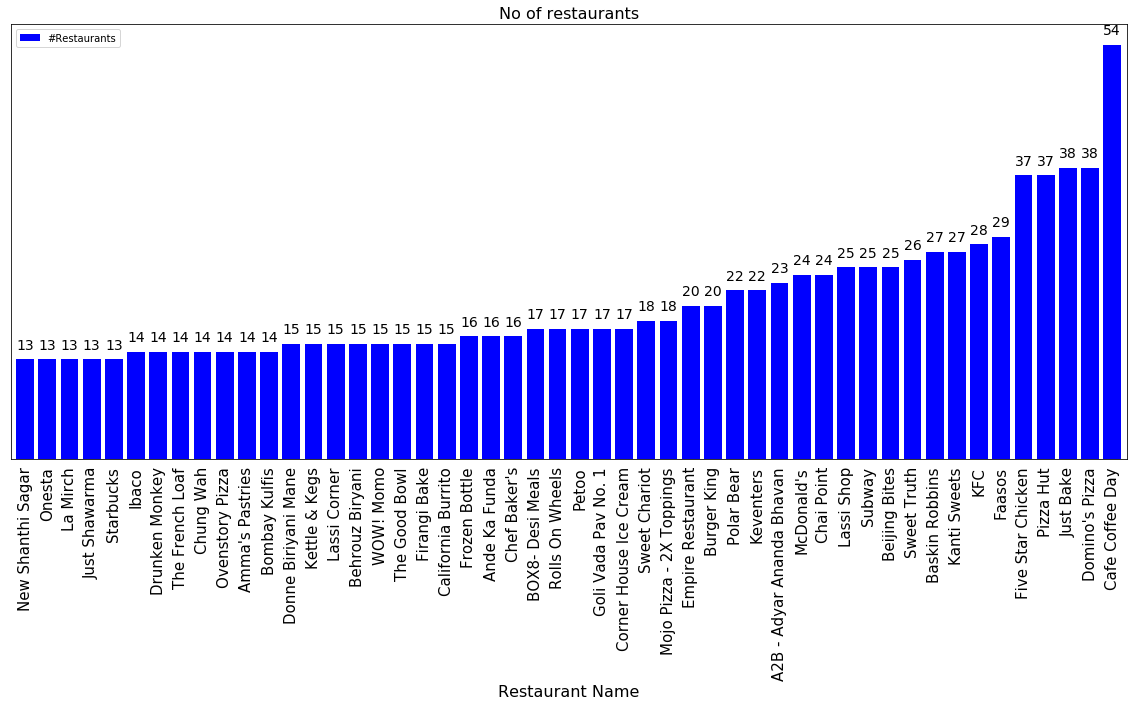

In [23]:
ax = histo.plot(kind='bar', figsize=(20, 8), rot=90, width = 0.8, color=[ 'blue'])
rects = ax.patches
labels = list(histo)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom', fontsize=14)
ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on') # remove borders
ax.xaxis.set_tick_params(labelsize=15) # set xticks as 14
ax.legend(fontsize=14) # set legend sie as 14
ax.set_title('No of restaurants', fontsize=16) # set title and add font size as 16
ax.set_xlabel('Restaurant Name', fontsize=16)
#ax.grid(False)  # remove grid
ax.set_facecolor("white") # set bg color white
ax.legend(['#Restaurants'])

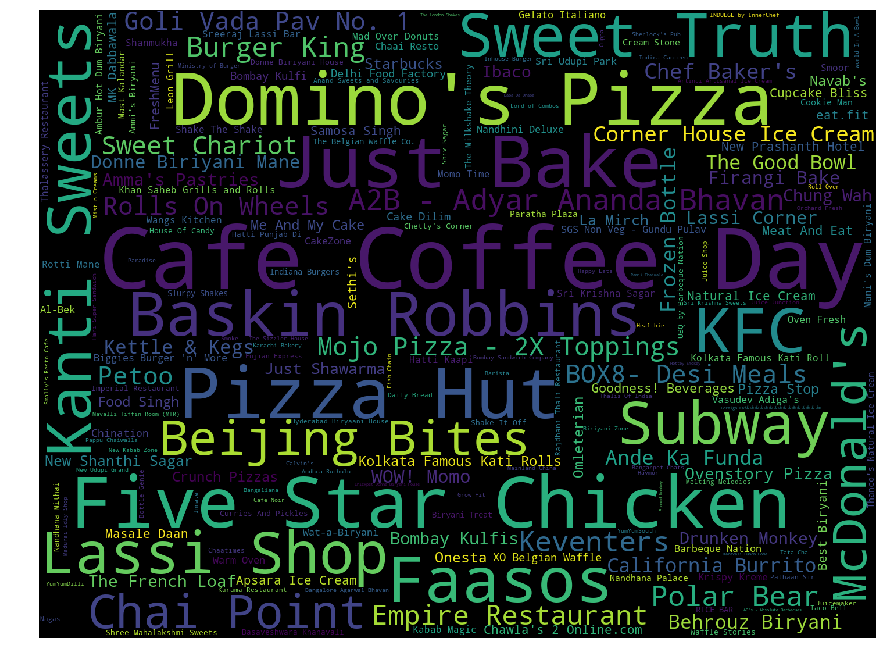

In [24]:
from subprocess import check_output
from wordcloud import WordCloud
wordcloud = (WordCloud(width=1440, height=1080, relative_scaling=0.5).generate_from_frequencies(rest_df['name'].value_counts()))


fig = plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<img src="https://i.ibb.co/sw1PSWv/wordcloud.png" alt="wordcloud" height="1500" width="1500">

Clearly CCD(Cafe) has the most number of restaurants in Bengaluru, followed by Domino's Pizza

### Delivery Restaurant and Table Book

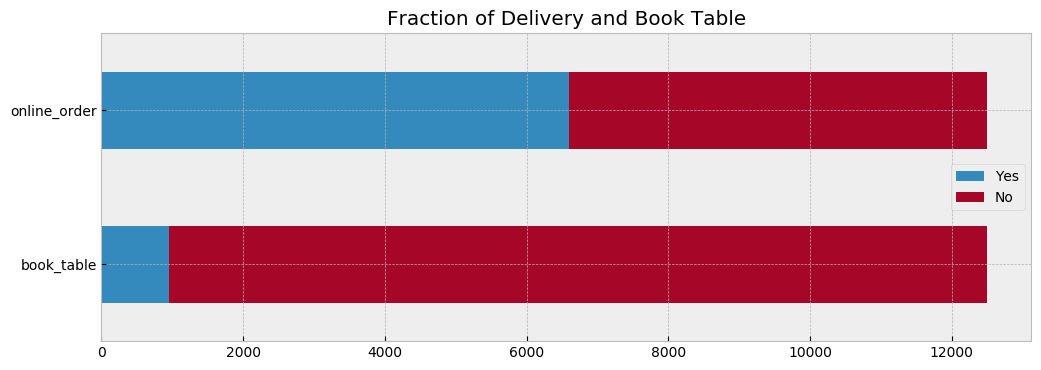

In [25]:
with plt.style.context('bmh', after_reset = True):
    plt.figure(figsize = (12,4))
    ax = plt.subplot(1,1,1)
    tmp = {}
    for col in ['online_order', 'book_table']: 
        tmp[col] = rest_df[col].value_counts()
    tmp = pd.DataFrame.from_dict(tmp, orient = 'index')
    tmp.plot.barh(stacked = True, ax = ax)
    ax.set_title('Fraction of Delivery and Book Table')
    plt.show()


#### Lets take the rating of restaurant and find the average rating for each of the neighborhood

In [26]:
rest_df['rate'] = rest_df['rate'].str.split('/').str[0]

Lets set the rating of new restaurants as NULL

In [27]:
rest_df.loc[rest_df['rate']=="NEW", 'rate'] = np.nan
rest_df.loc[rest_df['rate']=="-", 'rate'] = np.nan

In [28]:
rest_df['rate'] = rest_df['rate'].astype('float')

In [29]:
rest_df.groupby(['location'])['rate'].mean().sort_values()[-50:][:-1]

location
Whitefield               3.598217
Hebbal                   3.600000
Yelahanka                3.600000
Sarjapur Road            3.603984
Vijay Nagar              3.612000
Banashankari             3.625991
Frazer Town              3.631250
Old Airport Road         3.634259
JP Nagar                 3.634677
Mysore Road              3.637500
HSR                      3.638685
New BEL Road             3.642273
Sahakara Nagar           3.645000
Koramangala 1st Block    3.647273
Kammanahalli             3.649206
Langford Town            3.650000
Koramangala 2nd Block    3.650000
HBR Layout               3.664000
Basavanagudi             3.675141
Brigade Road             3.675926
Koramangala 8th Block    3.686667
Kengeri                  3.700000
Central Bangalore        3.700000
Ulsoor                   3.713978
Koramangala              3.716667
Seshadripuram            3.723913
Malleshwaram             3.727228
Koramangala 6th Block    3.727820
Vasanth Nagar            3.730233
Cunni

Clearly Lavelle Road restaurants are rated higher

### Number of restaurants in each Neighborhood

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing

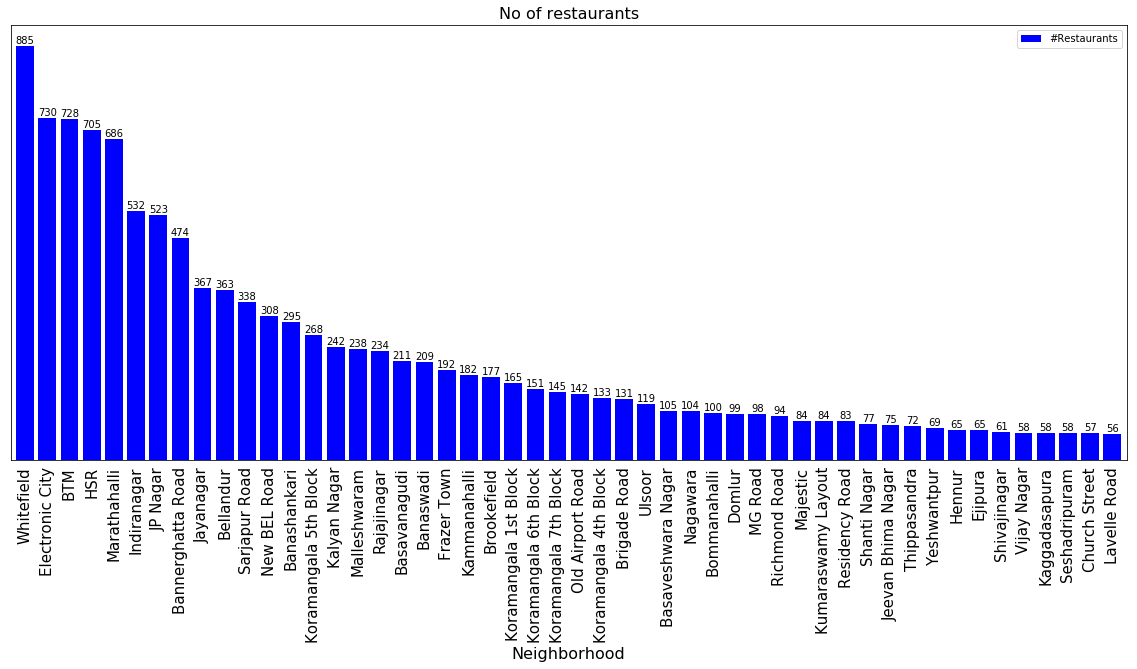

In [30]:
histo = rest_df.groupby('location')['url'].count().sort_values(ascending=False)[:50]
ax = histo.plot(kind='bar', figsize=(20, 8), rot=90, width = 0.8, color=[ 'blue'])
rects = ax.patches
labels = list(histo)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + .05, label,
            ha='center', va='bottom', fontsize=10)
ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on') # remove borders
ax.xaxis.set_tick_params(labelsize=15) # set xticks as 14
ax.legend(fontsize=14) # set legend sie as 14
ax.set_title('No of restaurants', fontsize=16) # set title and add font size as 16
ax.set_xlabel('Neighborhood', fontsize=16)
#ax.grid(False)  # remove grid
ax.set_facecolor("white") # set bg color white
ax.legend(['#Restaurants'])

Whitefield has the highest number of restaurants followed by EC

### Zomato's Presence across Bangalore

In [32]:
labels = list(rest_df.location.value_counts().index)
values = list(rest_df.location.value_counts().values)

fig = {
    "data":[
        {
            "labels" : labels,
            "values" : values,
            "hoverinfo" : 'label+percent',
            "domain": {"x": [0, .9]},
            "hole" : 0.6,
            "type" : "pie",
            "rotation":120,
        },
    ],
    "layout": {
        "title" : "Zomato's Presence in Bangalore",
        "annotations": [
            {
                "font": {"size":20},
                "showarrow": True,
                "text": "Neighborhood",
                "x":0.2,
                "y":0.9,
            },
        ]
    }
}

iplot(fig)

### Lets get the coordinates for each of the neighborhood

In [33]:
location = [x for x in rest_df['location'].unique().tolist() if type(x) == str]
latitude = []
longitude =  []
for i in range(0, len(location)):
    if(type(location[i]) == str):
        ctr=0
        while True:
            try:
                address = location[i] + ', Bengaluru, India'
                geolocator = Nominatim(user_agent="ny_explorer")
                loc = geolocator.geocode(address)
                latitude.append(loc.latitude)
                longitude.append(loc.longitude)
                print('The geograpical coordinate of location are {}, {}.'.format(loc.latitude, loc.longitude))
            except:
                ctr+=1
                if(ctr==7):
                    print(i)
                    latitude.append(address)
                    longitude.append(address)
                    break
                continue
            break

The geograpical coordinate of location are 12.9152208, 77.573598.
The geograpical coordinate of location are 12.9417261, 77.5755021.
The geograpical coordinate of location are 12.9458408, 77.5292117.
The geograpical coordinate of location are 12.9292731, 77.5824229.
The geograpical coordinate of location are 12.9068169, 77.5635247362134.
The geograpical coordinate of location are 12.9274278, 77.5153722.
The geograpical coordinate of location are 23.1895187, 79.913913848308.
The geograpical coordinate of location are 12.9055682, 77.5455438.
The geograpical coordinate of location are 12.2810839, 76.6068597656247.
The geograpical coordinate of location are 12.9791198, 77.5912997.
The geograpical coordinate of location are 12.965718, 77.5762705372058.
The geograpical coordinate of location are 12.9651008, 77.5078635.
The geograpical coordinate of location are 12.9166588, 77.5998415.
The geograpical coordinate of location are 12.91127585, 77.6045654343118.
The geograpical coordinate of loca

In [42]:
rest_df['location_latitude'] = rest_df['location'].map(dict(zip(location, latitude)))
rest_df['location_longitude'] = rest_df['location'].map(dict(zip(location, longitude)))

In [60]:
rest_df.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table  rate  votes                             phone  \
0          Yes        Yes   4.1    775    080 42297555\r\n+91 9743772233   
1          Yes         No   4.1    787                      080 41714161   
2          Yes         No   3.8    918                    +91 9663487993   
3           No         No   3.7     88                    +91 9620009302   
4           No         No   3.8    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type        ...          \
0  Banashankari        Casual Dining        ...           
1  Banashankari        Casual Dining        ...           
2  Banashankari  Cafe, Casual Dining        ...           
3  Banashankari          Quick Bites        ...           
4  Basavanagudi        Casual Dining        ...           

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                       800.0   
1     Chinese, North Indian, Thai                       800.0   
2          Cafe, Mexican, Italian                       800.0   
3      South Indian, North Indian                       300.0   
4        North Indian, Rajasthani                       600.0   

                                        reviews_list menu_item  \
0  [(Rated 4.0, RATED\n  A beautiful place to din...        []   
1  [(Rated 4.0, RATED\n  Had been here for dinner...        []   
2  [(Rated 3.0, RATED\n  Ambience is not that goo...        []   
3  [(Rated 4.0, RATED\n  Great food and proper Ka...        []   
4  [(Rated 4.0, RATED\n  Very good restaurant in ...        []   

  listed_in(type) listed_in(city)  \
0          Buffet    Banashankari   
1          Buffet    Banashankari   
2          Buffet    Banashankari   
3          Buffet    Banashankari   
4          Buffet    Banashankari   

                              liked_food_from_review  \
0  [soya chaap, paratha, papad, roti, butter, fri...   
1  [sweet and spicy, garlic fried rice, egg, pane...   
2  [coconut milk, shakes, egg, pasta, lasagne, ri...   
3  [rice with sambar, rice, pulka, dosa, full mea...   
4  [pav bhaji, smiles, paratha, roti, papdi, milk...   

                                      menus_combined location_latitude  \
0  [pasta,, lunch, buffet,, masala, papad,, panee...           12.9152   
1  [momos,, lunch, buffet,, chocolate, nirvana,, ...           12.9152   
2  [churros,, cannelloni,, minestrone, soup,, hot...           12.9152   
3  [masala, dosa, rice with sambar, rice, pulka, ...           12.9152   
4  [panipuri,, gol, gappe, pav bhaji, smiles, par...           12.9417   

  location_longitude  
0            77.5736  
1            77.5736  
2            77.5736  
3            77.5736  
4            77.5755  

[5 rows x 21 columns]

In [67]:
rest_df.dtypes

url                             object
address                         object
name                            object
online_order                    object
book_table                      object
rate                           float64
votes                            int64
phone                           object
location                        object
rest_type                       object
dish_liked                      object
cuisines                        object
approx_cost(for two people)    float64
reviews_list                    object
menu_item                       object
listed_in(type)                 object
listed_in(city)                 object
liked_food_from_review          object
menus_combined                  object
location_latitude               object
location_longitude              object
dtype: object

In [68]:
dataframe_filtered = rest_df.groupby(['location'])['location_latitude', 'location_longitude'].first()
dataframe_filtered['no_restaurant'] = rest_df.groupby(['location'])['url'].count()

In [69]:
dataframe_filtered.head()

location_latitude location_longitude  no_restaurant
location                                                             
BTM                         12.9113            77.6046            728
Banashankari                12.9152            77.5736            295
Banaswadi                   13.0142            77.6519            209
Bannerghatta Road           12.9167            77.5998            474
Basavanagudi                12.9417            77.5755            211

In [70]:
dataframe_filtered.dtypes

location_latitude     object
location_longitude    object
no_restaurant          int64
dtype: object

In [82]:
dataframe_filtered["location_latitude"] = pd.to_numeric(dataframe_filtered["location_latitude"],errors='coerce')

In [84]:
dataframe_filtered["location_longitude"] = pd.to_numeric(dataframe_filtered["location_longitude"],errors='coerce')

In [85]:
dataframe_filtered.dtypes

location_latitude     float64
location_longitude    float64
no_restaurant           int64
dtype: object

In [92]:
dataframe_filtered[dataframe_filtered['location_latitude'].isnull()]

location_latitude  location_longitude  no_restaurant
location                                                                   
Brookefield                          NaN                 NaN            177
Koramangala 1st Block                NaN                 NaN            165
Rammurthy Nagar                      NaN                 NaN             19
Sankey Road                          NaN                 NaN             13

In [95]:
dataframe_filtered = dataframe_filtered.dropna()

In [96]:
dataframe_filtered.shape

(89, 3)

In [98]:
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
for lat, lng, in zip(dataframe_filtered.location_latitude, dataframe_filtered.location_longitude):
    states.add_child(
        folium.CircleMarker([lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
        )
    )
    i+=1
i=0
for lat, lng, in zip(dataframe_filtered.location_latitude, dataframe_filtered.location_longitude):
    states.add_child(
        folium.features.Marker([lat, lng],popup= dataframe_filtered.index[i],)
    )
    i+=1
# add incidents to map
venues_map.add_child(states)
venues_map

### Plot map by density of restaurants in each neighborhood

In [99]:
bins = pd.IntervalIndex.from_tuples([(0, 100), (101, 200), (201, 300), (301, 400), (401, 500), (501, 600), (601, 700), (701, 800), (801, 900)])
dataframe_filtered['category'] = pd.cut(dataframe_filtered['no_restaurant'], bins)

In [100]:
x = dataframe_filtered.groupby('category').groups.keys()

In [101]:
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
for lat, lng, in zip(dataframe_filtered.location_latitude, dataframe_filtered.location_longitude):
    states.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
        )
    )
    i+=1
colors = ['red', 'blue', 'green', 'purple', 'orange', 'white', 'pink', 'gray', 'black']
j=0
for i in range(0,len(list(x))):
    group = dataframe_filtered.groupby('category').get_group(list(x)[i])
    i=0
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.features.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='cloud')
            )
        )
        i+=1
    j+=1
# add incidents to map
venues_map.add_child(states)

# url = ('https://raw.githubusercontent.com/SECOORA/static_assets/'
#        'master/maps/img/rose.png')
# FloatImage(image_file, bottom=40, left=65).add_to(venues_map)
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Number of restaurants</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>0-100</li>
    <li><span style='background:blue;opacity:0.7;'></span>101-200</li>
    <li><span style='background:green;opacity:0.7;'></span>201-300</li>
    <li><span style='background:purple;opacity:0.7;'></span>301-400</li>
    <li><span style='background:orange;opacity:0.7;'></span>401-500</li>
    <li><span style='background:white;opacity:0.7;'></span>501-600</li>
    <li><span style='background:pink;opacity:0.7;'></span>601-700</li>
    <li><span style='background:gray;opacity:0.7;'></span>701-800</li>
    <li><span style='background:black;opacity:0.7;'></span>801-900</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

venues_map.get_root().add_child(macro)

venues_map


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning:

color argument of Icon should be one of: {'lightgreen', 'darkblue', 'blue', 'lightred', 'purple', 'pink', 'gray', 'beige', 'lightgrayblack', 'green', 'cadetblue', 'darkgreen', 'darkpurple', 'lightblue', 'darkred', 'orange', 'red', 'white'}.



It can be seen clearly that outer cities of Bengaluru has most number of restaurants. But wait is that true ?<br>
Analysing the data we found that central bengaluru is densely populated while there aren't much markers at the outer part of the city.

### Neighborhood by rating

In [102]:
nb_rate_df = rest_df.groupby(['location'])['location_latitude', 'location_longitude'].first()
nb_rate_df['rate'] = rest_df.groupby(['location'])['rate'].mean()
nb_rate_df

location_latitude  \
location                                                           
BTM                                                      12.9113   
Banashankari                                             12.9152   
Banaswadi                                                13.0142   
Bannerghatta Road                                        12.9167   
Basavanagudi                                             12.9417   
Basaveshwara Nagar                                       12.9932   
Bellandur                                                12.9791   
Bommanahalli                                             12.9089   
Brigade Road                                             12.9736   
Brookefield                        Brookefield, Bengaluru, India   
CV Raman Nagar                                           17.2511   
Central Bangalore                                        12.9791   
Church Street                                            12.9751   
City Market                                              12.9657   
Commercial Street                                        12.9822   
Cunningham Road                                          12.9869   
Domlur                                                   12.9625   
East Bangalore                                           12.9791   
Ejipura                                                  12.9452   
Electronic City                                          12.9791   
Frazer Town                                              12.9968   
HBR Layout                                               13.0359   
HSR                                                      12.9121   
Hebbal                                                   13.0382   
Hennur                                                   13.0258   
Hosur Road                                               12.9296   
ITPL Main Road, Whitefield                               12.9676   
Indiranagar                                              12.9733   
Infantry Road                                            12.9832   
JP Nagar                                                 12.2811   
...                                                          ...   
Old Madras Road                                          13.0076   
Peenya                                                   13.0329   
RT Nagar                                                 13.0227   
Race Course Road                                         1.30643   
Rajajinagar                                              12.9882   
Rajarajeshwari Nagar                                     12.9274   
Rammurthy Nagar                Rammurthy Nagar, Bengaluru, India   
Residency Road                                           13.0553   
Richmond Road                                            12.9667   
Sadashiv Nagar                                            18.955   
Sahakara Nagar                                           13.0621   
Sanjay Nagar                                             12.9579   
Sankey Road                        Sankey Road, Bengaluru, India   
Sarjapur Road                                            12.9245   
Seshadripuram                                            12.9932   
Shanti Nagar                                             12.9576   
Shivajinagar                                             12.9864   
South Bangalore                                          12.9791   
St. Marks Road                                           12.9779   
Thippasandra                                             12.9739   
Ulsoor                                                   12.9779   
Uttarahalli                                              12.9056   
Varthur Main Road, Whitefield                            12.9415   
Vasanth Nagar                                            12.9887   
Vijay Nagar                                              23.1895   
West Bangalore                                           12.9791   
Whitefield                         

In [103]:
bins = pd.IntervalIndex.from_tuples([(3.2, 3.3), (3.31, 3.4), (3.41, 3.5), (3.51, 3.6), (3.61, 3.7), (3.71, 3.8), (3.81, 3.9), (3.91, 4.0), (4.0, 4.1)])
nb_rate_df['category'] = pd.cut(nb_rate_df['rate'], bins)

In [104]:
x = nb_rate_df.groupby('category').groups.keys()

In [106]:
nb_rate_df.head()

location_latitude location_longitude      rate     category
location                                                                     
BTM                         12.9113            77.6046  3.556950  (3.51, 3.6]
Banashankari                12.9152            77.5736  3.625991  (3.61, 3.7]
Banaswadi                   13.0142            77.6519  3.477397  (3.41, 3.5]
Bannerghatta Road           12.9167            77.5998  3.476000  (3.41, 3.5]
Basavanagudi                12.9417            77.5755  3.675141  (3.61, 3.7]

In [107]:
nb_rate_df.dtypes

location_latitude       object
location_longitude      object
rate                   float64
category              category
dtype: object

In [108]:
nb_rate_df["location_latitude"] = pd.to_numeric(nb_rate_df["location_latitude"],errors='coerce')

In [109]:
nb_rate_df["location_longitude"] = pd.to_numeric(nb_rate_df["location_longitude"],errors='coerce')

In [110]:
nb_rate_df[nb_rate_df['location_latitude'].isnull()]

location_latitude  location_longitude      rate  \
location                                                                 
Brookefield                          NaN                 NaN  3.570000   
Koramangala 1st Block                NaN                 NaN  3.647273   
Rammurthy Nagar                      NaN                 NaN  3.353333   
Sankey Road                          NaN                 NaN  4.041667   

                          category  
location                            
Brookefield            (3.51, 3.6]  
Koramangala 1st Block  (3.61, 3.7]  
Rammurthy Nagar        (3.31, 3.4]  
Sankey Road             (4.0, 4.1]

In [111]:
nb_rate_df = nb_rate_df.dropna()

In [112]:
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
for lat, lng, in zip(nb_rate_df.location_latitude, nb_rate_df.location_longitude):
    states.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
        )
    )
    i+=1
colors = ['red', 'blue', 'green', 'purple', 'orange', 'white', 'pink', 'gray', 'black']
j=0
for i in range(0,len(list(x))):
    group = nb_rate_df.groupby('category').get_group(list(x)[i])
    i=0
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.features.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='cloud')
            )
        )
        i+=1
    j+=1
# add incidents to map
venues_map.add_child(states)

# url = ('https://raw.githubusercontent.com/SECOORA/static_assets/'
#        'master/maps/img/rose.png')
# FloatImage(image_file, bottom=40, left=65).add_to(venues_map)
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Number of restaurants</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>3.2-3.3</li>
    <li><span style='background:blue;opacity:0.7;'></span>3.31-3.4</li>
    <li><span style='background:green;opacity:0.7;'></span>3.41-3.5</li>
    <li><span style='background:purple;opacity:0.7;'></span>3.51-3.6</li>
    <li><span style='background:orange;opacity:0.7;'></span>3.61-3.7</li>
    <li><span style='background:white;opacity:0.7;'></span>3.71-3.8</li>
    <li><span style='background:pink;opacity:0.7;'></span>3.81-3.9</li>
    <li><span style='background:gray;opacity:0.7;'></span>3.91-4.0</li>
    <li><span style='background:black;opacity:0.7;'></span>4.04.1</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

venues_map.get_root().add_child(macro)

venues_map


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning:

color argument of Icon should be one of: {'lightgreen', 'darkblue', 'blue', 'lightred', 'purple', 'pink', 'gray', 'beige', 'lightgrayblack', 'green', 'cadetblue', 'darkgreen', 'darkpurple', 'lightblue', 'darkred', 'orange', 'red', 'white'}.



Most of the top rated restaurants are clustered around Central Bengaluru

### Neighborhood by cost of food

#### Lets see the cost of food in each neighborhood of Bengaluru

In [114]:
rest_df.head()

url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table  rate  votes                             phone  \
0          Yes        Yes   4.1    775    080 42297555\r\n+91 9743772233   
1          Yes         No   4.1    787                      080 41714161   
2          Yes         No   3.8    918                    +91 9663487993   
3           No         No   3.7     88                    +91 9620009302   
4           No         No   3.8    166  +91 8026612447\r\n+91 9901210005   

       location            rest_type        ...          \
0  Banashankari        Casual Dining        ...           
1  Banashankari        Casual Dining        ...           
2  Banashankari  Cafe, Casual Dining        ...           
3  Banashankari          Quick Bites        ...           
4  Basavanagudi        Casual Dining        ...           

                         cuisines approx_cost(for two people)  \
0  North Indian, Mughlai, Chinese                       800.0   
1     Chinese, North Indian, Thai                       800.0   
2          Cafe, Mexican, Italian                       800.0   
3      South Indian, North Indian                       300.0   
4        North Indian, Rajasthani                       600.0   

                                        reviews_list menu_item  \
0  [(Rated 4.0, RATED\n  A beautiful place to din...        []   
1  [(Rated 4.0, RATED\n  Had been here for dinner...        []   
2  [(Rated 3.0, RATED\n  Ambience is not that goo...        []   
3  [(Rated 4.0, RATED\n  Great food and proper Ka...        []   
4  [(Rated 4.0, RATED\n  Very good restaurant in ...        []   

  listed_in(type) listed_in(city)  \
0          Buffet    Banashankari   
1          Buffet    Banashankari   
2          Buffet    Banashankari   
3          Buffet    Banashankari   
4          Buffet    Banashankari   

                              liked_food_from_review  \
0  [soya chaap, paratha, papad, roti, butter, fri...   
1  [sweet and spicy, garlic fried rice, egg, pane...   
2  [coconut milk, shakes, egg, pasta, lasagne, ri...   
3  [rice with sambar, rice, pulka, dosa, full mea...   
4  [pav bhaji, smiles, paratha, roti, papdi, milk...   

                                      menus_combined location_latitude  \
0  [pasta,, lunch, buffet,, masala, papad,, panee...           12.9152   
1  [momos,, lunch, buffet,, chocolate, nirvana,, ...           12.9152   
2  [churros,, cannelloni,, minestrone, soup,, hot...           12.9152   
3  [masala, dosa, rice with sambar, rice, pulka, ...           12.9152   
4  [panipuri,, gol, gappe, pav bhaji, smiles, par...           12.9417   

  location_longitude  
0            77.5736  
1            77.5736  
2            77.5736  
3            77.5736  
4            77.5755  

[5 rows x 21 columns]

In [115]:
rest_df.dtypes

url                             object
address                         object
name                            object
online_order                    object
book_table                      object
rate                           float64
votes                            int64
phone                           object
location                        object
rest_type                       object
dish_liked                      object
cuisines                        object
approx_cost(for two people)    float64
reviews_list                    object
menu_item                       object
listed_in(type)                 object
listed_in(city)                 object
liked_food_from_review          object
menus_combined                  object
location_latitude               object
location_longitude              object
dtype: object

In [113]:
rest_df['approx_cost(for two people)'] = rest_df['approx_cost(for two people)'].str.replace(",","").astype(float)

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

But before that lets remove all those places that has less than 50 restaurants

In [116]:
above_50 = rest_df.groupby('location')['url'].count()[rest_df.groupby('location')['url'].count() >= 50].index

##### Does this mean higher the cost of food means posche area

In [117]:
rest_df[rest_df['location'].isin(above_50)].groupby('location')['approx_cost(for two people)'].mean().sort_values(ascending= False)

location
Lavelle Road             1323.214286
MG Road                  1056.122449
Residency Road            936.144578
Church Street             762.280702
Seshadripuram             733.620690
Richmond Road             730.319149
Vasanth Nagar             719.444444
Ulsoor                    686.016949
Old Airport Road          637.304965
Indiranagar               600.587121
Brigade Road              594.122137
Koramangala 4th Block     593.609023
Koramangala 5th Block     578.113208
Whitefield                558.227273
Domlur                    553.020833
Koramangala 6th Block     548.666667
Kalyan Nagar              525.495868
Koramangala 7th Block     525.347222
Sarjapur Road             489.104478
Marathahalli              485.212299
Malleshwaram              484.117647
Bellandur                 481.763085
Electronic City           461.714678
JP Nagar                  457.777778
Jayanagar                 444.277929
HSR                       440.655271
New BEL Road              435

Cost of living in Lavelle Road is also quite high, even I can't afford the restaurants in lavelle road

<font size=2px><b> Lets see it on the map</b></font>

In [118]:
nb_cost_df = rest_df.groupby(['location'])['location_latitude', 'location_longitude'].first()
nb_cost_df['cost'] = rest_df.groupby(['location'])['approx_cost(for two people)'].mean()
nb_cost_df

location_latitude  \
location                                                           
BTM                                                      12.9113   
Banashankari                                             12.9152   
Banaswadi                                                13.0142   
Bannerghatta Road                                        12.9167   
Basavanagudi                                             12.9417   
Basaveshwara Nagar                                       12.9932   
Bellandur                                                12.9791   
Bommanahalli                                             12.9089   
Brigade Road                                             12.9736   
Brookefield                        Brookefield, Bengaluru, India   
CV Raman Nagar                                           17.2511   
Central Bangalore                                        12.9791   
Church Street                                            12.9751   
City Market                                              12.9657   
Commercial Street                                        12.9822   
Cunningham Road                                          12.9869   
Domlur                                                   12.9625   
East Bangalore                                           12.9791   
Ejipura                                                  12.9452   
Electronic City                                          12.9791   
Frazer Town                                              12.9968   
HBR Layout                                               13.0359   
HSR                                                      12.9121   
Hebbal                                                   13.0382   
Hennur                                                   13.0258   
Hosur Road                                               12.9296   
ITPL Main Road, Whitefield                               12.9676   
Indiranagar                                              12.9733   
Infantry Road                                            12.9832   
JP Nagar                                                 12.2811   
...                                                          ...   
Old Madras Road                                          13.0076   
Peenya                                                   13.0329   
RT Nagar                                                 13.0227   
Race Course Road                                         1.30643   
Rajajinagar                                              12.9882   
Rajarajeshwari Nagar                                     12.9274   
Rammurthy Nagar                Rammurthy Nagar, Bengaluru, India   
Residency Road                                           13.0553   
Richmond Road                                            12.9667   
Sadashiv Nagar                                            18.955   
Sahakara Nagar                                           13.0621   
Sanjay Nagar                                             12.9579   
Sankey Road                        Sankey Road, Bengaluru, India   
Sarjapur Road                                            12.9245   
Seshadripuram                                            12.9932   
Shanti Nagar                                             12.9576   
Shivajinagar                                             12.9864   
South Bangalore                                          12.9791   
St. Marks Road                                           12.9779   
Thippasandra                                             12.9739   
Ulsoor                                                   12.9779   
Uttarahalli                                              12.9056   
Varthur Main Road, Whitefield                            12.9415   
Vasanth Nagar                                            12.9887   
Vijay Nagar                                              23.1895   
West Bangalore                                           12.9791   
Whitefield                         

In [119]:
bins = pd.IntervalIndex.from_tuples([(200, 600), (601, 1000), (1001, 1400), (2201, 2600)])
nb_cost_df['category'] = pd.cut(nb_cost_df['cost'], bins)

In [122]:
nb_cost_df["location_latitude"] = pd.to_numeric(nb_cost_df["location_latitude"],errors='coerce')

In [123]:
nb_cost_df["location_longitude"] = pd.to_numeric(nb_cost_df["location_longitude"],errors='coerce')

In [125]:
nb_cost_df = nb_cost_df.dropna()

In [126]:
x = nb_cost_df.groupby('category').groups.keys()
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
for lat, lng, in zip(nb_cost_df.location_latitude, nb_cost_df.location_longitude):
    states.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
        )
    )
    i+=1
colors = ['red', 'blue', 'green', 'purple', 'orange', 'black']
j=0
for i in range(0,len(list(x))):
    group = nb_cost_df.groupby('category').get_group(list(x)[i])
    i=0
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='cloud')
            )
        )
        i+=1
    j+=1
# add incidents to map
venues_map.add_child(states)

# url = ('https://raw.githubusercontent.com/SECOORA/static_assets/'
#        'master/maps/img/rose.png')
# FloatImage(image_file, bottom=40, left=65).add_to(venues_map)
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Cost</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>200-600</li>
    <li><span style='background:blue;opacity:0.7;'></span>601-1000</li>
    <li><span style='background:green;opacity:0.7;'></span>1001-1400</li>
    <li><span style='background:purple;opacity:0.7;'></span>2201-2600</li>
  </ul>
</div>
</div>
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

venues_map.get_root().add_child(macro)

venues_map


KeyError: Interval(2201, 2600, closed='right')

It can be seen that all the costly restaurants are located in Central Bangalore, Lavelle Road, MG Road, Race Course Road.

Yes it can therefore be said from higher cost of food means posche area comparing it to the ground truth of Bangalore

### Grouping the neighborhood by the type of restaurant 

In [127]:
types = set()
def func(x):
    if(type(x) == list):
        print(x)
        for y in x:
            types.add(y.strip())
_ = rest_df['rest_type'].str.split(',').apply(func)

['Casual Dining']
['Casual Dining']
['Cafe', ' Casual Dining']
['Quick Bites']
['Casual Dining']
['Casual Dining']
['Casual Dining']
['Casual Dining', ' Cafe']
['Cafe']
['Cafe']
['Cafe']
['Cafe']
['Cafe']
['Cafe']
['Cafe']
['Cafe']
['Cafe']
['Cafe']
['Cafe']
['Cafe']
['Cafe']
['Cafe']
['Quick Bites', ' Cafe']
['Cafe']
['Cafe']
['Cafe', ' Quick Bites']
['Cafe']
['Cafe']
['Casual Dining', ' Cafe']
['Cafe']
['Quick Bites']
['Delivery']
['Delivery']
['Quick Bites']
['Delivery']
['Quick Bites']
['Casual Dining']
['Casual Dining']
['Quick Bites']
['Quick Bites']
['Mess']
['Quick Bites']
['Quick Bites']
['Delivery']
['Quick Bites']
['Casual Dining']
['Casual Dining']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Dessert Parlor']
['Casual Dining']
['Quick Bites']
['Delivery']
['Quick Bites']
['Casual Dining']
['Quick Bites']
['Dessert Parlor']
['Casual Dining']
['Casual Dining']
['Quick Bites']
['Casual Dining']
['Bakery', ' Dessert Parlor']
['Quick Bites']
['Quick Bites']
['Pub']
['Bakery

['Casual Dining']
['Casual Dining']
['Lounge', ' Casual Dining']
['Casual Dining', ' Bar']
['Casual Dining']
['Casual Dining']
['Casual Dining']
['Casual Dining']
['Bar', ' Casual Dining']
['Casual Dining']
['Casual Dining']
['Pub']
['Casual Dining']
['Casual Dining']
['Bar']
['Lounge']
['Cafe', ' Quick Bites']
['Cafe']
['Takeaway']
['Cafe']
['Bakery', ' Quick Bites']
['Cafe']
['Cafe', ' Food Court']
['Cafe']
['Beverage Shop', ' Cafe']
['Cafe']
['Cafe']
['Cafe', ' Dessert Parlor']
['Cafe']
['Cafe']
['Cafe', ' Bakery']
['Cafe']
['Cafe']
['Cafe']
['Quick Bites']
['Dessert Parlor', ' Cafe']
['Cafe']
['Cafe']
['Cafe']
['Cafe']
['Quick Bites']
['Cafe']
['Quick Bites']
['Delivery']
['Quick Bites']
['Casual Dining']
['Takeaway', ' Delivery']
['Delivery']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Delivery']
['Delivery']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Mess']
['Quick Bites']
['Dessert Parlor']
['Quick Bite

['Delivery']
['Cafe']
['Quick Bites']
['Quick Bites', ' Bakery']
['Delivery']
['Takeaway', ' Delivery']
['Casual Dining']
['Quick Bites']
['Quick Bites']
['Casual Dining']
['Casual Dining']
['Quick Bites']
['Bakery']
['Quick Bites']
['Delivery']
['Takeaway', ' Delivery']
['Casual Dining']
['Dessert Parlor']
['Beverage Shop']
['Quick Bites']
['Quick Bites']
['Dessert Parlor', ' Bakery']
['Cafe', ' Bakery']
['Delivery']
['Quick Bites']
['Cafe']
['Casual Dining']
['Dessert Parlor']
['Casual Dining', ' Bar']
['Cafe']
['Cafe']
['Casual Dining']
['Quick Bites']
['Beverage Shop']
['Quick Bites']
['Quick Bites']
['Dessert Parlor']
['Quick Bites']
['Quick Bites']
['Casual Dining']
['Bar', ' Quick Bites']
['Quick Bites']
['Beverage Shop']
['Casual Dining']
['Casual Dining']
['Quick Bites']
['Cafe']
['Quick Bites']
['Casual Dining']
['Casual Dining']
['Casual Dining']
['Dessert Parlor']
['Casual Dining']
['Quick Bites']
['Quick Bites']
['Casual Dining', ' Bar']
['Quick Bites']
['Quick Bites']
['C

['Quick Bites']
['Quick Bites']
['Bakery']
['Quick Bites']
['Casual Dining']
['Casual Dining']
['Casual Dining']
['Quick Bites']
['Quick Bites']
['Takeaway', ' Delivery']
['Quick Bites']
['Beverage Shop', ' Quick Bites']
['Delivery']
['Quick Bites']
['Takeaway', ' Delivery']
['Beverage Shop']
['Delivery']
['Dessert Parlor']
['Casual Dining']
['Quick Bites']
['Takeaway', ' Delivery']
['Casual Dining']
['Quick Bites']
['Casual Dining']
['Casual Dining']
['Cafe']
['Delivery']
['Quick Bites']
['Casual Dining']
['Quick Bites']
['Cafe']
['Beverage Shop']
['Casual Dining']
['Casual Dining']
['Quick Bites']
['Takeaway', ' Delivery']
['Quick Bites']
['Beverage Shop']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Takeaway', ' Delivery']
['Takeaway', ' Delivery']
['Quick Bites']
['Quick Bites']
['Takeaway', ' Delivery']
['Dessert Parlor']
['Quick Bites']
['Delivery']
['Casual Dining']
['Quick Bites']
['Beverage Shop']
['Quick Bites']
['Bakery', 

['Quick Bites']
['Quick Bites']
['Sweet Shop', ' Quick Bites']
['Quick Bites']
['Casual Dining']
['Quick Bites']
['Casual Dining']
['Quick Bites']
['Kiosk']
['Quick Bites']
['Delivery']
['Casual Dining']
['Sweet Shop']
['Quick Bites']
['Quick Bites']
['Casual Dining']
['Casual Dining']
['Quick Bites']
['Casual Dining']
['Delivery']
['Quick Bites', ' Beverage Shop']
['Casual Dining']
['Quick Bites']
['Quick Bites']
['Casual Dining']
['Bakery']
['Quick Bites']
['Quick Bites']
['Casual Dining']
['Delivery']
['Quick Bites']
['Takeaway', ' Delivery']
['Takeaway', ' Delivery']
['Bakery', ' Cafe']
['Casual Dining']
['Beverage Shop']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Casual Dining']
['Quick Bites']
['Delivery']
['Casual Dining']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Casual Dining']
['Quick Bites']
['Quick Bites']
['Casual Dining']
['Cafe']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Casual Dining']
['Casual Dining']
['Cafe']
['Casual Dining']
[

['Takeaway', ' Delivery']
['Bakery', ' Quick Bites']
['Dessert Parlor']
['Quick Bites']
['Quick Bites']
['Delivery']
['Bakery']
['Quick Bites']
['Casual Dining']
['Casual Dining', ' Bar']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Casual Dining']
['Takeaway', ' Delivery']
['Takeaway', ' Delivery']
['Quick Bites']
['Mess']
['Takeaway']
['Takeaway', ' Delivery']
['Beverage Shop']
['Dessert Parlor', ' Quick Bites']
['Dessert Parlor']
['Dessert Parlor']
['Casual Dining']
['Delivery']
['Dessert Parlor']
['Bakery']
['Quick Bites']
['Food Court']
['Casual Dining']
['Quick Bites']
['Quick Bites']
['Bakery']
['Delivery']
['Casual Dining']
['Casual Dining']
['Takeaway', ' Delivery']
['Takeaway', ' Delivery']
['Takeaway', ' Delivery']
['Casual Dining']
['Delivery']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Beverage Shop']
['Delivery']
['Dessert Parlor']
['Dessert Parlor']
['Dessert Parlor']
['Quick Bites']
['Sweet Shop']
['Sweet Shop', ' Quick Bites']
['Sweet Shop']

['Casual Dining']
['Fine Dining']
['Lounge']
['Casual Dining']
['Casual Dining']
['Bar']
['Bar', ' Casual Dining']
['Beverage Shop', ' Quick Bites']
['Casual Dining']
['Quick Bites']
['Cafe']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Food Court']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Food Court']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Food Court']
['Quick Bites']
['Quick Bites']
['Food Court']
['Quick Bites']
['Quick Bites']
['Food Court']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Beverage Shop']
['Quick Bites']
['Food Court', ' Quick Bites']
['Quick Bites']
['Fine Dining']
['Bar', ' Lounge']
['Club']
['Fine Dining']
['Lounge']
['Casual Dining']
['Casual Dining']
[

['Quick Bites']
['Quick Bites']
['Quick Bites']
['Sweet Shop']
['Quick Bites']
['Quick Bites']
['Bakery']
['Dessert Parlor']
['Quick Bites']
['Dessert Parlor']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Bakery']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Bakery']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Sweet Shop']
['Casual Dining']
['Quick Bites']
['Quick Bites']
['Casual Dining']
['Casual Dining']
['Quick Bites']
['Food Truck']
['Quick Bites']
['Casual Dining']
['Quick Bites']
['Quick Bites', ' Beverage Shop']
['Quick Bites']
['Takeaway', ' Delivery']
['Takeaway', ' Delivery']
['Food Truck']
['Dessert Parlor']
['Sweet Shop']
['Delivery']
['Casual Dining']
['Casual Dining']
['Dessert Parlor']
['Sweet Shop', ' Quick Bites']
['Quick Bites']
['Quick Bites']
['Delivery']
['Quick Bites']
['Delivery']
['Quick Bites']
['Quick Bites']
['Quick Bites']
['Delivery']
['Quick Bites']
['Casual Dining']
['Bakery', ' Dessert Parl

In [128]:
column_names = list(types)
# instantiate the dataframe
neighborhood = pd.DataFrame(columns=column_names)
neighborhood

Empty DataFrame
Columns: [Bakery, Kiosk, Pub, Fine Dining, Confectionery, Club, Pop Up, Lounge, Beverage Shop, Cafe, Dessert Parlor, Irani Cafee, Casual Dining, Dhaba, Mess, Bhojanalya, Takeaway, Meat Shop, Food Court, Quick Bites, Microbrewery, Sweet Shop, Bar, Delivery, Food Truck]
Index: []

[0 rows x 25 columns]

In [129]:
neighborhood['neighborhood'] = rest_df.groupby('location').groups.keys()
neighborhood = neighborhood.set_index('neighborhood').fillna(0)
neighborhood

Bakery  Kiosk  Pub  Fine Dining  Confectionery  \
neighborhood                                                                    
BTM                                 0      0    0            0              0   
Banashankari                        0      0    0            0              0   
Banaswadi                           0      0    0            0              0   
Bannerghatta Road                   0      0    0            0              0   
Basavanagudi                        0      0    0            0              0   
Basaveshwara Nagar                  0      0    0            0              0   
Bellandur                           0      0    0            0              0   
Bommanahalli                        0      0    0            0              0   
Brigade Road                        0      0    0            0              0   
Brookefield                         0      0    0            0              0   
CV Raman Nagar                      0      0    0            0              0   
Central Bangalore                   0      0    0            0              0   
Church Street                       0      0    0            0              0   
City Market                         0      0    0            0              0   
Commercial Street                   0      0    0            0              0   
Cunningham Road                     0      0    0            0              0   
Domlur                              0      0    0            0              0   
East Bangalore                      0      0    0            0              0   
Ejipura                             0      0    0            0              0   
Electronic City                     0      0    0            0              0   
Frazer Town                         0      0    0            0              0   
HBR Layout                          0      0    0            0              0   
HSR                                 0      0    0            0              0   
Hebbal                              0      0    0            0              0   
Hennur                              0      0    0            0              0   
Hosur Road                          0      0    0            0              0   
ITPL Main Road, Whitefield          0      0    0            0              0   
Indiranagar                         0      0    0            0              0   
Infantry Road                       0      0    0            0              0   
JP Nagar                            0      0    0            0              0   
...                               ...    ...  ...          ...            ...   
Old Madras Road                     0      0    0            0              0   
Peenya                              0      0    0            0              0   
RT Nagar                            0      0    0            0              0   
Race Course Road                    0      0    0            0              0   
Rajajinagar                         0      0    0            0              0   
Rajarajeshwari Nagar                0      0    0            0              0   
Rammurthy Nagar                     0      0    0            0              0   
Residency Road                      0      0    0            0              0   
Richmond Road                       0      0    0            0              0   
Sadashiv Nagar                      0      0    0            0              0   
Sahakara Nagar                      0      0    0            0              0   
Sanjay Nagar                        0      0    0            0              0   
Sankey Road                         0      0    0            0              0   
Sarjapur Road                       0      0    0            0              0   
Seshadripuram                       0      0    0            0              0   
Shanti Nagar                        0      0    0            0              0   
Shivajinagar                        0      0    0            0

In [130]:
i=0
for i in range(0,len(rest_df)):
    for x in types:
        if type(rest_df.loc[i, 'rest_type']) == str and x in rest_df.loc[i, 'rest_type']:
            neighborhood.loc[rest_df.loc[i, 'location'], x] = neighborhood.loc[rest_df.loc[i, 'location'], x]+1

In [131]:
# Koramangala is divided into different block, lets combine them all
koramangala = ['Koramangala', 'Koramangala 1st Block', 'Koramangala 2nd Block', 'Koramangala 3rd Block', 'Koramangala 4th Block', 
'Koramangala 5th Block', 'Koramangala 6th Block', 'Koramangala 7th Block', 'Koramangala 8th Block']
koramangala_dict = dict(neighborhood.loc[koramangala].sum())
neighborhood = neighborhood.drop(koramangala)
neighborhood.loc['Koramangala'] = koramangala_dict

In [132]:
neighborhood

Bakery  Kiosk  Pub  Fine Dining  Confectionery  \
neighborhood                                                                    
BTM                                17      2    1            0              0   
Banashankari                        9      0    1            0              1   
Banaswadi                           8      2    1            0              1   
Bannerghatta Road                  19      4    1            0              1   
Basavanagudi                       14      1    1            0              0   
Basaveshwara Nagar                  4      0    1            0              0   
Bellandur                          19      5    2            0              0   
Bommanahalli                        4      0    0            0              0   
Brigade Road                        5      4    5            0              0   
Brookefield                         9      0    2            1              0   
CV Raman Nagar                      0      1    0            0              0   
Central Bangalore                   0      0    0            0              0   
Church Street                       0      0    2            0              0   
City Market                         1      0    0            0              0   
Commercial Street                   3      0    0            0              0   
Cunningham Road                     2      0    1            1              0   
Domlur                              9      1    1            2              0   
East Bangalore                      1      0    0            0              0   
Ejipura                             0      0    0            0              0   
Electronic City                    27      1    4            5              0   
Frazer Town                        15      1    2            0              0   
HBR Layout                          4      0    1            0              0   
HSR                                28      2    2            0              2   
Hebbal                              1      0    0            0              0   
Hennur                              5      1    0            0              0   
Hosur Road                          0      0    0            0              0   
ITPL Main Road, Whitefield          3      0    0            0              0   
Indiranagar                        17      2   11            1              0   
Infantry Road                       0      0    0            0              0   
JP Nagar                           20      3    5            1              0   
...                               ...    ...  ...          ...            ...   
Peenya                              0      0    0            0              0   
RT Nagar                            1      1    0            0              0   
Race Course Road                    0      0    0            4              0   
Rajajinagar                        10      1    0            1              1   
Rajarajeshwari Nagar                0      0    0            0              0   
Rammurthy Nagar                     0      0    0            0              0   
Residency Road                      0      0    2            6              1   
Richmond Road                       6      0    0            6              0   
Sadashiv Nagar                      2      0    0            0              0   
Sahakara Nagar                      0      0    0            0              0   
Sanjay Nagar                        2      1    0            0              0   
Sankey Road                         0      0    0            7              0   
Sarjapur Road                      19      1    5            1              0   
Seshadripuram                       2      0    1            3              0   
Shanti Nagar                        5      0    1            0              0   
Shivajinagar                        2      0    0            0              0   
South Bangalore                     0      0    0            0

#### Swarm plot

In [133]:
dfs = neighborhood.reset_index().melt('neighborhood', var_name='cols',  value_name='vals')

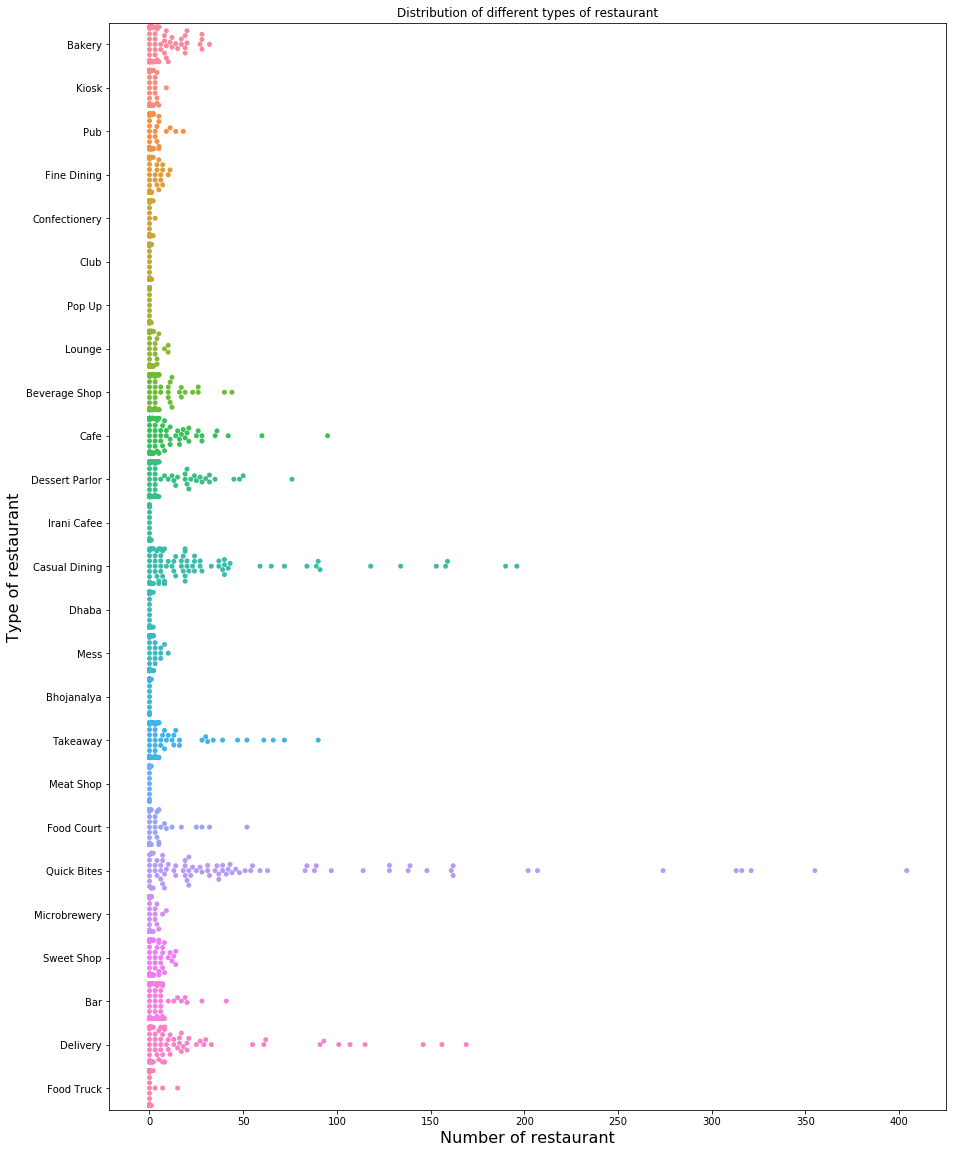

In [134]:
plt.figure(figsize=(15,20))
ax = sns.swarmplot(x="vals", y="cols", data=dfs)
ax.set_xlabel('Number of restaurant', fontsize=16)
ax.set_ylabel('Type of restaurant', fontsize=16)
ax.set_title('Distribution of different types of restaurant')
plt.savefig("swarm.png")

It can be seen that there are more number of Quick Bites restaurants followed by Delivery restaurant which was Quite obvious to us.

### Grouping the neighborhood by the cuisines
Is there any neighborhood that is more famous for its cuisines

In [135]:
types = set()
def func(x):
    if(type(x) == list):
        for y in x:
            types.add(y.strip())
_ = rest_df['cuisines'].str.split(',').apply(func)

In [136]:
column_names = list(types)
# instantiate the dataframe
neighborhood_cns = pd.DataFrame(columns=column_names)
neighborhood_cns

Empty DataFrame
Columns: [Thai, Kebab, Grill, Salad, Bubble Tea, Street Food, Indonesian, British, Japanese, Afghani, African, Indian, Vietnamese, Steak, Iranian, Tea, Finger Food, Modern Indian, North Indian, Middle Eastern, Bohri, Tamil, Biryani, Gujarati, Cantonese, Mexican, Naga, Mughlai, Kerala, Maharashtrian, Kashmiri, Mangalorean, Oriya, Australian, Mithai, Rajasthani, Goan, Asian, Awadhi, Pizza, Coffee, Lucknowi, Sushi, Pan Asian, Russian, Roast Chicken, BBQ, South American, Parsi, Singaporean, Paan, Andhra, Sri Lankan, Juices, Lebanese, Desserts, Chinese, Bihari, Drinks Only, Hyderabadi, Sindhi, Vegan, Belgian, Seafood, Burmese, North Eastern, German, Burger, Korean, Nepalese, Hot dogs, Spanish, Bar Food, Arabian, Jewish, French, Tibetan, Wraps, European, Healthy Food, Chettinad, Bakery, Assamese, Raw Meats, American, Tex-Mex, Afghan, Fast Food, Cafe, Mediterranean, Turkish, Mongolian, Beverages, Sandwich, Charcoal Chicken, Konkan, Greek, Italian, Rolls, Continental, ...]
Index: []

[0 rows x 107 columns]

In [137]:
neighborhood_cns['neighborhood'] = rest_df.groupby('location').groups.keys()
neighborhood_cns = neighborhood_cns.set_index('neighborhood').fillna(0)
neighborhood_cns

Thai  Kebab  Grill  Salad  Bubble Tea  \
neighborhood                                                           
BTM                               0      0      0      0           0   
Banashankari                      0      0      0      0           0   
Banaswadi                         0      0      0      0           0   
Bannerghatta Road                 0      0      0      0           0   
Basavanagudi                      0      0      0      0           0   
Basaveshwara Nagar                0      0      0      0           0   
Bellandur                         0      0      0      0           0   
Bommanahalli                      0      0      0      0           0   
Brigade Road                      0      0      0      0           0   
Brookefield                       0      0      0      0           0   
CV Raman Nagar                    0      0      0      0           0   
Central Bangalore                 0      0      0      0           0   
Church Street                     0      0      0      0           0   
City Market                       0      0      0      0           0   
Commercial Street                 0      0      0      0           0   
Cunningham Road                   0      0      0      0           0   
Domlur                            0      0      0      0           0   
East Bangalore                    0      0      0      0           0   
Ejipura                           0      0      0      0           0   
Electronic City                   0      0      0      0           0   
Frazer Town                       0      0      0      0           0   
HBR Layout                        0      0      0      0           0   
HSR                               0      0      0      0           0   
Hebbal                            0      0      0      0           0   
Hennur                            0      0      0      0           0   
Hosur Road                        0      0      0      0           0   
ITPL Main Road, Whitefield        0      0      0      0           0   
Indiranagar                       0      0      0      0           0   
Infantry Road                     0      0      0      0           0   
JP Nagar                          0      0      0      0           0   
...                             ...    ...    ...    ...         ...   
Old Madras Road                   0      0      0      0           0   
Peenya                            0      0      0      0           0   
RT Nagar                          0      0      0      0           0   
Race Course Road                  0      0      0      0           0   
Rajajinagar                       0      0      0      0           0   
Rajarajeshwari Nagar              0      0      0      0           0   
Rammurthy Nagar                   0      0      0      0           0   
Residency Road                    0      0      0      0           0   
Richmond Road                     0      0      0      0           0   
Sadashiv Nagar                    0      0      0      0           0   
Sahakara Nagar                    0      0      0      0           0   
Sanjay Nagar                      0      0      0      0           0   
Sankey Road                       0      0      0      0           0   
Sarjapur Road                     0      0      0      0           0   
Seshadripuram                     0      0      0      0           0   
Shanti Nagar                      0      0      0      0           0   
Shivajinagar                      0      0      0      0           0   
South Bangalore                   0      0      0      0           0   
St. Marks Road                    0      0      0      0           0   
Thippasandra                      0      0      0      0           0   
Ulsoor                            0      0      0      0           0   
Uttarahalli                       0      0      0      0           0   
Varthur Main Road, Whitefield     0      0      0      0           0   

In [138]:
i=0
for i in range(0,len(rest_df)):
    for x in types:
        if type(rest_df.loc[i, 'cuisines']) == str and x in rest_df.loc[i, 'cuisines']:
            neighborhood_cns.loc[rest_df.loc[i, 'location'], x] = neighborhood_cns.loc[rest_df.loc[i, 'location'], x]+1

In [139]:
neighborhood_cns

Thai  Kebab  Grill  Salad  Bubble Tea  \
neighborhood                                                           
BTM                               5     15      0      2           0   
Banashankari                      5      5      0      3           0   
Banaswadi                         4      6      0      0           0   
Bannerghatta Road                 7      4      0      2           0   
Basavanagudi                      1      3      0      2           0   
Basaveshwara Nagar                0      3      0      0           0   
Bellandur                         4      7      0      7           0   
Bommanahalli                      0      2      0      0           0   
Brigade Road                      2      0      0      3           0   
Brookefield                       2      3      0      1           0   
CV Raman Nagar                    1      0      0      1           0   
Central Bangalore                 0      0      0      0           0   
Church Street                     0      1      0      3           0   
City Market                       0      1      0      0           0   
Commercial Street                 0      0      0      0           0   
Cunningham Road                   3      0      0      2           0   
Domlur                            0      2      0      4           0   
East Bangalore                    1      0      0      2           0   
Ejipura                           0      0      0      1           0   
Electronic City                  10     10      0      9           0   
Frazer Town                       4     10      0      1           0   
HBR Layout                        0      4      0      1           0   
HSR                              11     12      0     14           1   
Hebbal                            0      0      0      0           0   
Hennur                            0      4      0      0           0   
Hosur Road                        0      0      0      0           0   
ITPL Main Road, Whitefield        1      0      0      2           0   
Indiranagar                      15      9      0     22           0   
Infantry Road                     2      0      0      0           0   
JP Nagar                         10     16      1      7           0   
...                             ...    ...    ...    ...         ...   
Old Madras Road                   0      1      0      0           0   
Peenya                            0      0      0      0           0   
RT Nagar                          1      1      0      0           0   
Race Course Road                  2      0      0      0           0   
Rajajinagar                       2     12      0      0           0   
Rajarajeshwari Nagar              1      0      0      0           0   
Rammurthy Nagar                   0      0      0      0           0   
Residency Road                    2      2      1      2           0   
Richmond Road                     2      4      0      4           0   
Sadashiv Nagar                    1      1      0      0           0   
Sahakara Nagar                    1      1      0      0           0   
Sanjay Nagar                      1      0      0      0           0   
Sankey Road                       0      1      0      0           0   
Sarjapur Road                     5      7      0      5           0   
Seshadripuram                     1      1      0      0           0   
Shanti Nagar                      0      3      0      0           0   
Shivajinagar                      0      2      0      0           0   
South Bangalore                   2      0      0      1           0   
St. Marks Road                    0      0      0      2           0   
Thippasandra                      1      1      0      1           0   
Ulsoor                            4      3      1      4           0   
Uttarahalli                       0      0      0      0           0   
Varthur Main Road, Whitefield     2      1      0      2           0   

In [140]:
# Koramangala is divided into different block, lets combine them all
koramangala_dict = dict(neighborhood_cns.loc[koramangala].sum())
neighborhood_cns = neighborhood_cns.drop(koramangala)
neighborhood_cns.loc['Koramangala'] = koramangala_dict

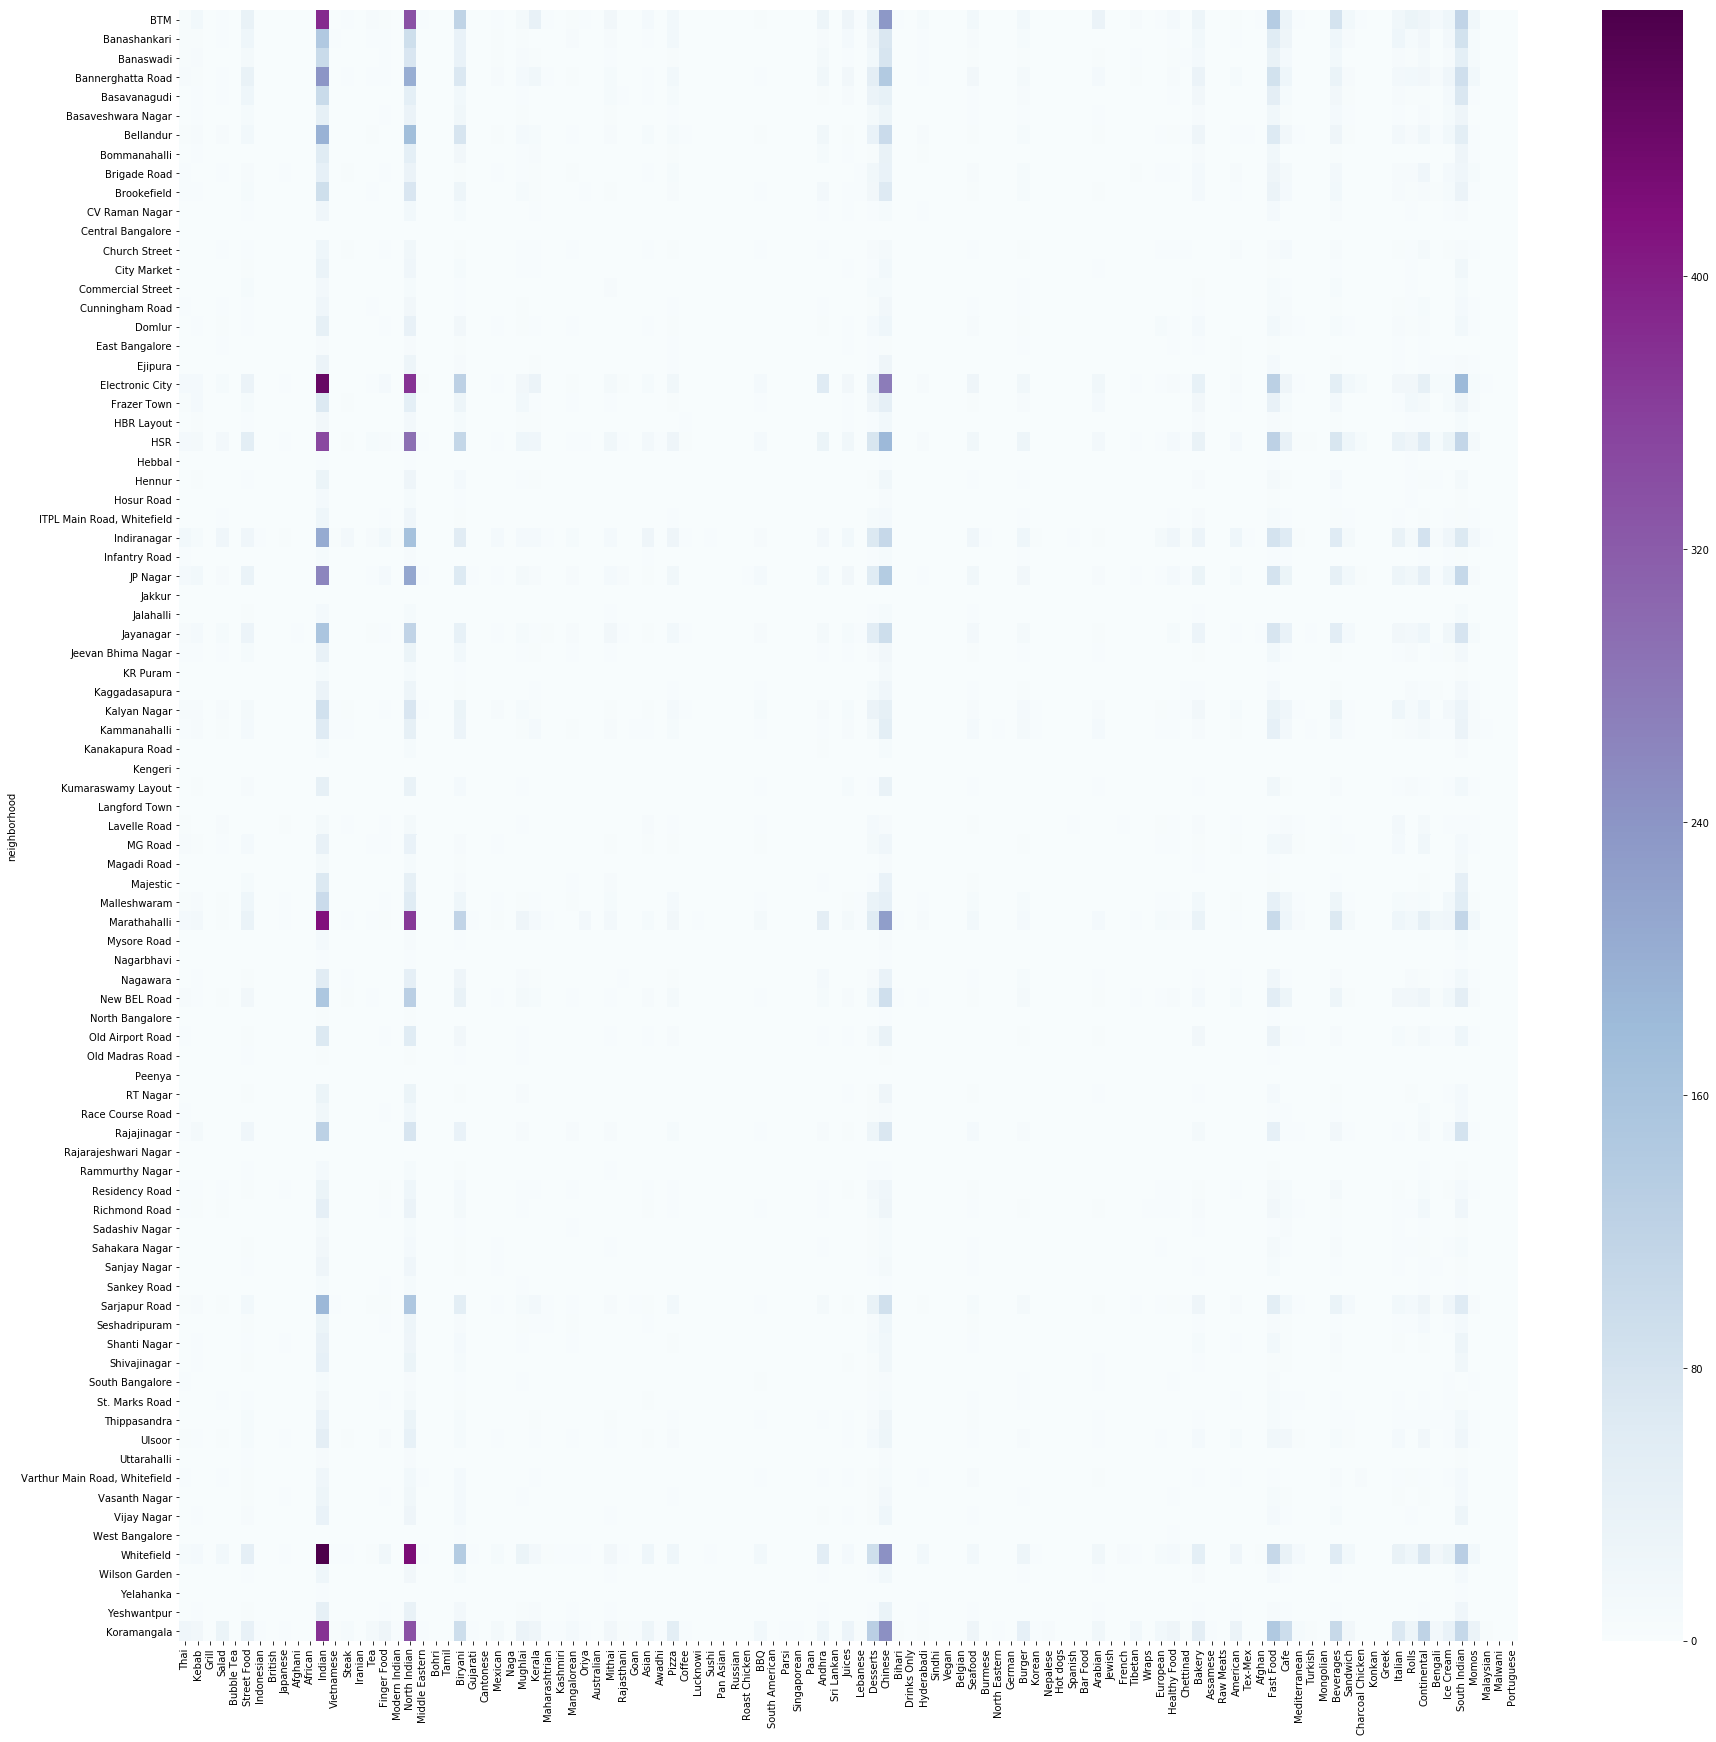

In [141]:
plt.figure(figsize=(30,30))
sns.heatmap(neighborhood_cns,cmap="BuPu")

So can we say, an area becomes more famous as a particular specififc type of cuisine/restaurant increases over there

#### Top 15 Cuisines Of Bengaluru

In [142]:

Cuisine_data = pd.DataFrame(neighborhood_cns.sum(axis=0))
Cuisine_data.reset_index(inplace=True)
Cuisine_data.columns = ['Cuisines', 'Number of Resturants']
Top15= (Cuisine_data.sort_values(['Number of Resturants'],ascending=False)).head(15)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(Top15['Cuisines'], Top15['Number of Resturants'])
plt.xlabel('Cuisines', fontsize=20)
plt.ylabel('Number of Resturants', fontsize=20)
plt.title('Top 15 Cuisines on Zomato', fontsize=30)
plt.xticks(rotation = 90)
plt.show()

In [143]:
Cuisine_data_rating=(rest_df.groupby(['cuisines'], as_index=False)['rate'].mean())
Cuisine_data_rating.columns = ['Cuisines', 'Rating']
Top30_ratings= (Cuisine_data_rating.sort_values(['Rating'],ascending=False)).head(30)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(Top30_ratings['Cuisines'], Top30_ratings['Rating'])
plt.title('Top Rated Cuisines on Zomato', fontsize=30)
plt.xlabel('Cuisines', fontsize=20)
plt.ylabel('Rating', fontsize=20)
plt.xticks(rotation = 90)
plt.show()

## Types Of Restaurant

In [144]:
listed = rest_df['listed_in(type)'].unique()
column_names = list(listed)
# instantiate the dataframe
neighborhood_lst = pd.DataFrame(columns=column_names)
neighborhood_lst

Empty DataFrame
Columns: [Buffet, Cafes, Delivery, Desserts, Dine-out, Drinks & nightlife, Pubs and bars]
Index: []

In [145]:
neighborhood_lst['neighborhood'] = rest_df.groupby('location').groups.keys()
neighborhood_lst = neighborhood_lst.set_index('neighborhood').fillna(0)
neighborhood_lst

Buffet  Cafes  Delivery  Desserts  Dine-out  \
neighborhood                                                                 
BTM                                 0      0         0         0         0   
Banashankari                        0      0         0         0         0   
Banaswadi                           0      0         0         0         0   
Bannerghatta Road                   0      0         0         0         0   
Basavanagudi                        0      0         0         0         0   
Basaveshwara Nagar                  0      0         0         0         0   
Bellandur                           0      0         0         0         0   
Bommanahalli                        0      0         0         0         0   
Brigade Road                        0      0         0         0         0   
Brookefield                         0      0         0         0         0   
CV Raman Nagar                      0      0         0         0         0   
Central Bangalore                   0      0         0         0         0   
Church Street                       0      0         0         0         0   
City Market                         0      0         0         0         0   
Commercial Street                   0      0         0         0         0   
Cunningham Road                     0      0         0         0         0   
Domlur                              0      0         0         0         0   
East Bangalore                      0      0         0         0         0   
Ejipura                             0      0         0         0         0   
Electronic City                     0      0         0         0         0   
Frazer Town                         0      0         0         0         0   
HBR Layout                          0      0         0         0         0   
HSR                                 0      0         0         0         0   
Hebbal                              0      0         0         0         0   
Hennur                              0      0         0         0         0   
Hosur Road                          0      0         0         0         0   
ITPL Main Road, Whitefield          0      0         0         0         0   
Indiranagar                         0      0         0         0         0   
Infantry Road                       0      0         0         0         0   
JP Nagar                            0      0         0         0         0   
...                               ...    ...       ...       ...       ...   
Old Madras Road                     0      0         0         0         0   
Peenya                              0      0         0         0         0   
RT Nagar                            0      0         0         0         0   
Race Course Road                    0      0         0         0         0   
Rajajinagar                         0      0         0         0         0   
Rajarajeshwari Nagar                0      0         0         0         0   
Rammurthy Nagar                     0      0         0         0         0   
Residency Road                      0      0         0         0         0   
Richmond Road                       0      0         0         0         0   
Sadashiv Nagar                      0      0         0         0         0   
Sahakara Nagar                      0      0         0         0         0   
Sanjay Nagar                        0      0         0         0         0   
Sankey Road                         0      0         0         0         0   
Sarjapur Road                       0      0         0         0         0   
Seshadripuram                       0      0         0         0         0   
Shanti Nagar                        0      0         0         0         0   
Shivajinagar                        0      0         0         0         0   
South Bangalore                     0      0         0         0         0   
St. Marks Road                      0      0         

In [146]:
i=0
for i in range(0,len(rest_df)):
    for x in listed:
        if type(rest_df.loc[i, 'listed_in(type)']) == str and x in rest_df.loc[i, 'listed_in(type)'] and type(rest_df.loc[i, 'location']) == str:
            neighborhood_lst.loc[rest_df.loc[i, 'location'], x] = neighborhood_lst.loc[rest_df.loc[i, 'location'], x]+1

In [147]:
# Koramangala is divided into different block, lets combine them all
koramangala = ['Koramangala', 'Koramangala 1st Block', 'Koramangala 2nd Block', 'Koramangala 3rd Block', 'Koramangala 4th Block', 
'Koramangala 5th Block', 'Koramangala 6th Block', 'Koramangala 7th Block', 'Koramangala 8th Block']
koramangala_dict = dict(neighborhood_lst.loc[koramangala].sum())
neighborhood_lst = neighborhood_lst.drop(koramangala)
neighborhood_lst.loc['Koramangala'] = koramangala_dict

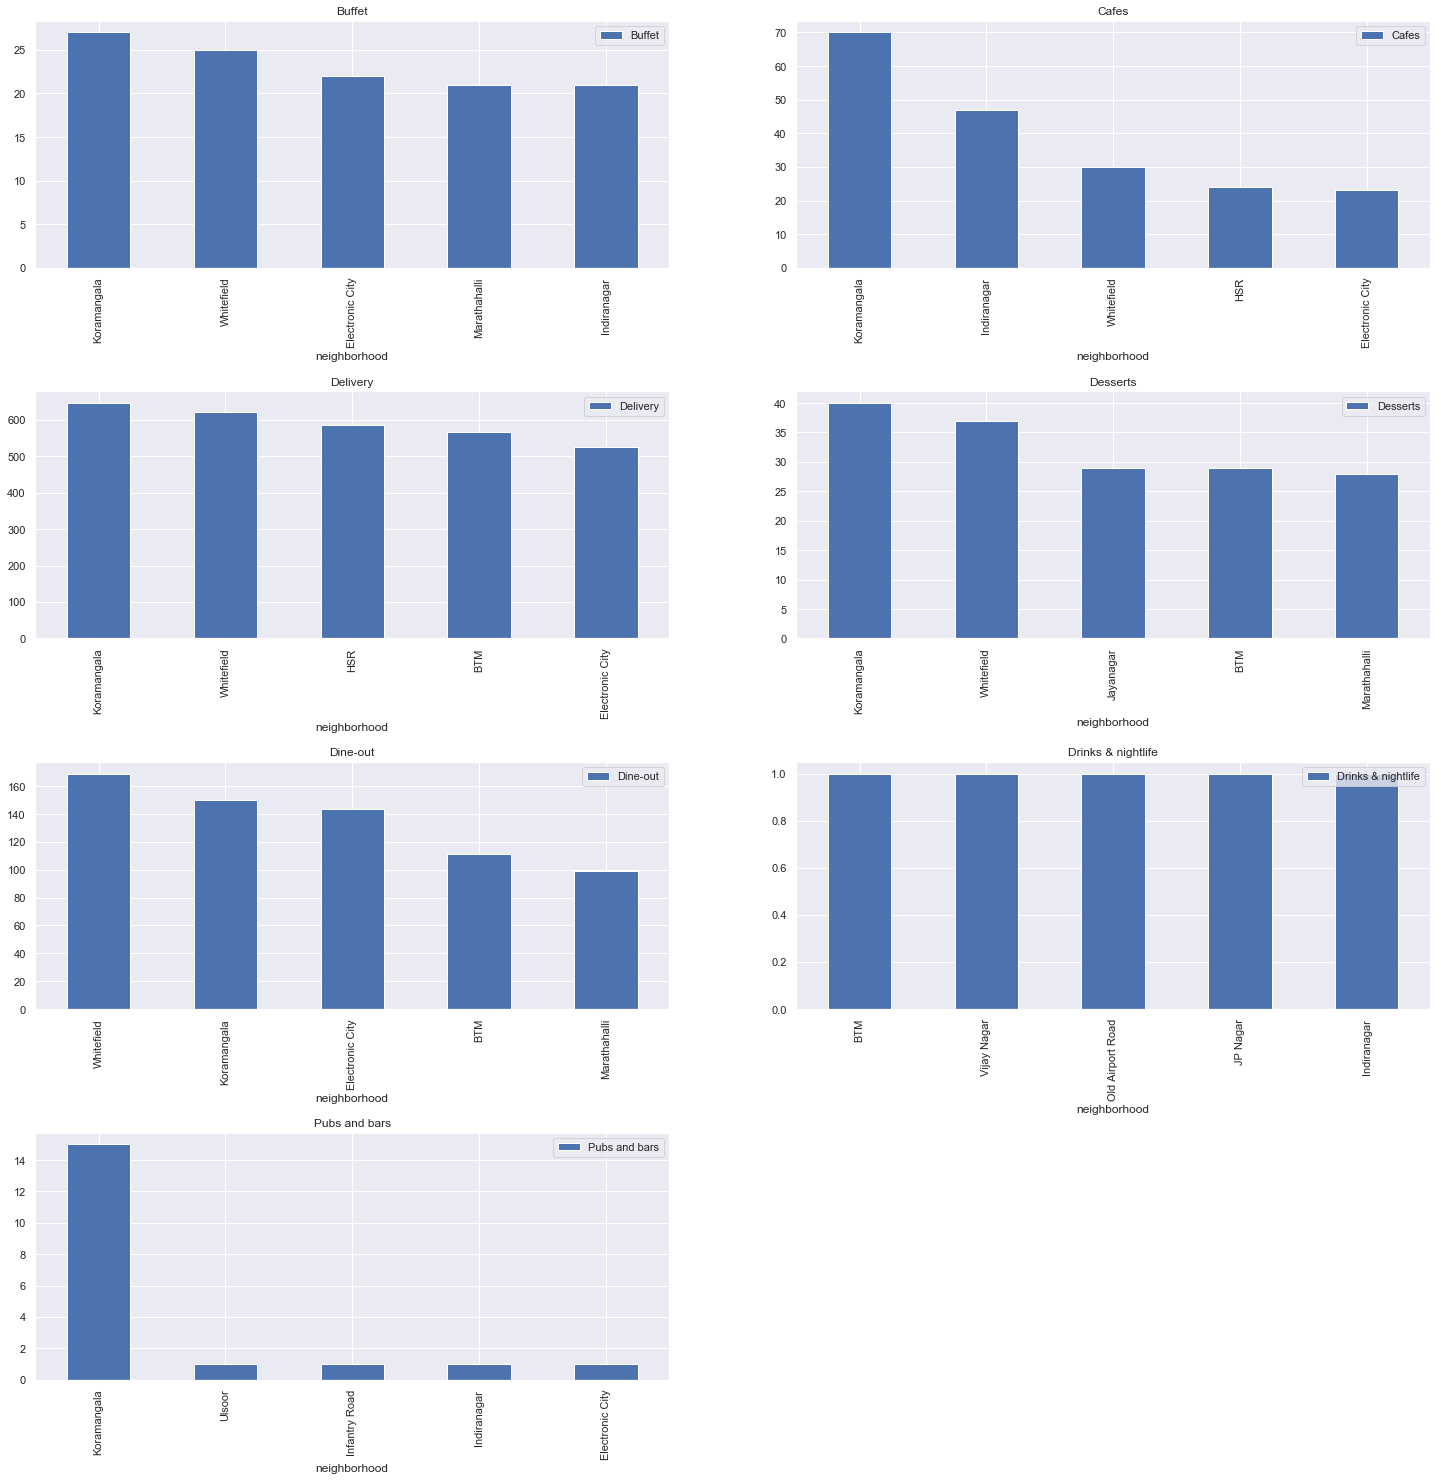

In [148]:
category = neighborhood_lst.columns
fig, ax = plt.subplots(nrows=4, ncols=2, figsize = (25,25))
fig.delaxes(ax[3,1])

plt.subplots_adjust(wspace=0.2, hspace=0.5)
ax = ax.flatten()

for i in range(0,len(category)):
    d= neighborhood_lst[[category[i]]].sort_values(by=category[i], ascending=False).head()
    d.plot(ax=ax[i],kind='bar')
    ax[i].set_title(category[i])
    ax[i].set_xticklabels(d.index, rotation='vertical')
    
plt.show()

Clearly Koramangala has most number of Pubs and bars, With whitefield having the most number of Dine out restaurant, Koramangala with high number of Desserts restaurant, again koramangala and whitefield with large number of delivery restaurant, Koramangala and Indira nagar with large number of Cafes and Koramangala and Whittefield with higher buffet restaurants than others.

It may not be wrong to conclude Koramangala as the hub of restaurants in Bengaluru.

## Rating

#### Restaurant rating Normal Distribution

Text(0, 0.5, 'Flights')

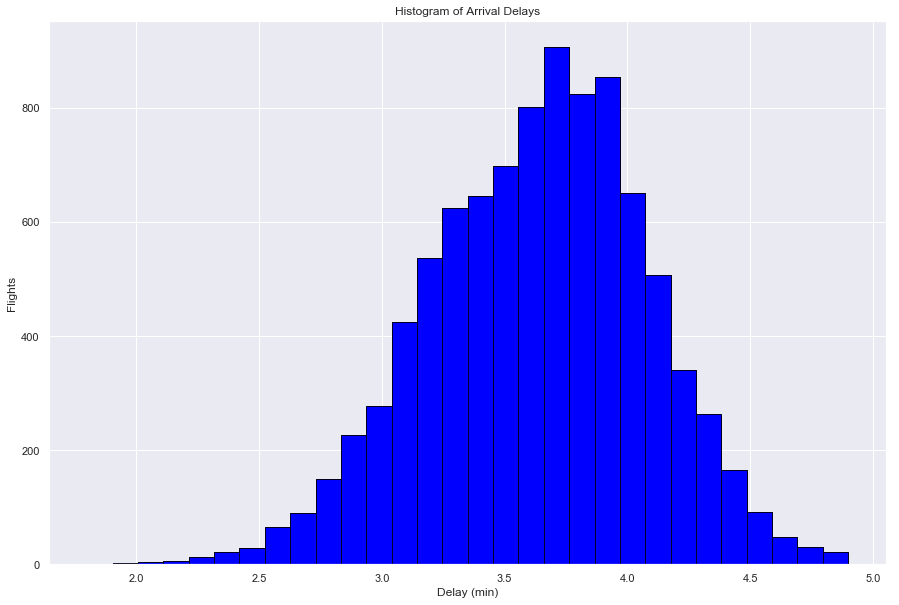

In [149]:
### Restaurant rating distibution
data = rest_df['rate'].dropna()
# matplotlib histogram
plt.figure(figsize=(15,10))
plt.hist(data, color = 'blue', edgecolor = 'black',
         bins = 30)

# seaborn histogram
sns.distplot(data, hist=True, kde=False 
             , color = 'blue',
             bins = 30,
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Flights')

In general, the rating distribution is not normal but in the highest score 3.7 has peak! We have to carefully see the condition of the highest rated restuarant

In [150]:
rest_df[rest_df['rate'] >= 4.8]

url  \
1994   https://www.zomato.com/bangalore/brahmins-coff...   
2087   https://www.zomato.com/bangalore/the-black-pea...   
2242   https://www.zomato.com/bangalore/byg-brewski-b...   
3036   https://www.zomato.com/bangalore/belgian-waffl...   
3917   https://www.zomato.com/bangalore/abs-absolute-...   
3918   https://www.zomato.com/bangalore/flechazo-whit...   
4269   https://www.zomato.com/bangalore/punjab-grill-...   
4906   https://www.zomato.com/bangalore/abs-absolute-...   
4917   https://www.zomato.com/bangalore/asia-kitchen-...   
5474   https://www.zomato.com/bangalore/belgian-waffl...   
5916   https://www.zomato.com/bangalore/house-of-comm...   
7425   https://www.zomato.com/bangalore/belgian-waffl...   
8302   https://www.zomato.com/bangalore/the-pizza-bak...   
8512   https://www.zomato.com/bangalore/milano-ice-cr...   
9014   https://www.zomato.com/bangalore/belgian-waffl...   
10311  https://www.zomato.com/bangalore/chilis-americ...   
10324  https://www.zomato.com/bangalore/punjab-grill-...   
10719  https://www.zomato.com/bangalore/o-g-variar-so...   
10887  https://www.zomato.com/bangalore/abs-absolute-...   
10888  https://www.zomato.com/bangalore/the-globe-gru...   
11167  https://www.zomato.com/bangalore/the-boozy-gri...   
11642  https://www.zomato.com/bangalore/sant%C3%A9-sp...   

                                                 address  \
1994   Ranga Rao Road, Near Shankar Mutt, Shankarapur...   
2087   20/7, Swamy Legato, Outer Ring Road, Kadubeesa...   
2242          Behind MK Retail, Sarjapur Road, Bangalore   
3036   65, Markham Road, Ashok Nagar, Brigade Road, B...   
3917   2nd Floor, I20-A2, EPIP Zone, Near Vydehi Hosp...   
3918   120 A3, 2nd Floor, Santosh Tower, EPIP Industr...   
4269   Ground Floor, Forum Shantiniketan, Whitefield ...   
4906   100 Feet Road, 1st Phase, Near Jayadeva Flyove...   
4917   136, Ground Floor, 1st Cross, 5th Block, Jyoti...   
5474   13 KHB Colony, 17th Main, M.I.G, Koramangala 5...   
5916   122/B, Jyothi Nivas Road, 5th Block, Koramanga...   
7425                            Vasanth Nagar, Bangalore   
8302   2985, 12th Main, HAL 2nd Stage, Indiranagar, B...   
8512   460, 2nd Cross, Krishna Temple Road, Indiranag...   
9014   5M/406, Ground Floor, 2nd Block extension, Hen...   
10311  2nd Floor, Orion Mall, Dr. Rajkumar Road, Mall...   
10324  26/1, Dr Rajkumar Road, Brigade Gateway Campus...   
10719       12th Main, 2nd Block, Rajajinagar, Bangalore   
10887  90/4, 3rd Floor, Outer Ring Road, Munnekollaly...   
10888  2nd Floor, Soul Space Paradigm, Above Bata Sho...   
11167  20/7, 4th & 5th Floor, Swamy Legato, Outer Rin...   
11642  151, 2nd Cross, Domlur 2nd Stage, Indiranagar,...   

                                                    name online_order  \
1994                                Brahmin's Coffee Bar           No   
2087                                     The Black Pearl           No   
2242                         Byg Brewski Brewing Company          Yes   
3036                              Belgian Waffle Factory          Yes   
3917                           AB's - Absolute Barbecues           No   
3918                                            Flechazo           No   
4269                                        Punjab Grill          Yes   
4906                           AB's - Absolute Barbecues           No   
4917                      Asia Kitchen By Mainland China          Yes   
5474                              Belgian Waffle Factory          Yes   
5916                                    House Of Commons           No   
7425                              Belgian Waffle Factory          Yes   
8302                                    The Pizza Bakery          Yes   
8512                                    Milano Ice Cream           No   
9014                              Belgian Waffle Factory          Yes   
10311                       Chili's American Grill & Bar          Yes   
10324                                       Punjab

Most of the High rated restaurants had North Indian Cuisine in their menu, moreover we can see that all the higher rated restaurant has higher cost of food too. However location does not play much important role here.

### Price range and rating

In [151]:
# Now lets plot box plot based on the cost of food
bins = pd.IntervalIndex.from_tuples([(0, 500), (501, 1000), (1001, 2000), (2001, 3000), (3001, 4000), (4001, 5000), (5001, 6000)])
rest_df['cost_cat'] = pd.cut(rest_df['approx_cost(for two people)'], bins)


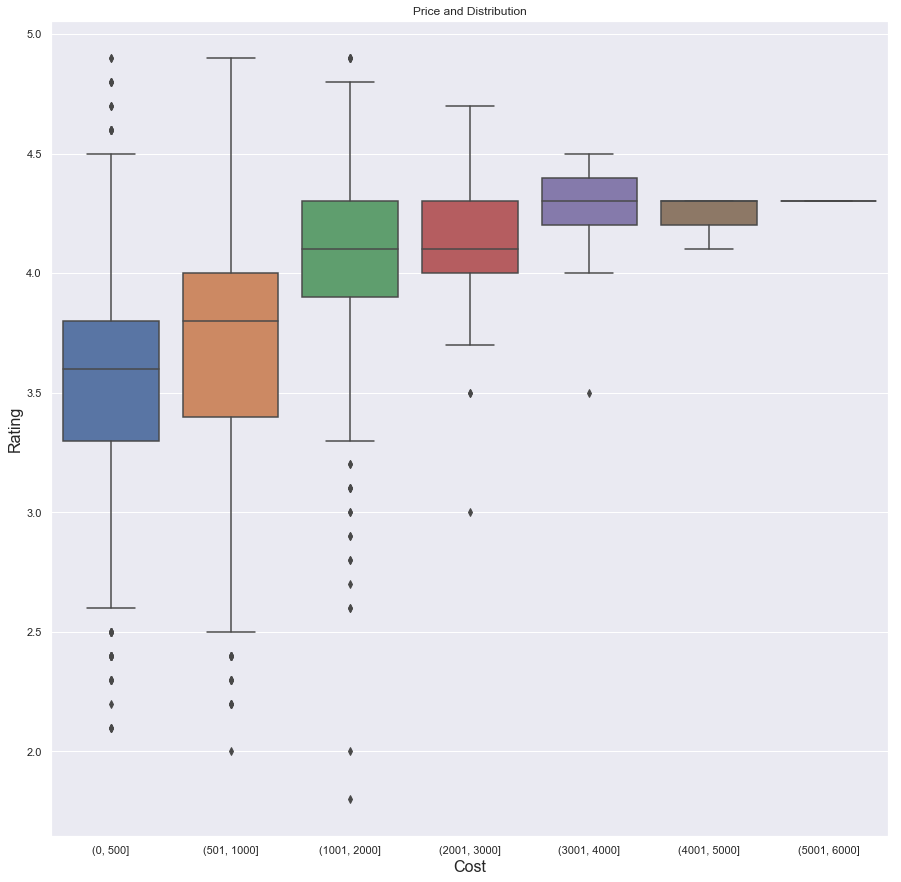

In [152]:
plt.figure(figsize=(15,15))
ax = sns.boxplot(x="cost_cat", y="rate", data=rest_df)
ax.set_xlabel('Cost', fontsize=16)
ax.set_ylabel('Rating', fontsize=16)
ax.set_title('Price and Distribution')
plt.savefig("box.png")
rest_df.drop('cost_cat', axis=1, inplace=True)

It can be seen that as the price increases the average rating of restaurants also increase. So can we say Price does affect rating of a restaurant.?
Not now, there may be some other factors too. lets find out

## Cuisine

#### Cuisine  and rating of a resaurant
Does having more number of cuisine mean higher rating of the restaurant

In [157]:
def fun(x):
    if(type(x) == list):
        return (len(x))
    else:
        return 0
rest_df['no_of_cuisine'] = rest_df['cuisines'].str.split(',').apply(fun)


In [158]:
rest_df.groupby(['no_of_cuisine'])['rate'].mean()

no_of_cuisine
0    3.400000
1    3.585200
2    3.589325
3    3.621504
4    3.737044
5    3.790373
6    3.921359
7    3.915517
8    3.768571
Name: rate, dtype: float64

In [159]:
rest_df.drop('no_of_cuisine', axis=1, inplace=True)

Yes it can be seen that retaurants having more number of cuisines are rated higher

#### So is there a particular cuisine in a restaurant that makes the restaurant rated higher

In [160]:
cuisine = set()
def func(x):
    if(type(x) == list):
        for y in x:
            cuisine.add(y.strip())
_ = rest_df['cuisines'].str.split(',').apply(func)

In [161]:
cui_df = rest_df[['name', 'location', 'rate', 'cuisines']]
column_names = list(cuisine)
# instantiate the dataframe
cui_df = pd.concat([cui_df, pd.DataFrame(columns=column_names)], axis=1)
cui_df.loc[:, ~cui_df.columns.isin(['name', 'location', 'rate', 'cuisines'])] = cui_df.loc[:, ~cui_df.columns.isin(['name', 'location', 'rate', 'cuisines'])].fillna(0)
cui_df

name  \
0                                                  Jalsa   
1                                         Spice Elephant   
2                                        San Churro Cafe   
3                                  Addhuri Udupi Bhojana   
4                                          Grand Village   
5                                        Timepass Dinner   
6        Rosewood International Hotel - Bar & Restaurant   
7                                                 Onesta   
8                                         Penthouse Cafe   
9                                              Smacznego   
10     CafÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ© Down The A...   
11                                          Cafe Shuffle   
12                                      The Coffee Shack   
13                                            Caf-Eleven   
14                                         Cafe Vivacity   
15                                          Catch-up-ino   
16                                      Kirthi's Biryani   
17                                              T3H Cafe   
18                         360 Atoms Restaurant And Cafe   
19                                      The Vintage Cafe   
20                                          Woodee Pizza   
21                                       Cafe Coffee Day   
22                                          My Tea House   
23                                         Hide Out Cafe   
24                                             CAFE NOVA   
25                                          Coffee Tindi   
26                                        Sea Green Cafe   
27                                                 Cuppa   
28                                      Srinathji's Cafe   
29                                             Redberrys   
...                                                  ...   
12469                                       Black Pagoda   
12470                              Noodle And Soup Point   
12471                                           Food Dig   
12472                                          Ishwaryam   
12473                                         Hungry Wok   
12474                                        Get Grilled   
12475                                       Thindi Sante   
12476                                       Hotel Devika   
12477                              Basaveshwara Kanawali   
12478                                    Sri Udupi Grand   
12479                                 SM Bangarpet Chats   
12480                                        Mad Kitchen   
12481                                             V Dine   
12482                                    Polly's Kitchen   
12483                                    The Yellow Stop   
12484                                 Arabian Fame Grill   
12485                                      Roll Junction   
12486                                 Shrawan Restaurant   
12487                        Calcutta North Indian Meals   
12488                                            Chianti   
12489  Chime - Sheraton Grand Bengaluru Whitefield Ho...   
12490                       The Nest - The Den Bengaluru   
12491                                          Chung Wah   
12492                                      Nawabs Empire   
12493                                     Fujian Express   
12494                                 New Shalimar Hotel   
12495        Nook - Aloft Bengaluru Cessna Business Park   
12496                                   SeeYa Restaurant   
12497                                            Bhagini   
12498  Plunge - Sheraton Grand Bengaluru Whitefield H...   

                         location  rate  \
0                    Banashankari   4.1   
1                    Banashankari   4.1   
2                    Banashankari   3.8   
3                    Banashankari   3.7   
4                    Basavanagudi   3.8   
5                    Basavanagudi   3.8   
6                     Mysore R

In [162]:
for i in range(0, len(cui_df)):
    for x in cuisine:
        if type(cui_df.loc[i, 'cuisines']) == str and x in cui_df.loc[i, 'cuisines']:
            cui_df.loc[i, x] = cui_df.loc[i, x]+1

In [163]:
def set_pandas_options() -> None:
    pd.options.display.max_columns = 20
    pd.options.display.max_rows = 75
    pd.options.display.max_colwidth = 199
    pd.options.display.width = None
    # pd.options.display.precision = 2  # set as needed

set_pandas_options()

In [164]:
cui_df.groupby('rate').sum().tail(10).T

rate              4.0  4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9
Thai               24   15   11   11   12    7    2    2    0    1
Kebab              16    6    5    5    3    1    0    3    0    0
Grill               1    0    0    0    0    0    0    0    0    0
Salad              15   19   21   21    6   10    5    1    0    1
Bubble Tea          0    1    0    0    0    0    0    0    0    0
Street Food        53   40   20    7    1    0    0    0    0    0
Indonesian          1    1    2    3    1    0    1    0    0    0
British             0    0    1    1    0    0    0    0    0    0
Japanese            4    5    3   13    9    2    1    2    0    0
Afghani             0    1    0    0    0    0    0    0    0    0
African             0    0    0    1    0    0    2    0    0    0
Indian            263  212  126  101   75   38   14   17    6    5
Vietnamese          7    4    0    2    5    2    1    0    0    0
Steak              15   13    9    5    1    3    3    3    0    0
Iranian             0    1    0    0    0    0    0    0    0    0
Tea                 4    3    3    1    2    0    1    0    0    0
Finger Food        10   23   14   20    7    6    5    0    0    1
Modern Indian       2    2    2    3    5    3    0    1    0    0
North Indian      226  178  110   78   63   31   13   14    5    5
Middle Eastern      1    0    2    1    1    0    0    0    0    0
Bohri               0    0    0    0    0    0    0    0    0    0
Tamil               0    0    0    0    0    0    0    0    0    0
Biryani            68   36   26   19   12    4    1    0    0    0
Gujarati            3    1    0    0    0    0    0    0    0    0
Cantonese           0    0    0    0    0    0    1    0    0    0
Mexican            14   23    8    4    5    3    2    0    1    0
Naga                2    0    0    1    0    0    0    0    0    0
Mughlai            28   27   13   13   12    4    2    0    0    1
Kerala              9    7    6    2    1    1    0    0    0    0
Maharashtrian       4    3    2    0    0    1    0    0    0    0
Kashmiri            1    0    0    0    0    0    0    0    0    0
Mangalorean         4   12    5    4    4    2    1    0    0    0
Oriya               0    0    0    0    0    0    0    0    0    0
Australian          0    0    0    0    0    0    0    0    0    0
Mithai             18    8    6    3    1    0    0    0    0    0
Rajasthani          4    3    2    3    0    0    0    0    0    0
Goan                1    2    2    0    1    0    0    1    0    0
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
Hot dogs            0    0    0    0    0    0    0    0    0    0
Spanish             1    0    2    2    0    0    1    0    0    0
Bar Food            0    0    0    1    0    0    0    0    0    0
Arabian             8    9   10    7    2    0    0    0    0    0
Jewish              0    0    0    1    0    0    0    0    0    0
French              2    3    2    3    2    1    0    0    0    0
Tibetan             7    0    3    3    0    0    0    0    0    0
Wraps               0    4    1    0    0    0    0    0    0    0
European            9   14   11   18    9    4    6    7    4    1
Healthy Food        9   18    9    9    7    3    1    0    0    1
Chettinad           2    1    2    1    0    0    0    0    0    0
Bakery             41   24   16   15    2    0    1    0    1    0
Assamese            1    0    1    0    0    0    0    0    0    0
Raw Meats           0    0    0    0    0    0    0    0    0    0
American           25   32   16   14   10    9    7    5    1    0
Tex-Mex             0    1    0    1    0    1    1    0    1    0
Afghan              2    3    1    0    0    0    0    0    0    0
Fast Food         117   67   32   18   10    1    1    0    0    0
Cafe               65   69   59   43   26   12    9    4    0    0
Mediterranean       6    7   14   10    8    6    2    7    3    3
Turkish             2    3    2    4    0    1 

After analysing the data it was found that these type of cuisines were very highly rated <i>Goa, Seafood, Korean, African,Fast Food, Biryani, Chinese, Continental, Thai, Sushi, Sindhi, Portuguese, Turkish, Naga, Jewish, 
Rajasthani, BBQ, Sandwich, Momos, Andhra, Steak, Tex-Mex, Arabian, Rolls, Healthy Food, Desserts, Finger Food, Pizza, Vietnamese
Italian, Mediterranean, Kebab, American, Japanese, Mexican, Indonesian, Burmese, European, French, Malaysian, Asian, Mughlai, Burger, 
Iranian</i> but among these <b>American, Italian, Pizza, Biryani, Continental, Chinese, Seafood, Korean</b> were much highly rated. Though North Indian, South Indian, Ice Cream, Mangalorean Beverages, Street Food, Cafe, Indian were the top rated but it is quite obvious for such type of restaurant to be at the top.

### Lets find out which neighborhood is famous for what type of cuisine

In [165]:
# Now can we say whcih neighborhood is famous for what type of food or cuisine
cuisine_grouped = cui_df.groupby('location').sum()
cuisine_grouped

rate  Thai  Kebab  Grill  Salad  Bubble Tea  \
location                                                                       
BTM                            1842.5     5     15      0      2           0   
Banashankari                    823.1     5      5      0      3           0   
Banaswadi                       507.7     4      6      0      0           0   
Bannerghatta Road              1216.6     7      4      0      2           0   
Basavanagudi                    650.5     1      3      0      2           0   
Basaveshwara Nagar              240.9     0      3      0      0           0   
Bellandur                       907.8     4      7      0      7           0   
Bommanahalli                    173.8     0      2      0      0           0   
Brigade Road                    397.0     2      0      0      3           0   
Brookefield                     499.8     2      3      0      1           0   
CV Raman Nagar                  101.5     1      0      0      1           0   
Central Bangalore                 3.7     0      0      0      0           0   
Church Street                   210.5     0      1      0      3           0   
City Market                      74.6     0      1      0      0           0   
Commercial Street               121.2     0      0      0      0           0   
Cunningham Road                 175.6     3      0      0      2           0   
Domlur                          260.3     0      2      0      4           0   
East Bangalore                   48.5     1      0      0      2           0   
Ejipura                         118.1     0      0      0      1           0   
Electronic City                1590.3    10     10      0      9           0   
Frazer Town                     522.9     4     10      0      1           0   
HBR Layout                       91.6     0      4      0      1           0   
HSR                            1881.2    11     12      0     14           1   
Hebbal                           14.4     0      0      0      0           0   
Hennur                          162.5     0      4      0      0           0   
Hosur Road                       38.1     0      0      0      0           0   
ITPL Main Road, Whitefield      121.7     1      0      0      2           0   
Indiranagar                    1645.1    15      9      0     22           0   
Infantry Road                    48.8     2      0      0      0           0   
JP Nagar                       1352.1    10     16      1      7           0   
Jakkur                            0.0     0      0      0      0           0   
Jalahalli                        52.2     0      0      0      0           0   
Jayanagar                      1150.8     6     10      0      9           0   
Jeevan Bhima Nagar              245.7     2      2      0      2           0   
KR Puram                         28.4     1      1      0      0           0   
Kaggadasapura                   174.5     1      0      0      1           0   
Kalyan Nagar                    706.6     7      6      0      6           0   
...                               ...   ...    ...    ...    ...         ...   
Marathahalli                   1758.2    11     14      0      4           0   
Mysore Road                      29.1     0      0      0      0           0   
Nagarbhavi                        3.4     0      0      0      0           0   
Nagawara                        297.2     1      2      0      0           0   
New BEL Road                    801.3     6      3      0      4           0   
North Bangalore                  13.5     0      0      0      1           0   
Old Airport Road                392.5     2      0      0      0           0   
Old Madras Road                  30.2     0      1      0      0           0   
Peenya                            3.2     0      0      0      0           0   
RT Nagar                        139.0     1      1      0      0           0   
Race Course Road                1

##### Lets print the top 5 cuisine famous in each of the neighborhood

In [166]:
num_top_venues = 5
for hood in cuisine_grouped.index:
    print("----"+hood+"----")
    temp = cuisine_grouped[cuisine_grouped.index == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BTM----
          venue   freq
0        Indian  385.0
1  North Indian  335.0
2       Chinese  236.0
3     Fast Food  138.0
4       Biryani  118.0


----Banashankari----
          venue   freq
0        Indian  144.0
1  North Indian   93.0
2  South Indian   85.0
3       Chinese   71.0
4     Fast Food   60.0


----Banaswadi----
          venue   freq
0        Indian  101.0
1       Chinese   77.0
2  North Indian   74.0
3  South Indian   49.0
4     Fast Food   38.0


----Bannerghatta Road----
          venue   freq
0        Indian  239.0
1  North Indian  200.0
2       Chinese  143.0
3  South Indian   91.0
4     Fast Food   85.0


----Basavanagudi----
          venue   freq
0        Indian  101.0
1  South Indian   72.0
2     Fast Food   52.0
3  North Indian   50.0
4       Chinese   42.0


----Basaveshwara Nagar----
          venue  freq
0        Indian  45.0
1  North Indian  32.0
2       Chinese  27.0
3  South Indian  25.0
4       Biryani  19.0


----Bellandur----
          venue   freq


          venue  freq
0        Indian  13.0
1  South Indian  12.0
2  North Indian   8.0
3       Chinese   6.0
4       Biryani   5.0


----Majestic----
          venue  freq
0        Indian  68.0
1  South Indian  48.0
2  North Indian  45.0
3       Chinese  36.0
4   Street Food   9.0


----Malleshwaram----
          venue  freq
0        Indian  99.0
1  North Indian  60.0
2  South Indian  57.0
3     Fast Food  43.0
4       Chinese  43.0


----Marathahalli----
          venue   freq
0        Indian  418.0
1  North Indian  367.0
2       Chinese  227.0
3       Biryani  116.0
4  South Indian  113.0


----Mysore Road----
          venue  freq
0        Indian  11.0
1  South Indian   9.0
2  North Indian   7.0
3       Chinese   6.0
4       Biryani   3.0


----Nagarbhavi----
          venue  freq
0       Chinese   3.0
1  South Indian   3.0
2        Indian   3.0
3  North Indian   2.0
4   Street Food   1.0


----Nagawara----
          venue  freq
0        Indian  59.0
1  North Indian  48.0
2       C

#### Cuisine popular in Bengaluru

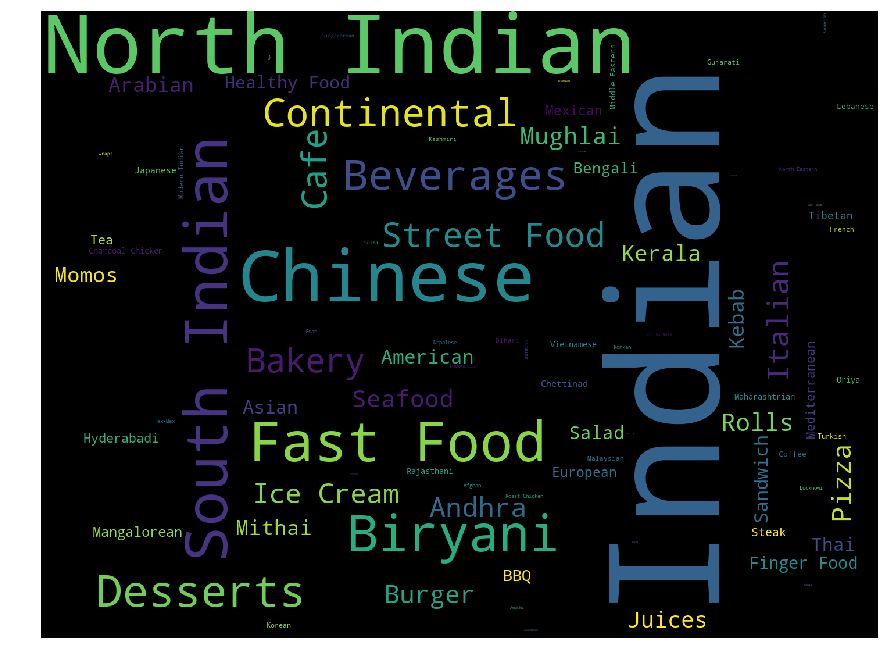

In [167]:
from subprocess import check_output
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = (WordCloud(width=1440, height=1080, relative_scaling=0.5).generate_from_frequencies(cuisine_grouped.iloc[:,1:].sum()))

fig = plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<img src="https://i.ibb.co/kXXNq2S/cuisine.png" alt="wordcloud" height="1500" width="1500">

#### Rating and Cuisine
#### Is there any cuisine which is always rated high

In [168]:
cui_df
# Now lets plot box plot based on the cost of food
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)])
cui_df['rate_cat'] = pd.cut(cui_df['rate'], bins)
cui_df['rate_cat'] = cui_df['rate_cat'].astype(str)
cui_df['rate_cat'] = cui_df['rate_cat'].map({'(0.0, 1.0]' : 1, '(1.0, 2.0]' : 2, '(2.0, 3.0]' : 3, '(3.0, 4.0]' : 4, '(4.0, 5.0]' : 5 })

In [169]:
ra_cu = cui_df.groupby(['rate_cat']).sum()
ra_cu

Empty DataFrame
Columns: [rate, Thai, Kebab, Grill, Salad, Bubble Tea, Street Food, Indonesian, British, Japanese, Afghani, African, Indian, Vietnamese, Steak, Iranian, Tea, Finger Food, Modern Indian, North Indian, Middle Eastern, Bohri, Tamil, Biryani, Gujarati, Cantonese, Mexican, Naga, Mughlai, Kerala, Maharashtrian, Kashmiri, Mangalorean, Oriya, Australian, Mithai, Rajasthani, Goan, Asian, Awadhi, Pizza, Coffee, Lucknowi, Sushi, Pan Asian, Russian, Roast Chicken, BBQ, South American, Parsi, Singaporean, Paan, Andhra, Sri Lankan, Juices, Lebanese, Desserts, Chinese, Bihari, Drinks Only, Hyderabadi, Sindhi, Vegan, Belgian, Seafood, Burmese, North Eastern, German, Burger, Korean, Nepalese, Hot dogs, Spanish, Bar Food, Arabian, Jewish, French, Tibetan, Wraps, European, Healthy Food, Chettinad, Bakery, Assamese, Raw Meats, American, Tex-Mex, Afghan, Fast Food, Cafe, Mediterranean, Turkish, Mongolian, Beverages, Sandwich, Charcoal Chicken, Konkan, Greek, Italian, Rolls, ...]
Index: []

[0 rows x 108 columns]

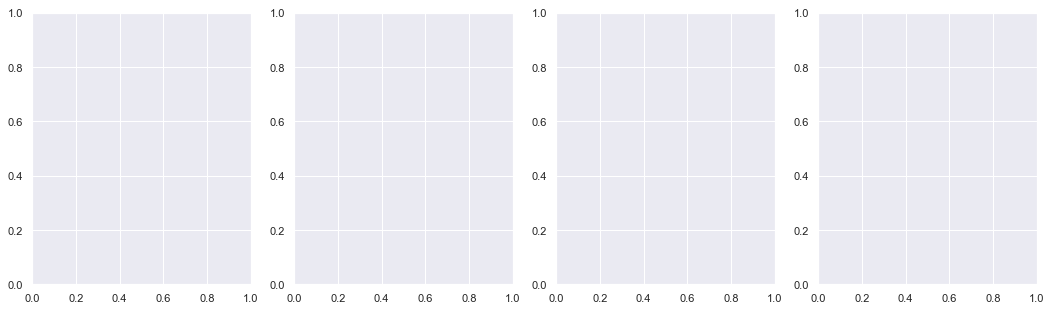

In [170]:
num_top_venues = 5
f, ax = plt.subplots(1,4, figsize = (18,5))
i = 2
for hood in ra_cu.index:
    print("----"+str(hood)+"----")
    temp = ra_cu[ra_cu.index == hood].T.reset_index()
    temp.columns = ['cuisine','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    sns.barplot(y = 'freq', x = 'cuisine', data = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues), ax = ax[i-2],)
    ax[i-2].set_title(str(i))
    ax[i-2].set_xticklabels(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues).cuisine, rotation='vertical')
    i+=1
plt.show()

Indian, North Indian, Chinese tough were common among the ratings but Most of the continental Cuisine restaurant were rated high which was also evident from the data, and not to forget there are large number of desserts restaurant

# Statistical Analysis

In [171]:
import statsmodels.formula.api as smf

### Are ratings affected by how cheap/expensive a restaurant is ?


In [172]:
data = [
    go.Scatter(x = rest_df['approx_cost(for two people)'],
              y = rest_df['rate'],
              mode = "markers",
               text = rest_df['name'],
               marker = dict(opacity = 0.7,
                            size = 10,
                            color = rest_df['rate'], #Set color equalivant to rating
                            colorscale= 'Viridis',
                            showscale=True,
                             maxdisplayed=2500,
                            ),
                hoverinfo="text+x+y",
              )
]
layout = go.Layout(autosize=True,
                   xaxis=dict(title="Average Cost of Two (INR)",
                             #titlefont=dict(size=20,),
                             #tickmode="linear",
                             ),
                   yaxis=dict(title="Rating",
                             #titlefont=dict(size=17,),
                             ),
                  )
iplot(dict(data=data, layout=layout))

As it seems, from a quick glance, there is no obseravable linear relationship. At almost every price point, there appears to be both Good and Bad restaurants.

Not wasting our time further lets carry out statistical analysis pearson correlation on it.<br>
<b>Null Hypothesis</b> : There is no relationship between the rating and price of the restaurant<br>
<b>Alternate Hypothesis</b> : There is some relationship between the two


In [173]:
pear = rest_df.dropna(subset=['approx_cost(for two people)', 'rate'])

In [174]:
from scipy import stats 
pearson_coef, p_value = stats.pearsonr(pear['approx_cost(for two people)'], pear['rate']) 
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", p_value) # Results 

Pearson Correlation Coefficient:  0.3272457895227555 and a P-value of: 1.2640230518118664e-230


The p-values comes out to be much much lower than our signifiance level. Hence we reject our NULL hypothesis and accept the alternate hypothesis. And our finding can be said to be statistically significant.
Therefore we can say that there is some relationship between the two.

### Do more votes == Higher Ratings?

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



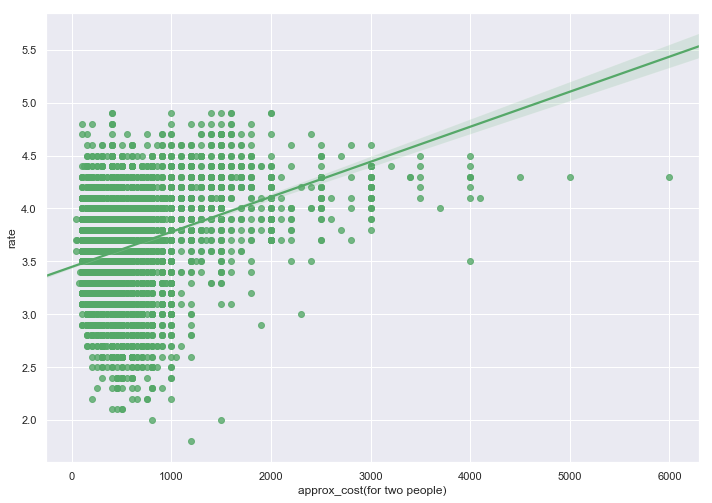

In [175]:
ax = sns.regplot(x=pear['approx_cost(for two people)'], y=pear['rate'], color="g")

As it seems, from a quick glance, there is no obseravable linear relationship. At almost every price point, there appears to be both low and high cost restaurants.

Lets carry out the statistical analysis

<b>Null Hypothesis</b> : There is no relationship between the rating and votes of the restaurant<br>
<b>Alternate Hypothesis</b> : There is some relationship between the two


In [176]:
pear = rest_df.dropna(subset=['votes', 'rate'])

In [177]:
pearson_coef, p_value = stats.pearsonr(pear['votes'], pear['rate']) 
print("Pearson Correlation Coefficient: ", pearson_coef, "and a P-value of:", p_value) # Results 

Pearson Correlation Coefficient:  0.39943342881574956 and a P-value of: 0.0


The p-value shows result is significant. And hence we reject our NULL hypothesis and accept the Alternate Hypothesis i.e both the variables are related and our finding was statistically significant

### Are restaurants that offer Table booking option rated higher?

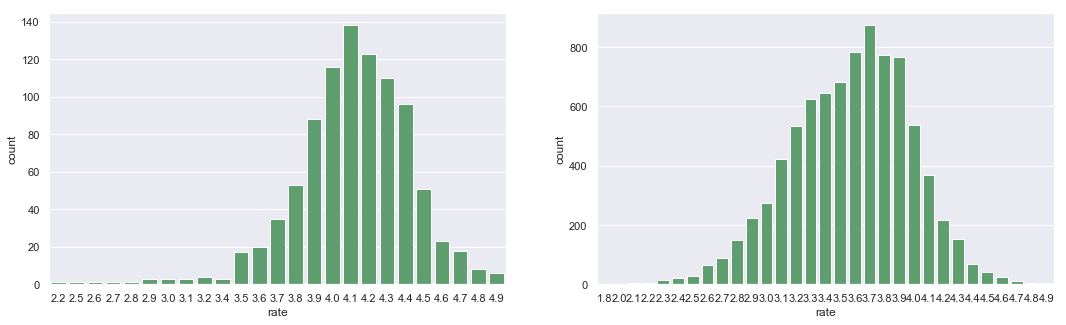

In [178]:
pear = rest_df[rest_df['book_table'] == 'Yes']
f, ax = plt.subplots(1,2, figsize = (18,5))
sns.countplot(pear['rate'], color="g", ax=ax[0])
pear = rest_df[rest_df['book_table'] == 'No']
sns.countplot(pear['rate'], color="g",  ax=ax[1])
plt.show()

In [179]:
model = smf.ols(formula='rate ~ C(book_table)', data=rest_df).fit()
print(model2.summary())

NameError: name 'model2' is not defined

Yes, The relation is statistically significant

## Now Lets see the top venues of each areas of Bangalore 
These are venues with the highest foot traffic at the time this regular call to the API is made. So at what time restaurants are more famous

In [180]:
import requests
from pandas.io.json import json_normalize

In [181]:
CLIENT_ID = 'WPTSXRBGDLUULN1OWDRCQUAE3KIEDUNMQM5AW5Q0DH5UCCAY' # your Foursquare ID
CLIENT_SECRET = 'TR4030IUWOWEHNIZCT0EQGVC2BMLZV35KSHH404AAWSMFXAU' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
radius = 9999

In [182]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [183]:
neigh_lat_lon = rest_df.groupby(['location'])['location_latitude', 'location_longitude'].first()
neigh_lat_lon

location_latitude  \
location                                                           
BTM                                                      12.9113   
Banashankari                                             12.9152   
Banaswadi                                                13.0142   
Bannerghatta Road                                        12.9167   
Basavanagudi                                             12.9417   
Basaveshwara Nagar                                       12.9932   
Bellandur                                                12.9791   
Bommanahalli                                             12.9089   
Brigade Road                                             12.9736   
Brookefield                        Brookefield, Bengaluru, India   
CV Raman Nagar                                           17.2511   
Central Bangalore                                        12.9791   
Church Street                                            12.9751   
City Market                                              12.9657   
Commercial Street                                        12.9822   
Cunningham Road                                          12.9869   
Domlur                                                   12.9625   
East Bangalore                                           12.9791   
Ejipura                                                  12.9452   
Electronic City                                          12.9791   
Frazer Town                                              12.9968   
HBR Layout                                               13.0359   
HSR                                                      12.9121   
Hebbal                                                   13.0382   
Hennur                                                   13.0258   
Hosur Road                                               12.9296   
ITPL Main Road, Whitefield                               12.9676   
Indiranagar                                              12.9733   
Infantry Road                                            12.9832   
JP Nagar                                                 12.2811   
Jakkur                                                   13.0785   
Jalahalli                                                13.0465   
Jayanagar                                                12.9293   
Jeevan Bhima Nagar                                       12.9678   
KR Puram                                                 13.0075   
Kaggadasapura                                            12.9847   
Kalyan Nagar                                             13.0221   
...                                                          ...   
Marathahalli                                             12.9553   
Mysore Road                                              12.9458   
Nagarbhavi                                               12.9651   
Nagawara                                                 13.0338   
New BEL Road                                             13.0421   
North Bangalore                                          12.9791   
Old Airport Road                                         12.9594   
Old Madras Road                                          13.0076   
Peenya                                                   13.0329   
RT Nagar                                                 13.0227   
Race Course Road                                         1.30643   
Rajajinagar                                              12.9882   
Rajarajeshwari Nagar                                     12.9274   
Rammurthy Nagar                Rammurthy Nagar, Bengaluru, India   
Residency Road                                           13.0553   
Richmond Road                                            12.9667   
Sadashiv Nagar                                            18.955   
Sahakara Nagar                                           13.0621   
Sanjay Nagar                                             12.9579   
Sankey Road                        

In [184]:
column_names = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5']
# instantiate the dataframe
df = pd.DataFrame(columns=column_names)
df

Empty DataFrame
Columns: [cat1, cat2, cat3, cat4, cat5]
Index: []

In [185]:
i=0
for lat, long in zip(neigh_lat_lon.location_latitude, neigh_lat_lon.location_longitude):
    latitude = lat
    longitude = long
    # define URL
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    # send GET request and get trending venues
    results = requests.get(url).json()
    items = results['response']['groups'][0]['items']
    
    dataframe = json_normalize(items) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean columns
    dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

    print(neigh_lat_lon.index[i], " : ",dataframe_filtered.head(5)['categories'])
    df.loc[neigh_lat_lon.index[i]] = dataframe_filtered.head(5)['categories'].tolist()
    i+=1
    

BTM  :  0           Ice Cream Shop
1              Snack Place
2    Performing Arts Venue
3        Indian Restaurant
4             Burger Joint
Name: categories, dtype: object
Banashankari  :  0              Pizza Place
1    Performing Arts Venue
2              Snack Place
3           Ice Cream Shop
4        Indian Restaurant
Name: categories, dtype: object
Banaswadi  :  0        Ice Cream Shop
1                Bakery
2        Ice Cream Shop
3    Falafel Restaurant
4                   Pub
Name: categories, dtype: object
Bannerghatta Road  :  0           Ice Cream Shop
1        Indian Restaurant
2    Performing Arts Venue
3              Snack Place
4             Burger Joint
Name: categories, dtype: object
Basavanagudi  :  0         Dessert Shop
1    Indian Restaurant
2       Sandwich Place
3           Restaurant
4       Breakfast Spot
Name: categories, dtype: object
Basaveshwara Nagar  :  0          Ice Cream Shop
1                  Bakery
2                  Bakery
3           Shopping 

KeyError: 'groups'

In [186]:
df

cat1                   cat2  \
BTM                 Ice Cream Shop            Snack Place   
Banashankari           Pizza Place  Performing Arts Venue   
Banaswadi           Ice Cream Shop                 Bakery   
Bannerghatta Road   Ice Cream Shop      Indian Restaurant   
Basavanagudi          Dessert Shop      Indian Restaurant   
Basaveshwara Nagar  Ice Cream Shop                 Bakery   
Bellandur                     Park                  Hotel   
Bommanahalli          Burger Joint              BBQ Joint   
Brigade Road               Brewery            Coffee Shop   

                                     cat3                  cat4  \
BTM                 Performing Arts Venue     Indian Restaurant   
Banashankari                  Snack Place        Ice Cream Shop   
Banaswadi                  Ice Cream Shop    Falafel Restaurant   
Bannerghatta Road   Performing Arts Venue           Snack Place   
Basavanagudi               Sandwich Place            Restaurant   
Basaveshwara Nagar                 Bakery         Shopping Mall   
Bellandur                           Hotel              Tea Room   
Bommanahalli               Ice Cream Shop  Fast Food Restaurant   
Brigade Road                 Burger Joint   American Restaurant   

                                    cat5  
BTM                         Burger Joint  
Banashankari           Indian Restaurant  
Banaswadi                            Pub  
Bannerghatta Road           Burger Joint  
Basavanagudi              Breakfast Spot  
Basaveshwara Nagar  Fast Food Restaurant  
Bellandur                  Shopping Mall  
Bommanahalli                        Café  
Brigade Road                      Lounge

# Cluster Neighborhoods

### Clustering on the basis of cuisine

In [187]:
## Now lets use ML to cluster neighborhoods by their food style
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [188]:
cuisine = set()
def func(x):
    if(type(x) == list):
        for y in x:
            cuisine.add(y.strip())
_ = rest_df['cuisines'].str.split(',').apply(func)
cui_df = rest_df[['name', 'location', 'rate', 'cuisines']]
column_names = list(cuisine)
# instantiate the dataframe
cui_df = pd.concat([cui_df, pd.DataFrame(columns=column_names)], axis=1)
cui_df.loc[:, ~cui_df.columns.isin(['name', 'location', 'rate', 'cuisines'])] = cui_df.loc[:, ~cui_df.columns.isin(['name', 'location', 'rate', 'cuisines'])].fillna(0)
cui_df

name  \
0                                                        Jalsa   
1                                               Spice Elephant   
2                                              San Churro Cafe   
3                                        Addhuri Udupi Bhojana   
4                                                Grand Village   
5                                              Timepass Dinner   
6              Rosewood International Hotel - Bar & Restaurant   
7                                                       Onesta   
8                                               Penthouse Cafe   
9                                                    Smacznego   
10          CafÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ© Down The Alley   
11                                                Cafe Shuffle   
12                                            The Coffee Shack   
13                                                  Caf-Eleven   
14                                               Cafe Vivacity   
15                                                Catch-up-ino   
16                                            Kirthi's Biryani   
17                                                    T3H Cafe   
18                               360 Atoms Restaurant And Cafe   
19                                            The Vintage Cafe   
20                                                Woodee Pizza   
21                                             Cafe Coffee Day   
22                                                My Tea House   
23                                               Hide Out Cafe   
24                                                   CAFE NOVA   
25                                                Coffee Tindi   
26                                              Sea Green Cafe   
27                                                       Cuppa   
28                                            Srinathji's Cafe   
29                                                   Redberrys   
30                                                  Foodiction   
31                                                 Sweet Truth   
32                                             Ovenstory Pizza   
33                                                      Faasos   
34                                             Behrouz Biryani   
35                                              Fast And Fresh   
36                                             Szechuan Dragon   
...                                                        ...   
12462                                                  Tuk-Tuk   
12463                                         New Udupi Upahar   
12464                                       Hotel Royal Darbar   
12465                                          Taste of Kerala   
12466                                             Nethra Hotel   
12467                                       A1 Hot Dum Biryani   
12468                                   Real Ambur Dum Biryani   
12469                                             Black Pagoda   
12470                                    Noodle And Soup Point   
12471                                                 Food Dig   
12472                                                Ishwaryam   
12473                                               Hungry Wok   
12474                                              Get Grilled   
12475                                             Thindi Sante   
12476                                             Hotel Devika   
12477                                    Basaveshwara Kanawali   
12478                                          Sri Udupi Grand   
12479                                       SM Bangarpet Chats   
12480                                              Mad Kitchen   
12481                                                   V Dine   
12482                                          Polly's Kitchen   
12483                                          The Yellow Stop   
12484                           

In [189]:
for i in range(0, len(cui_df)):
    for x in cuisine:
        if type(cui_df.loc[i, 'cuisines']) == str and x in cui_df.loc[i, 'cuisines']:
            cui_df.loc[i, x] = cui_df.loc[i, x]+1

cuisine_grouped = cui_df.groupby('location').sum()
cuisine_grouped.drop('name', axis=1, inplace=True)
cuisine_grouped

KeyError: "['name'] not found in axis"

In [190]:
# Koramangala is divided into different block, lets combine them all
koramangala = ['Koramangala', 'Koramangala 1st Block', 'Koramangala 2nd Block', 'Koramangala 3rd Block', 'Koramangala 4th Block', 
'Koramangala 5th Block', 'Koramangala 6th Block', 'Koramangala 7th Block', 'Koramangala 8th Block']
koramangala_dict = dict(cuisine_grouped.loc[koramangala].sum())
cuisine_grouped = cuisine_grouped.drop(koramangala)
cuisine_grouped.loc['Koramangala'] = koramangala_dict

In [191]:
# set number of clusters
kclusters = 3

bangalore_grouped_clustering = cuisine_grouped

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0,
       1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
      dtype=int32)

In [192]:
cuisine_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [193]:
cuisine_grouped.groupby('Cluster Labels').get_group(0)

Cluster Labels   rate  Thai  Kebab  Grill  \
location                                                                   
Basaveshwara Nagar                          0  240.9   0.0    3.0    0.0   
Bommanahalli                                0  173.8   0.0    2.0    0.0   
Brigade Road                                0  397.0   2.0    0.0    0.0   
CV Raman Nagar                              0  101.5   1.0    0.0    0.0   
Central Bangalore                           0    3.7   0.0    0.0    0.0   
Church Street                               0  210.5   0.0    1.0    0.0   
City Market                                 0   74.6   0.0    1.0    0.0   
Commercial Street                           0  121.2   0.0    0.0    0.0   
Cunningham Road                             0  175.6   3.0    0.0    0.0   
Domlur                                      0  260.3   0.0    2.0    0.0   
East Bangalore                              0   48.5   1.0    0.0    0.0   
Ejipura                                     0  118.1   0.0    0.0    0.0   
HBR Layout                                  0   91.6   0.0    4.0    0.0   
Hebbal                                      0   14.4   0.0    0.0    0.0   
Hennur                                      0  162.5   0.0    4.0    0.0   
Hosur Road                                  0   38.1   0.0    0.0    0.0   
ITPL Main Road, Whitefield                  0  121.7   1.0    0.0    0.0   
Infantry Road                               0   48.8   2.0    0.0    0.0   
Jakkur                                      0    0.0   0.0    0.0    0.0   
Jalahalli                                   0   52.2   0.0    0.0    0.0   
Jeevan Bhima Nagar                          0  245.7   2.0    2.0    0.0   
KR Puram                                    0   28.4   1.0    1.0    0.0   
Kaggadasapura                               0  174.5   1.0    0.0    0.0   
Kammanahalli                                0  459.8   3.0    7.0    0.0   
Kanakapura Road                             0   34.7   0.0    0.0    0.0   
Kengeri                                     0    3.7   0.0    0.0    0.0   
Kumaraswamy Layout                          0  230.1   0.0    4.0    0.0   
Langford Town                               0    7.3   0.0    0.0    0.0   
Lavelle Road                                0  211.8   4.0    1.0    0.0   
MG Road                                     0  323.8   6.0    4.0    0.0   
Magadi Road                                 0   54.7   0.0    1.0    0.0   
Majestic                                    0  216.7   0.0    0.0    0.0   
Mysore Road                                 0   29.1   0.0    0.0    0.0   
Nagarbhavi                                  0    3.4   0.0    0.0    0.0   
Nagawara                                    0  297.2   1.0    2.0    0.0   
North Bangalore                             0   13.5   0.0    0.0    0.0   
Old Airport Road                            0  392.5   2.0    0.0    0.0   
Old Madras Road                             0   30.2   0.0    1.0    0.0   
Peenya                                      0    3.2   0.0    0.0    0.0   
RT Nagar                                    0  139.0   1.0    1.0    0.0   
Race Course Road                            0  112.0   2.0    0.0    0.0   
Rajarajeshwari Nagar                        0    7.7   1.0    0.0    0.0   
Rammurthy Nagar                             0   50.3   0.0    0.0    0.0   
Residency Road                              0  280.1   2.0    2.0    1.0   
Richmond Road                               0  253.7   2.0    4.0    0.0   
Sadashiv Nagar                              0  106.1   1.0    1.0    0.0   
Sahakara Nagar                              0  145.8   1.0    1.0    0.0   
Sanjay Nagar                                0  103.3   1.0    0.0    0.0   
Sankey Road                                 0   48.5   0.0    1.0    0.0   
Seshadripuram                               0  171.3   1.0    1.0    0.0   
Shanti Nagar                                0  175.7   0.0    3.0    0.0   
Shi

In [194]:
cuisine_grouped.groupby('Cluster Labels').get_group(1)

Cluster Labels    rate  Thai  Kebab  Grill  Salad  \
location                                                             
BTM                           1  1842.5   5.0   15.0    0.0    2.0   
Electronic City               1  1590.3  10.0   10.0    0.0    9.0   
HSR                           1  1881.2  11.0   12.0    0.0   14.0   
Indiranagar                   1  1645.1  15.0    9.0    0.0   22.0   
Marathahalli                  1  1758.2  11.0   14.0    0.0    4.0   
Whitefield                    1  2220.1   9.0   11.0    0.0   16.0   
Koramangala                   1  2952.3  22.0   18.0    1.0   31.0   

                 Bubble Tea  Street Food  Indonesian  British     ...      \
location                                                          ...       
BTM                     0.0         39.0         0.0      0.0     ...       
Electronic City         0.0         32.0         0.0      1.0     ...       
HSR                     1.0         54.0         0.0      0.0     ...       
Indiranagar             0.0         21.0         3.0      0.0     ...       
Marathahalli            0.0         35.0         0.0      0.0     ...       
Whitefield              1.0         47.0         1.0      1.0     ...       
Koramangala             0.0         40.0         2.0      0.0     ...       

                 Italian  Rolls  Continental  Bengali  Ice Cream  \
location                                                           
BTM                 19.0   30.0         25.0     10.0       24.0   
Electronic City     18.0   17.0         46.0      8.0        9.0   
HSR                 35.0   25.0         63.0      9.0       30.0   
Indiranagar         39.0   12.0         84.0      6.0       22.0   
Marathahalli        23.0   16.0         45.0     19.0       21.0   
Whitefield          39.0   24.0         72.0     18.0       31.0   
Koramangala         70.0   27.0        120.0     14.0       37.0   

                 South Indian  Momos  Malaysian  Malwani  Portuguese  
location                                                              
BTM                     116.0   19.0        0.0      0.0         0.0  
Electronic City         182.0    9.0        2.0      0.0         0.0  
HSR                     113.0   13.0        0.0      0.0         0.0  
Indiranagar              69.0   14.0        3.0      0.0         1.0  
Marathahalli            113.0   15.0        0.0      0.0         0.0  
Whitefield              132.0   16.0        1.0      0.0         0.0  
Koramangala             109.0   32.0        4.0      0.0         0.0  

[7 rows x 109 columns]

In [195]:
cuisine_grouped.groupby('Cluster Labels').get_group(2)

Cluster Labels    rate  Thai  Kebab  Grill  Salad  \
location                                                               
Banashankari                    2   823.1   5.0    5.0    0.0    3.0   
Banaswadi                       2   507.7   4.0    6.0    0.0    0.0   
Bannerghatta Road               2  1216.6   7.0    4.0    0.0    2.0   
Basavanagudi                    2   650.5   1.0    3.0    0.0    2.0   
Bellandur                       2   907.8   4.0    7.0    0.0    7.0   
Brookefield                     2   499.8   2.0    3.0    0.0    1.0   
Frazer Town                     2   522.9   4.0   10.0    0.0    1.0   
JP Nagar                        2  1352.1  10.0   16.0    1.0    7.0   
Jayanagar                       2  1150.8   6.0   10.0    0.0    9.0   
Kalyan Nagar                    2   706.6   7.0    6.0    0.0    6.0   
Malleshwaram                    2   752.9   4.0    6.0    0.0    4.0   
New BEL Road                    2   801.3   6.0    3.0    0.0    4.0   
Rajajinagar                     2   625.5   2.0   12.0    0.0    0.0   
Sarjapur Road                   2   904.6   5.0    7.0    0.0    5.0   

                   Bubble Tea  Street Food  Indonesian  British     ...      \
location                                                            ...       
Banashankari              0.0         24.0         1.0      0.0     ...       
Banaswadi                 0.0         13.0         0.0      0.0     ...       
Bannerghatta Road         0.0         38.0         0.0      0.0     ...       
Basavanagudi              0.0         23.0         0.0      0.0     ...       
Bellandur                 0.0         15.0         0.0      0.0     ...       
Brookefield               0.0          9.0         0.0      0.0     ...       
Frazer Town               0.0          9.0         0.0      0.0     ...       
JP Nagar                  0.0         35.0         0.0      0.0     ...       
Jayanagar                 0.0         29.0         0.0      0.0     ...       
Kalyan Nagar              0.0         13.0         1.0      0.0     ...       
Malleshwaram              0.0         24.0         0.0      0.0     ...       
New BEL Road              0.0         18.0         0.0      0.0     ...       
Rajajinagar               0.0         22.0         0.0      0.0     ...       
Sarjapur Road             0.0         15.0         0.0      0.0     ...       

                   Italian  Rolls  Continental  Bengali  Ice Cream  \
location                                                             
Banashankari          24.0    8.0         18.0      0.0       14.0   
Banaswadi              6.0    5.0         12.0      0.0        7.0   
Bannerghatta Road     14.0   15.0         18.0      6.0       22.0   
Basavanagudi           6.0    5.0          5.0      0.0       10.0   
Bellandur             14.0    7.0         20.0      3.0       15.0   
Brookefield            6.0    4.0          7.0      4.0        8.0   
Frazer Town            2.0   15.0         12.0      1.0        9.0   
JP Nagar              27.0   20.0         48.0      3.0       24.0   
Jayanagar             17.0   14.0         24.0      1.0       20.0   
Kalyan Nagar          23.0    8.0         24.0      0.0       14.0   
Malleshwaram           9.0    6.0          9.0      0.0       16.0   
New BEL Road          17.0   17.0         25.0      4.0       15.0   
Rajajinagar            3.0    1.0         12.0      0.0       10.0   
Sarjapur Road         15.0   11.0         25.0      5.0       22.0   

                   South Indian  Momos  Malaysian  Malwani  Portuguese  
location                                                                
Banashankari               85.0    9.0        0.0      0.0         0.0  
Banaswadi                  49.0    8.0        0.0      0.0         0.0  
Bannerghatta Road          91.0   15.0        0.0      0.0         0.0  
Basavanagudi               72.0    2.0        0.0      0.0         0.0  
Bellandur                  54.0    3.0    

<!-- -->

#### Lets see them on map

In [196]:
map_df = pd.merge(rest_df[['location','location_latitude', 'location_longitude']].groupby('location').first(), cuisine_grouped, left_index=True, right_index=True)

In [199]:
map_df.head()

location_latitude location_longitude  Cluster Labels  \
location                                                                 
BTM                         12.9113            77.6046               1   
Banashankari                12.9152            77.5736               2   
Banaswadi                   13.0142            77.6519               2   
Bannerghatta Road           12.9167            77.5998               2   
Basavanagudi                12.9417            77.5755               2   

                     rate  Thai  Kebab  Grill  Salad  Bubble Tea  Street Food  \
location                                                                        
BTM                1842.5   5.0   15.0    0.0    2.0         0.0         39.0   
Banashankari        823.1   5.0    5.0    0.0    3.0         0.0         24.0   
Banaswadi           507.7   4.0    6.0    0.0    0.0         0.0         13.0   
Bannerghatta Road  1216.6   7.0    4.0    0.0    2.0         0.0         38.0   
Basavanagudi        650.5   1.0    3.0    0.0    2.0         0.0         23.0   

                      ...      Italian  Rolls  Continental  Bengali  \
location              ...                                             
BTM                   ...         19.0   30.0         25.0     10.0   
Banashankari          ...         24.0    8.0         18.0      0.0   
Banaswadi             ...          6.0    5.0         12.0      0.0   
Bannerghatta Road     ...         14.0   15.0         18.0      6.0   
Basavanagudi          ...          6.0    5.0          5.0      0.0   

                   Ice Cream  South Indian  Momos  Malaysian  Malwani  \
location                                                                
BTM                     24.0         116.0   19.0        0.0      0.0   
Banashankari            14.0          85.0    9.0        0.0      0.0   
Banaswadi                7.0          49.0    8.0        0.0      0.0   
Bannerghatta Road       22.0          91.0   15.0        0.0      0.0   
Basavanagudi            10.0          72.0    2.0        0.0      0.0   

                   Portuguese  
location                       
BTM                       0.0  
Banashankari              0.0  
Banaswadi                 0.0  
Bannerghatta Road         0.0  
Basavanagudi              0.0  

[5 rows x 111 columns]

In [200]:
map_df.dtypes

location_latitude      object
location_longitude     object
Cluster Labels          int32
rate                  float64
Thai                  float64
Kebab                 float64
Grill                 float64
Salad                 float64
Bubble Tea            float64
Street Food           float64
Indonesian            float64
British               float64
Japanese              float64
Afghani               float64
African               float64
Indian                float64
Vietnamese            float64
Steak                 float64
Iranian               float64
Tea                   float64
Finger Food           float64
Modern Indian         float64
North Indian          float64
Middle Eastern        float64
Bohri                 float64
Tamil                 float64
Biryani               float64
Gujarati              float64
Cantonese             float64
Mexican               float64
Naga                  float64
Mughlai               float64
Kerala                float64
Maharashtr

In [201]:
map_df["location_latitude"] = pd.to_numeric(map_df["location_latitude"],errors='coerce')

In [202]:
map_df["location_longitude"] = pd.to_numeric(map_df["location_longitude"],errors='coerce')

In [203]:
map_df = map_df.dropna()

In [204]:
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
labels = set(kmeans.labels_)
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
j=0
for label in labels:
    group = map_df.groupby('Cluster Labels').get_group(label)
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.CircleMarker(
                [lat, lng],
                radius=5, # define how big you want the circle markers to be
                color='yellow',
                fill=True,
                fill_color='blue',
                fill_opacity=0.6,
            )
        )
        i+=1
    colors = ['blue', 'green', 'purple']
    
    x = group.index
    i=0
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.features.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='cloud')
            )
        )
        i+=1
    j+=1
# add incidents to map
venues_map.add_child(states)



venues_map

On analysing the data it was found that North Indian, Indian, South Indian are available and famous in most(approx 90%) of the neighborhood of Bengaluru. But among them the key observation were. 
Cluster 0 or those marked in Red are the places that are more famous for its foreign cuisines can be goan, assamese, bihari, american, thai etc.<br>

<b>Cluster 1</b> or those marked in Blue are the places that are more famous for its Biryani, Chinese, Fast food and North Indian food.
<br>
<b>Cluster 2</b> or those marked in Green are those places that are more famous for its South Indian, Indian, North Indian, Chinese as well as fast food.<br>
<b>Cluster 3</b> or those marked in Purple were those areas where Street Food, Chinese, Fast food were more popular or we can say more number of restaurants were present.

### Clustering on the basis of type of restaurants

In [205]:
types = set()
def func(x):
    if(type(x) == list):
        for y in x:
            types.add(y.strip())
_ = rest_df['rest_type'].str.split(',').apply(func)
column_names = list(types)
# instantiate the dataframe

In [206]:
neighborhood = pd.DataFrame(columns=column_names)
neighborhood
neighborhood['neighborhood'] = rest_df.groupby('location').groups.keys()
neighborhood = neighborhood.set_index('neighborhood').fillna(0)
neighborhood
i=0
for i in range(0,len(rest_df)):
    for x in types:
        if type(rest_df.loc[i, 'rest_type']) == str and x in rest_df.loc[i, 'rest_type']:
            neighborhood.loc[rest_df.loc[i, 'location'], x] = neighborhood.loc[rest_df.loc[i, 'location'], x]+1

In [207]:
neighborhood

Bakery  Kiosk  Pub  Fine Dining  Confectionery  \
neighborhood                                                                    
BTM                                17      2    1            0              0   
Banashankari                        9      0    1            0              1   
Banaswadi                           8      2    1            0              1   
Bannerghatta Road                  19      4    1            0              1   
Basavanagudi                       14      1    1            0              0   
Basaveshwara Nagar                  4      0    1            0              0   
Bellandur                          19      5    2            0              0   
Bommanahalli                        4      0    0            0              0   
Brigade Road                        5      4    5            0              0   
Brookefield                         9      0    2            1              0   
CV Raman Nagar                      0      1    0            0              0   
Central Bangalore                   0      0    0            0              0   
Church Street                       0      0    2            0              0   
City Market                         1      0    0            0              0   
Commercial Street                   3      0    0            0              0   
Cunningham Road                     2      0    1            1              0   
Domlur                              9      1    1            2              0   
East Bangalore                      1      0    0            0              0   
Ejipura                             0      0    0            0              0   
Electronic City                    27      1    4            5              0   
Frazer Town                        15      1    2            0              0   
HBR Layout                          4      0    1            0              0   
HSR                                28      2    2            0              2   
Hebbal                              1      0    0            0              0   
Hennur                              5      1    0            0              0   
Hosur Road                          0      0    0            0              0   
ITPL Main Road, Whitefield          3      0    0            0              0   
Indiranagar                        17      2   11            1              0   
Infantry Road                       0      0    0            0              0   
JP Nagar                           20      3    5            1              0   
Jakkur                              0      0    0            0              0   
Jalahalli                           2      0    0            0              0   
Jayanagar                          20      3    3            0              0   
Jeevan Bhima Nagar                  4      0    0            0              0   
KR Puram                            0      0    0            0              0   
Kaggadasapura                       3      0    0            0              0   
Kalyan Nagar                       12      3    3            0              0   
...                               ...    ...  ...          ...            ...   
Marathahalli                       28      2    9            4              0   
Mysore Road                         0      0    0            0              0   
Nagarbhavi                          0      0    0            0              0   
Nagawara                            1      1    0            0              0   
New BEL Road                        8      0    4            0              0   
North Bangalore                     0      0    0            0              0   
Old Airport Road                   11      4    2            7              0   
Old Madras Road                     0      0    0            0              0   
Peenya                              0      0    0            0              0   
RT Nagar                            1      1    0            0

In [208]:
# Koramangala is divided into different block, lets combine them all
koramangala = ['Koramangala', 'Koramangala 1st Block', 'Koramangala 2nd Block', 'Koramangala 3rd Block', 'Koramangala 4th Block', 
'Koramangala 5th Block', 'Koramangala 6th Block', 'Koramangala 7th Block', 'Koramangala 8th Block']
koramangala_dict = dict(neighborhood.loc[koramangala].sum())
neighborhood = neighborhood.drop(koramangala)
neighborhood.loc['Koramangala'] = koramangala_dict

In [209]:
# set number of clusters
kclusters = 3

bangalore_grouped_clustering = neighborhood

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 2, 2, 0, 2, 0, 0, 2], dtype=int32)

In [210]:
# add clustering labels
neighborhood.drop('Cluster Labels', inplace=True, axis=1)
neighborhood.insert(0, 'Cluster Labels', kmeans.labels_)


KeyError: "['Cluster Labels'] not found in axis"

In [211]:
neighborhood[neighborhood['Cluster Labels']==0]

KeyError: 'Cluster Labels'

In [212]:
neighborhood[neighborhood['Cluster Labels']==1]

KeyError: 'Cluster Labels'

In [213]:
neighborhood[neighborhood['Cluster Labels']==2]

KeyError: 'Cluster Labels'

In [214]:
type_df = pd.merge(rest_df[['location','location_latitude', 'location_longitude']].groupby('location').first(), neighborhood, left_index=True, right_index=True)

In [215]:
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
labels = set(kmeans.labels_)
venues_map = folium.Map(location=[12.934533, 77.626579], zoom_start=11) # generate map centred around Bengaluru

states = folium.map.FeatureGroup()
i=0
j=0
for label in labels:
    group = type_df.groupby('Cluster Labels').get_group(label)
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.features.CircleMarker(
                [lat, lng],
                radius=5, # define how big you want the circle markers to be
                color='yellow',
                fill=True,
                fill_color='blue',
                fill_opacity=0.6,
            )
        )
        i+=1
    colors = ['red', 'blue', 'green']
    
    x = group.index
    i=0
    for lat, lng, in zip(group.location_latitude, group.location_longitude):
        states.add_child(
            folium.features.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='cloud')
            )
        )
        i+=1
    j+=1
# add incidents to map
venues_map.add_child(states)



venues_map

KeyError: 'Cluster Labels'

Yes! Pretty good results, Cluster 1 that are marked in red are generally residence(only) areas of bangalore. There aren't much nighlife, pubs, bars in those areas<br>
Cluster 2 marked in Blue are the hubs of restaurant in Bangalore, After verifying it with the ground truth it was found that new foreign food chain starts its operation from these places only.<br>
Cluster 3 marked in green contains most of the posche areas of Bengaluru, they contain both residence as well as costly restaurants of Bangalore. 

<center><i>That's all folks</i></center>
<!-- neighborhood_menu.to_csv("menus_from_each_neighborhood_NL.csv", index=False)
neighborhood_menu.to_pickle("menus_frame_by_neighborhood.pkl")
rest_df = pd.read_csv('menus_from_reviews.csv', encoding='utf-8')
rest_df.to_csv("menus_from_reviews.csv", index=False)
df = pd.read_csv(r"C:\Users\Himanshu Poddar\Desktop\zomato.csv", encoding='utf-8') -->